#### RUNPOD ENVIRONMENT SETUP (Run once per pod)

In [2]:
# =============================================================================
# RUNPOD ENVIRONMENT SETUP (Run once per pod)
# =============================================================================

# Clear root filesystem to free space
!rm -rf /root/.cache/huggingface /root/.cache/pip /root/.cache/torch
!pip cache purge
!df -h /

# Remove unused packages to save space
!pip uninstall torchaudio torchvision -y

# Fix typing_extensions compatibility
!pip install --upgrade "typing_extensions>=4.10" --force-reinstall

# Install protobuf and sentencepiece for tokenizers
!pip install protobuf sentencepiece --break-system-packages

# Notebook merging tool
!pip install nbmerge

# PyTorch/CUDA Upgrade (H200 SXM compatibility)
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu124 -q

# Core data science libraries (no dependencies to avoid conflicts)
!pip install -q --no-deps \
    pandas \
    numpy \
    matplotlib \
    seaborn

# ML/NLP libraries
!pip install -q \
    transformers \
    datasets \
    accelerate \
    peft \
    bitsandbytes \
    tqdm

# Evaluation metrics
!pip install -q \
    evaluate \
    rouge-score \
    bert-score \
    textstat \
    sacrebleu \
    git+https://github.com/feralvam/easse.git  # SARI metric (install from GitHub)

# Fix scipy/numpy compatibility
!pip install --upgrade scipy numpy --break-system-packages

# ⚠️ RESTART KERNEL AFTER THIS CELL

Files removed: 0
Filesystem      Size  Used Avail Use% Mounted on
overlay          20G  5.0G   16G  25% /
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip ins

# Chapter 6: LoRA Fine-Tuning

**Objective:** Fine-tune student models using LoRA adapters with Claude-generated ground truth

| Section | Description | GPU |
|---------|-------------|-----|
| 6.1 | Setup & Configuration | 0, 1 |
| 6.2.1.1 | Rank Ablation - OpenBioLLM-8B | 0 |
| 6.2.1.2 | Rank Ablation - Mistral-7B | 1 |
| 6.2.2.1 | Target Modules Ablation - OpenBioLLM-8B | 0 |
| 6.2.2.2 | Target Modules Ablation - Mistral-7B | 1 |
| 6.2.3.1 | Data Size Ablation - OpenBioLLM-8B | 0 |
| 6.2.3.2 | Data Size Ablation - Mistral-7B | 1 |
| 6.2.4 | Ablation Summary & Visualization | Post-merge |
| 6.3.1 | Full Training - OpenBioLLM-8B | 0 |
| 6.3.2 | Full Training - Mistral-7B | 1 |
| 6.3.3 | Full Training - BioMistral-7B-DARE | 2 |
| 6.4 | Training Summary & Comparison | Post-merge |

**Research Questions:**
- RQ4: Optimal LoRA rank?
- RQ6: Best target modules?
- RQ7: Data efficiency (2K/4K/8K)?
- RQ9: Parameter efficiency of modules?
- RQ12: rsLoRA benefit?

**Ablation Strategy:** Sequential cascade
- Phase 1 (Rank) → Phase 2 uses optimal rank
- Phase 2 (Modules) → Phase 3 uses optimal rank + modules
- Phase 3 (Data Size) → Confirms scaling behavior
- Phase 4 (Full Training) → Uses optimal config + rsLoRA

**rsLoRA Decision (RQ12):** `use_rslora=True` adopted based on literature without empirical ablation.
- Kalajdzievski (2023) proved standard LoRA scaling (α/r) causes gradient collapse at higher ranks
- rsLoRA uses α/√r scaling, enabling stable training at r≥16
- Zero downside (same params, same training time), potential benefit at higher ranks
- Reference: [rsLoRA: Rank-Stabilized LoRA](https://arxiv.org/abs/2312.03732)

**Note:** BioMistral-7B-DARE (6.3.3) uses Mistral-7B optimal config from ablation.

**Inputs:** Pre-formatted instruction datasets from Chapter 5

**Outputs:** LoRA adapters, ablation results, training checkpoints

In [8]:
# =============================================================================
# SECTION 6.1: SETUP & CONFIGURATION (LoRA Fine-Tuning)
# =============================================================================

# Import os module for environment variable manipulation and file system operations
import os
# Import Path class for object-oriented filesystem path handling
from pathlib import Path

# -----------------------------------------------------------------------------
# GPU & Model Configuration (CHANGE PER NOTEBOOK)
# -----------------------------------------------------------------------------

# GPU 0 = OpenBioLLM-8B, GPU 1 = Mistral-7B, GPU 2 = BioMistral-7B-DARE
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Change: "0", "1", or "2"

# Select model for this notebook (must match GPU assignment)
CURRENT_MODEL = "OpenBioLLM-8B"  # Change: "OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"

# Architecture for ablation checkpoint naming
CURRENT_ARCHITECTURE = "llama3" if CURRENT_MODEL == "OpenBioLLM-8B" else "mistral"

# -----------------------------------------------------------------------------
# HuggingFace Cache Configuration (MUST be set BEFORE importing transformers)
# -----------------------------------------------------------------------------

# Define the root directory for the project on RunPod's persistent storage
PROJECT_ROOT = Path("/workspace/medisimplifier")
# Define the directory where HuggingFace models and datasets will be cached
HF_CACHE_DIR = Path("/workspace/HFModels")

# Set environment variables for cache directories
os.environ["HF_HOME"] = "/workspace/HFModels"
os.environ["HF_DATASETS_CACHE"] = str(HF_CACHE_DIR / "datasets")
os.environ["HUGGINGFACE_HUB_CACHE"] = str(HF_CACHE_DIR / "hub")
os.environ["PIP_CACHE_DIR"] = "/workspace/pip_cache"
os.environ["TMPDIR"] = "/workspace/tmp"

# Create directories if they don't exist
HF_CACHE_DIR.mkdir(parents=True, exist_ok=True)
Path("/workspace/pip_cache").mkdir(parents=True, exist_ok=True)
Path("/workspace/tmp").mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# Standard Library Imports
# -----------------------------------------------------------------------------

import sys
import json
import random
import warnings
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import time
import gc

# -----------------------------------------------------------------------------
# Data Science Libraries
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd

# -----------------------------------------------------------------------------
# Visualization Libraries
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------------------------
# PyTorch
# -----------------------------------------------------------------------------

import torch
import torch.nn as nn

# -----------------------------------------------------------------------------
# HuggingFace Transformers & PEFT
# -----------------------------------------------------------------------------

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from huggingface_hub import snapshot_download

# Import PEFT for LoRA fine-tuning
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType,
)

# -----------------------------------------------------------------------------
# HuggingFace Datasets
# -----------------------------------------------------------------------------

from datasets import load_dataset, load_from_disk, Dataset, DatasetDict

# -----------------------------------------------------------------------------
# Evaluation Libraries
# -----------------------------------------------------------------------------

import evaluate
import textstat
from rouge_score import rouge_scorer

# -----------------------------------------------------------------------------
# HuggingFace API Fix (Prevent 403 on discussions endpoint)
# -----------------------------------------------------------------------------

from transformers.utils import hub as transformers_hub

def _patched_get_conversion_pr_reference(*args, **kwargs):
    """Bypass safetensors conversion check that causes 403 errors."""
    return None  # Skip conversion PR check

# Apply monkey-patch (try multiple possible locations)
try:
    from transformers import safetensors_conversion
    safetensors_conversion.get_conversion_pr_reference = _patched_get_conversion_pr_reference
    print("   ✓ HF API fix applied (safetensors_conversion)")
except (ImportError, AttributeError):
    pass

try:
    from transformers.utils import hub
    if hasattr(hub, 'get_conversion_pr_reference'):
        hub.get_conversion_pr_reference = _patched_get_conversion_pr_reference
        print("   ✓ HF API fix applied (utils.hub)")
except (ImportError, AttributeError):
    pass

print("   ✓ HF environment variables set")

# -----------------------------------------------------------------------------
# Progress Bar
# -----------------------------------------------------------------------------

from tqdm.auto import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# Random Seed Configuration
# -----------------------------------------------------------------------------

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Print section header
print("=" * 70)
print("SECTION 6.1: SETUP & CONFIGURATION (LoRA Fine-Tuning)")
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.1.1 Environment Verification
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.1 Environment Verification:")
print(f"   ✓ PyTorch: {torch.__version__}")
print(f"   ✓ CUDA available: {torch.cuda.is_available()}")
print(f"   ✓ CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"   ✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   ✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"   ✓ Random seed: {SEED}")

# -----------------------------------------------------------------------------
# 6.1.2 Directory Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.2 Directory Configuration:")

# Define all project directories
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints"
LOGS_DIR = PROJECT_ROOT / "logs"
FIGURES_DIR = RESULTS_DIR / "figures"
BASELINE_DIR = RESULTS_DIR / "baseline"
# Directories for Chapter 6
ABLATION_DIR = RESULTS_DIR / "ablation"
TRAINING_DIR = RESULTS_DIR / "training"

# Create all directories
ALL_DIRS = [
    PROJECT_ROOT, DATA_DIR, MODELS_DIR, RESULTS_DIR, CHECKPOINTS_DIR,
    LOGS_DIR, FIGURES_DIR, BASELINE_DIR, ABLATION_DIR, TRAINING_DIR, HF_CACHE_DIR
]
for directory in ALL_DIRS:
    directory.mkdir(parents=True, exist_ok=True)

print(f"   ✓ Project root: {PROJECT_ROOT}")
print(f"   ✓ Ablation directory: {ABLATION_DIR}")
print(f"   ✓ Training directory: {TRAINING_DIR}")

# -----------------------------------------------------------------------------
# 6.1.3 Model Configurations
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.3 Model Configurations:")

STUDENT_MODELS = {
    "OpenBioLLM-8B": {
        "path": "aaditya/Llama3-OpenBioLLM-8B",
        "architecture": "llama3",
        "prompt_format": "chatml",
        "type": "Medical",
        "target_modules": ["q_proj", "v_proj"],
        "parameters": "8B",
    },
    "BioMistral-7B-DARE": {
        "path": "BioMistral/BioMistral-7B-DARE",
        "architecture": "mistral",
        "prompt_format": "mistral",
        "type": "Medical",
        "target_modules": ["q_proj", "v_proj"],
        "parameters": "7B",
    },
    "Mistral-7B": {
        "path": "mistralai/Mistral-7B-Instruct-v0.2",
        "architecture": "mistral",
        "prompt_format": "mistral",
        "type": "General",
        "target_modules": ["q_proj", "v_proj"],
        "parameters": "7B",
    },
}

# Get config for current model
MODEL_CONFIG = STUDENT_MODELS[CURRENT_MODEL]

print(f"\n   🎯 CURRENT MODEL: {CURRENT_MODEL}")
print(f"   🎯 Architecture: {CURRENT_ARCHITECTURE}")
print(f"   🎯 Prompt format: {MODEL_CONFIG['prompt_format']}")
print(f"   🎯 HF path: {MODEL_CONFIG['path']}")

# -----------------------------------------------------------------------------
# 6.1.4 Input Data Paths (from Chapter 5)
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.4 Input Data Paths:")

# Instruction datasets created in Chapter 5 (DatasetDict with train/validation/test)
INSTRUCTION_DATASET_PATHS = {
    "chatml": DATA_DIR / "instruction_dataset" / "chatml",    # OpenBioLLM-8B
    "mistral": DATA_DIR / "instruction_dataset" / "mistral",  # BioMistral, Mistral-7B
}

# Get dataset path for current model based on prompt format
CURRENT_DATASET_PATH = INSTRUCTION_DATASET_PATHS[MODEL_CONFIG["prompt_format"]]

# Verify dataset exists
if CURRENT_DATASET_PATH.exists():
    print(f"   ✓ Dataset path: {CURRENT_DATASET_PATH}")
    print(f"   ✓ Train exists: {(CURRENT_DATASET_PATH / 'train').exists()}")
    print(f"   ✓ Validation exists: {(CURRENT_DATASET_PATH / 'validation').exists()}")
    print(f"   ✓ Test exists: {(CURRENT_DATASET_PATH / 'test').exists()}")
else:
    print(f"   ❌ Dataset not found: {CURRENT_DATASET_PATH}")

# -----------------------------------------------------------------------------
# 6.1.5 LoRA Default Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.5 LoRA Default Configuration:")

# Default LoRA parameters (modified during ablation)
LORA_DEFAULTS = {
    "r": 16,                                  # LoRA rank (default)
    "lora_alpha": 32,                         # Alpha = 2 * r
    "lora_dropout": 0.05,                     # Dropout probability
    "target_modules": ["q_proj", "v_proj"],   # Default target modules
    "use_rslora": False,                      # Standard LoRA scaling
    "bias": "none",                           # No bias training
    "task_type": TaskType.CAUSAL_LM,          # Causal language modeling
}

print(f"   ✓ Default rank (r): {LORA_DEFAULTS['r']}")
print(f"   ✓ Default alpha: {LORA_DEFAULTS['lora_alpha']}")
print(f"   ✓ Dropout: {LORA_DEFAULTS['lora_dropout']}")
print(f"   ✓ Target modules: {LORA_DEFAULTS['target_modules']}")
print(f"   ✓ rsLoRA: {LORA_DEFAULTS['use_rslora']}")

# -----------------------------------------------------------------------------
# 6.1.6 Training Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.6 Training Configuration:")

TRAINING_CONFIG = {
    "epochs_ablation": 1,              # Single epoch for ablation runs
    "epochs_full": 3,                  # Full training epochs
    "batch_size": 4,                   # Per-device batch size
    "gradient_accumulation_steps": 4,  # Effective batch = 16
    "learning_rate": 2e-4,             # Learning rate
    "lr_scheduler_type": "cosine",     # Cosine annealing
    "warmup_ratio": 0.03,              # 3% warmup steps
    "weight_decay": 0.01,              # L2 regularization
    "max_seq_length": 2048,            # Maximum sequence length
    "bf16": True,                      # BFloat16 precision
    "max_new_tokens": 512,             # Generation max tokens
}

print(f"   ✓ Ablation epochs: {TRAINING_CONFIG['epochs_ablation']}")
print(f"   ✓ Full training epochs: {TRAINING_CONFIG['epochs_full']}")
print(f"   ✓ Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"   ✓ Gradient accumulation: {TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"   ✓ Effective batch: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"   ✓ Learning rate: {TRAINING_CONFIG['learning_rate']}")
print(f"   ✓ Max sequence length: {TRAINING_CONFIG['max_seq_length']}")

# -----------------------------------------------------------------------------
# 6.1.7 Ablation Study Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.7 Ablation Study Configuration:")

# Phase 1: Rank ablation values
RANK_ABLATION_VALUES = [8, 16, 32]

# Phase 2: Target modules ablation configurations
MODULE_ABLATION_CONFIGS = {
    "q_only": ["q_proj"],
    "q_v": ["q_proj", "v_proj"],
    "all_attn": ["q_proj", "k_proj", "v_proj", "o_proj"],
}

# Phase 3: Data size ablation values
DATA_SIZE_ABLATION_VALUES = [2000, 4000, 7999]

# Phase 4: rsLoRA comparison (same ranks as Phase 1)
RSLORA_ABLATION_VALUES = [8, 16, 32]

# Models for ablation (one per architecture)
ABLATION_MODELS = ["OpenBioLLM-8B", "Mistral-7B"]

print(f"   ✓ Phase 1 - Rank values: {RANK_ABLATION_VALUES}")
print(f"   ✓ Phase 2 - Module configs: {list(MODULE_ABLATION_CONFIGS.keys())}")
print(f"   ✓ Phase 3 - Data sizes: {DATA_SIZE_ABLATION_VALUES}")
print(f"   ✓ Phase 4 - rsLoRA ranks: {RSLORA_ABLATION_VALUES}")
print(f"   ✓ Ablation models: {ABLATION_MODELS}")

# Check if current model participates in ablation
IS_ABLATION_MODEL = CURRENT_MODEL in ABLATION_MODELS
print(f"\n   🎯 Current model in ablation: {IS_ABLATION_MODEL}")

# -----------------------------------------------------------------------------
# 6.1.8 Checkpoint File Paths
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.8 Checkpoint File Paths:")

# Ablation checkpoint paths (per-phase, per-architecture)
ABLATION_CHECKPOINTS = {
    "rank": ABLATION_DIR / f"rank_ablation_{CURRENT_ARCHITECTURE}.json",
    "modules": ABLATION_DIR / f"modules_ablation_{CURRENT_ARCHITECTURE}.json",
    "size": ABLATION_DIR / f"size_ablation_{CURRENT_ARCHITECTURE}.json",
    "rslora": ABLATION_DIR / f"rslora_ablation_{CURRENT_ARCHITECTURE}.json",
    "optimal": ABLATION_DIR / f"optimal_config_{CURRENT_ARCHITECTURE}.json",
    "summary": ABLATION_DIR / "ablation_summary.json",
}

print(f"   ✓ Rank checkpoint: {ABLATION_CHECKPOINTS['rank'].name}")
print(f"   ✓ Modules checkpoint: {ABLATION_CHECKPOINTS['modules'].name}")
print(f"   ✓ Size checkpoint: {ABLATION_CHECKPOINTS['size'].name}")
print(f"   ✓ rsLoRA checkpoint: {ABLATION_CHECKPOINTS['rslora'].name}")
print(f"   ✓ Optimal config: {ABLATION_CHECKPOINTS['optimal'].name}")

# -----------------------------------------------------------------------------
# 6.1.9 Task Instruction & Prompt Templates
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.9 Task Instruction & Prompt Templates:")

TASK_INSTRUCTION = """Simplify the following medical discharge summary in plain language for patients with no medical background.
Guidelines:
- Replace medical jargon with everyday words (e.g., "hypertension" → "high blood pressure")
- Keep all important information (diagnoses, medications, follow-up instructions)
- Use short, clear sentences (aim for 15-20 words per sentence)
- Aim for a 6th-grade reading level
- Maintain the same structure as the original
- Do not add or omit information
- Keep the same patient reference style (e.g., "The patient" stays "The patient", not "You")
- Output plain text only (no markdown, no bold, no headers, no bullet points)
- Do not include empty lines or separator characters like "---\""""

# ChatML templates (OpenBioLLM-8B)
CHATML_TEMPLATE = """<|im_start|>system
You are a helpful medical assistant that simplifies complex medical text for patients.<|im_end|>
<|im_start|>user
{instruction}

{input}<|im_end|>
<|im_start|>assistant
{output}<|im_end|>"""

CHATML_INFERENCE_TEMPLATE = """<|im_start|>system
You are a helpful medical assistant that simplifies complex medical text for patients.<|im_end|>
<|im_start|>user
{instruction}

{input}<|im_end|>
<|im_start|>assistant
"""

# Mistral templates (BioMistral, Mistral-7B)
MISTRAL_TEMPLATE = """[INST] <<SYS>>
You are a helpful medical assistant that simplifies complex medical text for patients.
<</SYS>>

{instruction}

{input} [/INST]{output}"""

MISTRAL_INFERENCE_TEMPLATE = """[INST] <<SYS>>
You are a helpful medical assistant that simplifies complex medical text for patients.
<</SYS>>

{instruction}

{input} [/INST]"""

# Template mappings
TRAINING_TEMPLATES = {"chatml": CHATML_TEMPLATE, "mistral": MISTRAL_TEMPLATE}
INFERENCE_TEMPLATES = {"chatml": CHATML_INFERENCE_TEMPLATE, "mistral": MISTRAL_INFERENCE_TEMPLATE}

# Get templates for current model
CURRENT_TRAINING_TEMPLATE = TRAINING_TEMPLATES[MODEL_CONFIG["prompt_format"]]
CURRENT_INFERENCE_TEMPLATE = INFERENCE_TEMPLATES[MODEL_CONFIG["prompt_format"]]

print(f"   ✓ TASK_INSTRUCTION defined ({len(TASK_INSTRUCTION)} chars)")
print(f"   ✓ Using {MODEL_CONFIG['prompt_format'].upper()} templates")

# -----------------------------------------------------------------------------
# 6.1.10 Helper Functions
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.10 Helper Functions:")


def clear_memory():
    """Clear GPU memory to prevent OOM errors."""
    # Run Python garbage collector
    gc.collect()
    if torch.cuda.is_available():
        # Empty CUDA cache
        torch.cuda.empty_cache()
        # Synchronize to ensure memory is freed
        torch.cuda.synchronize()


def print_gpu_memory():
    """Print current GPU memory usage."""
    if torch.cuda.is_available():
        # Get allocated and reserved memory in GB
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"   GPU Memory: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")


def format_inference_prompt(instruction: str, input_text: str, prompt_format: str) -> str:
    """Format a prompt for inference using model-specific template."""
    # Get template based on format
    template = INFERENCE_TEMPLATES[prompt_format]
    # Fill placeholders
    return template.format(instruction=instruction, input=input_text)


def format_training_example(instruction: str, input_text: str, output: str, prompt_format: str) -> str:
    """Format a training example using model-specific template."""
    # Get template based on format
    template = TRAINING_TEMPLATES[prompt_format]
    # Fill placeholders
    return template.format(instruction=instruction, input=input_text, output=output)


def save_checkpoint(data: Dict, filepath: Path):
    """Save checkpoint data to JSON file with timestamp."""
    # Add timestamp to data
    data["timestamp"] = datetime.now().isoformat()
    # Write to file
    with open(filepath, "w") as f:
        json.dump(data, f, indent=2)
    print(f"   ✓ Checkpoint saved: {filepath.name}")


def load_checkpoint(filepath: Path) -> Optional[Dict]:
    """Load checkpoint data from JSON file if exists."""
    if filepath.exists():
        with open(filepath, "r") as f:
            return json.load(f)
    return None


def get_lora_config(
    r: int = 16,
    target_modules: List[str] = None,
    use_rslora: bool = False
) -> LoraConfig:
    """
    Create LoRA configuration with specified parameters.
    
    Args:
        r: LoRA rank
        target_modules: List of module names to apply LoRA
        use_rslora: Whether to use rsLoRA scaling (alpha/sqrt(r))
    
    Returns:
        LoraConfig object
    """
    # Default to q_proj and v_proj if not specified
    if target_modules is None:
        target_modules = ["q_proj", "v_proj"]
    
    return LoraConfig(
        r=r,
        lora_alpha=2 * r,  # Alpha = 2 * r convention
        lora_dropout=LORA_DEFAULTS["lora_dropout"],
        target_modules=target_modules,
        use_rslora=use_rslora,
        bias=LORA_DEFAULTS["bias"],
        task_type=LORA_DEFAULTS["task_type"],
    )


def get_training_args(
    output_dir: str,
    num_epochs: int = 1,
    run_name: str = "lora_training"
) -> TrainingArguments:
    """
    Create TrainingArguments with standard configuration.
    
    Args:
        output_dir: Directory to save checkpoints
        num_epochs: Number of training epochs
        run_name: Name for logging
    
    Returns:
        TrainingArguments object
    """
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
        gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
        learning_rate=TRAINING_CONFIG["learning_rate"],
        lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
        warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
        weight_decay=TRAINING_CONFIG["weight_decay"],
        bf16=TRAINING_CONFIG["bf16"],
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",  # Disable wandb/tensorboard
        run_name=run_name,
        seed=SEED,
    )


print(f"   ✓ clear_memory()")
print(f"   ✓ print_gpu_memory()")
print(f"   ✓ format_inference_prompt()")
print(f"   ✓ format_training_example()")
print(f"   ✓ save_checkpoint()")
print(f"   ✓ load_checkpoint()")
print(f"   ✓ get_lora_config()")
print(f"   ✓ get_training_args()")

# -----------------------------------------------------------------------------
# 6.1.11 Configuration Summary
# -----------------------------------------------------------------------------

print(f"\n📦 6.1.11 Configuration Summary:")
print(f"   ┌{'─' * 50}┐")
print(f"   │ Model: {CURRENT_MODEL:<41} │")
print(f"   │ Architecture: {CURRENT_ARCHITECTURE:<34} │")
print(f"   │ Prompt Format: {MODEL_CONFIG['prompt_format']:<33} │")
print(f"   │ Dataset: {str(CURRENT_DATASET_PATH.name):<40} │")
print(f"   │ Ablation Model: {str(IS_ABLATION_MODEL):<32} │")
print(f"   └{'─' * 50}┘")

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.1 COMPLETE")
print("=" * 70)
print_gpu_memory()

   ✓ HF API fix applied (safetensors_conversion)
   ✓ HF environment variables set
SECTION 6.1: SETUP & CONFIGURATION (LoRA Fine-Tuning)

📦 6.1.1 Environment Verification:
   ✓ PyTorch: 2.6.0+cu124
   ✓ CUDA available: True
   ✓ CUDA version: 12.4
   ✓ GPU: NVIDIA H200
   ✓ GPU Memory: 150.1 GB
   ✓ Random seed: 42

📦 6.1.2 Directory Configuration:
   ✓ Project root: /workspace/medisimplifier
   ✓ Ablation directory: /workspace/medisimplifier/results/ablation
   ✓ Training directory: /workspace/medisimplifier/results/training

📦 6.1.3 Model Configurations:

   🎯 CURRENT MODEL: OpenBioLLM-8B
   🎯 Architecture: llama3
   🎯 Prompt format: chatml
   🎯 HF path: aaditya/Llama3-OpenBioLLM-8B

📦 6.1.4 Input Data Paths:
   ✓ Dataset path: /workspace/medisimplifier/data/instruction_dataset/chatml
   ✓ Train exists: True
   ✓ Validation exists: True
   ✓ Test exists: True

📦 6.1.5 LoRA Default Configuration:
   ✓ Default rank (r): 16
   ✓ Default alpha: 32
   ✓ Dropout: 0.05
   ✓ Target modules: 

In [4]:
# =============================================================================
# SECTION 6.2.1.1: RANK ABLATION - OpenBioLLM-8B
# =============================================================================
# Phase 1: Test LoRA ranks r=8, r=16, r=32
# Fixed: target_modules=["q_proj", "v_proj"], epochs=1, data=7999, use_rslora=False
# Metric: ROUGE-L (primary), FK-Grade (tiebreaker)
# =============================================================================

print("=" * 70)
print("SECTION 6.2.1.1: RANK ABLATION - OpenBioLLM-8B")
print("=" * 70)

# Skip if not an ablation model
if not IS_ABLATION_MODEL:
    print(f"\n⏭️ Skipping: {CURRENT_MODEL} is not an ablation model")
    print(f"   Ablation models: {ABLATION_MODELS}")
else:
    # -------------------------------------------------------------------------
    # 6.2.1.1a: Check for Existing Checkpoint
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.1.1a: Checking Checkpoint...")
    
    # Load existing checkpoint if available
    rank_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["rank"])
    
    if rank_checkpoint is not None and rank_checkpoint.get("completed", False):
        print(f"   ✓ Rank ablation already completed")
        print(f"   ✓ Optimal rank: {rank_checkpoint.get('optimal_rank')}")
        print(f"   ✓ Timestamp: {rank_checkpoint.get('timestamp')}")
        OPTIMAL_RANK = rank_checkpoint["optimal_rank"]
        
        # Print saved results table
        print(f"\n   {'='*60}")
        print(f"   Saved Results:")
        print(f"   {'Rank':<6} {'Alpha':<6} {'Params':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*54}")
        for r in rank_checkpoint.get("results", []):
            print(f"   {r['rank']:<6} {r['alpha']:<6} {r['trainable_params']:<12,} {r['rouge_l']:<10.4f} {r['fk_grade_mean']:<10.2f}")
        print(f"\n   🏆 OPTIMAL RANK: {OPTIMAL_RANK}")
        print(f"      ROUGE-L: {rank_checkpoint.get('optimal_rouge_l', 'N/A'):.4f}")
        print(f"      FK-Grade: {rank_checkpoint.get('optimal_fk_grade', 'N/A'):.2f}")
        print(f"   {'='*60}")
    else:
        # ---------------------------------------------------------------------
        # 6.2.1.1b: Load Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1b: Loading Dataset...")
        
        # Load instruction dataset from Chapter 5
        dataset = load_from_disk(str(CURRENT_DATASET_PATH))

        train_dataset = dataset["train"]
        val_dataset = dataset["validation"]
        
        print(f"   ✓ Train samples: {len(train_dataset)}")
        print(f"   ✓ Validation samples: {len(val_dataset)}")
        
        # ---------------------------------------------------------------------
        # 6.2.1.1c: Load Tokenizer
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1c: Loading Tokenizer...")
        
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_CONFIG["path"],
            padding_side="right",  # Right padding for causal LM
            trust_remote_code=True,
        )
        
        # Set pad token if missing (required for Llama models)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
        
        print(f"   ✓ Tokenizer: {MODEL_CONFIG['path']}")
        print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
        print(f"   ✓ Pad token: {tokenizer.pad_token}")
        
        # ---------------------------------------------------------------------
        # 6.2.1.1d: Define Tokenization Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1d: Defining Tokenization Function...")
        
        def tokenize_function(examples):
            """Tokenize the 'text' field from instruction dataset."""
            # Tokenize with truncation and padding
            tokenized = tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=TRAINING_CONFIG["max_seq_length"],
                return_tensors=None,
            )
            # Set labels equal to input_ids for causal LM training
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized
        
        # Tokenize datasets
        print(f"   Tokenizing train dataset...")
        tokenized_train = train_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=train_dataset.column_names,
            desc="Tokenizing train",
        )
        
        print(f"   Tokenizing validation dataset...")
        tokenized_val = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names,
            desc="Tokenizing validation",
        )
        
        print(f"   ✓ Tokenized train: {len(tokenized_train)} samples")
        print(f"   ✓ Tokenized validation: {len(tokenized_val)} samples")
        
        # ---------------------------------------------------------------------
        # 6.2.1.1e: Define Evaluation Metrics
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1e: Loading Evaluation Metrics...")
        
        # Load ROUGE metric
        rouge_metric = evaluate.load("rouge")
        
        def compute_metrics_batch(predictions: List[str], references: List[str]) -> Dict:
            """Compute ROUGE-L and FK-Grade for a batch of predictions."""
            # Compute ROUGE scores
            rouge_results = rouge_metric.compute(
                predictions=predictions,
                references=references,
                use_aggregator=True,
            )
            
            # Compute FK-Grade for each prediction
            fk_scores = []
            for pred in predictions:
                if pred and len(pred.strip()) > 0:
                    try:
                        fk = textstat.flesch_kincaid_grade(pred)
                        fk_scores.append(fk)
                    except:
                        fk_scores.append(12.0)  # Default high value on error
                else:
                    fk_scores.append(12.0)
            
            return {
                "rouge_l": rouge_results["rougeL"],
                "fk_grade_mean": np.mean(fk_scores),
                "fk_grade_std": np.std(fk_scores),
            }
        
        print(f"   ✓ ROUGE metric loaded")
        print(f"   ✓ FK-Grade (textstat) ready")
        
        # ---------------------------------------------------------------------
        # 6.2.1.1f: Define Training & Evaluation Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1f: Defining Training Function...")
        
        def run_lora_training(
            rank: int,
            target_modules: List[str],
            use_rslora: bool = False,
            num_epochs: int = 1,
            run_name: str = "lora_run",
        ) -> Dict:
            """
            Run LoRA fine-tuning with specified configuration.
            
            Args:
                rank: LoRA rank (r)
                target_modules: List of modules to apply LoRA
                use_rslora: Whether to use rsLoRA scaling
                num_epochs: Number of training epochs
                run_name: Name for this run
            
            Returns:
                Dict with training results and metrics
            """
            run_start_time = time.time()
            
            print(f"\n   {'='*60}")
            print(f"   Training: {run_name}")
            print(f"   Rank: {rank}, Alpha: {2*rank}, Modules: {target_modules}")
            print(f"   rsLoRA: {use_rslora}, Epochs: {num_epochs}")
            print(f"   {'='*60}")
            
            # Clear memory before loading model
            clear_memory()
            print_gpu_memory()
            
            # Load base model in BF16
            print(f"\n   Loading base model...")
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_CONFIG["path"],
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
            
            # Create LoRA config
            lora_config = LoraConfig(
                r=rank,
                lora_alpha=2 * rank,
                lora_dropout=LORA_DEFAULTS["lora_dropout"],
                target_modules=target_modules,
                use_rslora=use_rslora,
                bias="none",
                task_type=TaskType.CAUSAL_LM,
            )
            
            # Apply LoRA to model
            print(f"   Applying LoRA adapter...")
            model = get_peft_model(model, lora_config)
            
            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
            print_gpu_memory()
            
            # Setup training arguments
            output_dir = TRAINING_DIR / f"ablation_{run_name}"
            training_args = TrainingArguments(
                output_dir=str(output_dir),
                num_train_epochs=num_epochs,
                per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
                per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
                gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
                learning_rate=TRAINING_CONFIG["learning_rate"],
                lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
                warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
                weight_decay=TRAINING_CONFIG["weight_decay"],
                bf16=TRAINING_CONFIG["bf16"],
                logging_steps=50,
                save_strategy="no",  # Don't save intermediate checkpoints for ablation
                eval_strategy="epoch",
                report_to="none",
                seed=SEED,
                dataloader_pin_memory=False,
            )
            
            # Create data collator
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer,
                mlm=False,  # Causal LM, not masked LM
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                data_collator=data_collator,
            )
            
            # Train
            print(f"\n   Starting training...")
            train_result = trainer.train()
            
            # Get training loss
            train_loss = train_result.training_loss
            print(f"   Training loss: {train_loss:.4f}")
            
            # Evaluate on validation set
            print(f"\n   Evaluating on validation set...")
            eval_result = trainer.evaluate()
            eval_loss = eval_result["eval_loss"]
            print(f"   Eval loss: {eval_loss:.4f}")
            
            # Generate predictions for ROUGE/FK evaluation
            print(f"\n   Generating predictions for metrics...")
            model.eval()
            
            predictions = []
            references = []
            
            # Use subset for faster evaluation during ablation (100 samples)
            eval_subset_size = 100
            eval_indices = list(range(min(eval_subset_size, len(val_dataset))))
            
            for idx in tqdm(eval_indices, desc="   Generating"):
                # Get original sample
                sample = val_dataset[idx]
                
                # Parse the text to extract input and reference output
                text = sample["text"]
                
                # Extract reference (simplified text) from the formatted example
                if MODEL_CONFIG["prompt_format"] == "chatml":
                    # Split on assistant tag to get reference
                    if "<|im_start|>assistant\n" in text:
                        reference = text.split("<|im_start|>assistant\n")[-1]
                        reference = reference.replace("<|im_end|>", "").strip()
                    else:
                        reference = ""
                    # Get input for generation
                    input_part = text.split("<|im_start|>assistant")[0] + "<|im_start|>assistant\n"
                else:  # mistral format
                    if "[/INST]" in text:
                        reference = text.split("[/INST]")[-1].strip()
                        input_part = text.split("[/INST]")[0] + "[/INST]"
                    else:
                        reference = ""
                        input_part = text
                
                references.append(reference)
                
                # Tokenize input
                inputs = tokenizer(
                    input_part,
                    return_tensors="pt",
                    truncation=True,
                    max_length=TRAINING_CONFIG["max_seq_length"] - TRAINING_CONFIG["max_new_tokens"],
                ).to(model.device)
                
                # Generate
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                # Decode prediction (only new tokens)
                pred_tokens = outputs[0][inputs["input_ids"].shape[1]:]
                prediction = tokenizer.decode(pred_tokens, skip_special_tokens=True).strip()
                predictions.append(prediction)
            
            # Compute metrics
            metrics = compute_metrics_batch(predictions, references)
            print(f"   ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"   FK-Grade: {metrics['fk_grade_mean']:.2f} (±{metrics['fk_grade_std']:.2f})")
            
            # Calculate total time
            run_time = time.time() - run_start_time
            print(f"\n   Run time: {run_time/60:.1f} minutes")
            
            # Cleanup
            del model
            del trainer
            clear_memory()
            
            # Return results
            return {
                "run_name": run_name,
                "rank": rank,
                "alpha": 2 * rank,
                "target_modules": target_modules,
                "use_rslora": use_rslora,
                "trainable_params": trainable_params,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge_l": metrics["rouge_l"],
                "fk_grade_mean": metrics["fk_grade_mean"],
                "fk_grade_std": metrics["fk_grade_std"],
                "run_time_minutes": run_time / 60,
            }
        
        print(f"   ✓ run_lora_training() defined")
        
        # ---------------------------------------------------------------------
        # 6.2.1.1g: Run Rank Ablation Loop
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1g: Running Rank Ablation...")
        print(f"   Ranks to test: {RANK_ABLATION_VALUES}")
        print(f"   Fixed modules: ['q_proj', 'v_proj']")
        print(f"   Fixed epochs: 1")
        print(f"   Fixed rsLoRA: False")
        
        ablation_start_time = time.time()
        rank_results = []
        
        for rank in RANK_ABLATION_VALUES:
            result = run_lora_training(
                rank=rank,
                target_modules=["q_proj", "v_proj"],
                use_rslora=False,
                num_epochs=TRAINING_CONFIG["epochs_ablation"],
                run_name=f"rank_r{rank}_{CURRENT_ARCHITECTURE}",
            )
            rank_results.append(result)
            
            # Save intermediate checkpoint after each run
            intermediate_checkpoint = {
                "model": CURRENT_MODEL,
                "architecture": CURRENT_ARCHITECTURE,
                "phase": "rank_ablation",
                "completed_ranks": [r["rank"] for r in rank_results],
                "results": rank_results,
                "completed": False,
            }
            save_checkpoint(intermediate_checkpoint, ABLATION_CHECKPOINTS["rank"])
        
        total_ablation_time = time.time() - ablation_start_time
        
        # ---------------------------------------------------------------------
        # 6.2.1.1h: Results & Select Optimal Rank
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.1h: Rank Ablation Results")
        print(f"   {'='*60}")
        
        # Create results dataframe
        results_df = pd.DataFrame(rank_results)
        
        # Print results table
        print(f"\n   {'Rank':<6} {'Alpha':<6} {'Params':<12} {'Train Loss':<12} {'Eval Loss':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*78}")
        for _, row in results_df.iterrows():
            print(f"   {row['rank']:<6} {row['alpha']:<6} {row['trainable_params']:<12,} {row['train_loss']:<12.4f} {row['eval_loss']:<12.4f} {row['rouge_l']:<10.4f} {row['fk_grade_mean']:<10.2f}")
        
        # Select optimal rank (highest ROUGE-L, FK-Grade as tiebreaker)
        results_df_sorted = results_df.sort_values(
            by=["rouge_l", "fk_grade_mean"],
            ascending=[False, True]
        )
        
        OPTIMAL_RANK = int(results_df_sorted.iloc[0]["rank"])
        best_rouge = results_df_sorted.iloc[0]["rouge_l"]
        best_fk = results_df_sorted.iloc[0]["fk_grade_mean"]
        
        print(f"\n   {'='*60}")
        print(f"   🏆 OPTIMAL RANK: {OPTIMAL_RANK}")
        print(f"      ROUGE-L: {best_rouge:.4f}")
        print(f"      FK-Grade: {best_fk:.2f}")
        print(f"   {'='*60}")
        print(f"\n   Total ablation time: {total_ablation_time/60:.1f} minutes")
        
        # Save final checkpoint
        final_checkpoint = {
            "model": CURRENT_MODEL,
            "architecture": CURRENT_ARCHITECTURE,
            "phase": "rank_ablation",
            "completed_ranks": RANK_ABLATION_VALUES,
            "results": rank_results,
            "optimal_rank": OPTIMAL_RANK,
            "optimal_rouge_l": best_rouge,
            "optimal_fk_grade": best_fk,
            "total_time_minutes": total_ablation_time / 60,
            "completed": True,
        }
        save_checkpoint(final_checkpoint, ABLATION_CHECKPOINTS["rank"])
        
        # Cleanup
        del dataset, train_dataset, val_dataset
        del tokenized_train, tokenized_val
        clear_memory()

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.2.1.1 COMPLETE - RANK ABLATION")
print(f"   Optimal Rank: {OPTIMAL_RANK}")
print("=" * 70)
print_gpu_memory()

SECTION 6.2.1.1: RANK ABLATION - OpenBioLLM-8B

📦 6.2.1.1a: Checking Checkpoint...
   ✓ Rank ablation already completed
   ✓ Optimal rank: 32
   ✓ Timestamp: 2026-01-25T16:16:49.346450

   Saved Results:
   Rank   Alpha  Params       ROUGE-L    FK-Grade  
   ------------------------------------------------------
   8      16     3,407,872    0.6033     6.86      
   16     32     6,815,744    0.6080     6.81      
   32     64     13,631,488   0.6183     6.83      

   🏆 OPTIMAL RANK: 32
      ROUGE-L: 0.6183
      FK-Grade: 6.83

✅ SECTION 6.2.1.1 COMPLETE - RANK ABLATION
   Optimal Rank: 32
   GPU Memory: 29.2GB allocated, 98.2GB reserved


In [6]:
# =============================================================================
# SECTION 6.2.1.2: RANK ABLATION - Mistral-7B
# =============================================================================
# Phase 1: Test LoRA ranks r=8, r=16, r=32
# Fixed: target_modules=["q_proj", "v_proj"], epochs=1, data=7999, use_rslora=False
# Metric: ROUGE-L (primary), FK-Grade (tiebreaker)
# =============================================================================

print("=" * 70)
print("SECTION 6.2.1.2: RANK ABLATION - Mistral-7B")
print("=" * 70)

# Skip if not an ablation model
if not IS_ABLATION_MODEL:
    print(f"\n⏭️ Skipping: {CURRENT_MODEL} is not an ablation model")
    print(f"   Ablation models: {ABLATION_MODELS}")
else:
    # -------------------------------------------------------------------------
    # 6.2.1.2a: Check for Existing Checkpoint
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.1.2a: Checking Checkpoint...")
    
    # Load existing checkpoint if available
    rank_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["rank"])
    
    if rank_checkpoint is not None and rank_checkpoint.get("completed", False):
        print(f"   ✓ Rank ablation already completed")
        print(f"   ✓ Optimal rank: {rank_checkpoint.get('optimal_rank')}")
        print(f"   ✓ Timestamp: {rank_checkpoint.get('timestamp')}")
        OPTIMAL_RANK = rank_checkpoint["optimal_rank"]
        
        # Print saved results table
        print(f"\n   {'='*60}")
        print(f"   Saved Results:")
        print(f"   {'Rank':<6} {'Alpha':<6} {'Params':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*54}")
        for r in rank_checkpoint.get("results", []):
            print(f"   {r['rank']:<6} {r['alpha']:<6} {r['trainable_params']:<12,} {r['rouge_l']:<10.4f} {r['fk_grade_mean']:<10.2f}")
        print(f"\n   🏆 OPTIMAL RANK: {OPTIMAL_RANK}")
        print(f"      ROUGE-L: {rank_checkpoint.get('optimal_rouge_l', 'N/A'):.4f}")
        print(f"      FK-Grade: {rank_checkpoint.get('optimal_fk_grade', 'N/A'):.2f}")
        print(f"   {'='*60}")
    else:
        # ---------------------------------------------------------------------
        # 6.2.1.2b: Load Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2b: Loading Dataset...")
        
        # Load instruction dataset from Chapter 5
        dataset = load_from_disk(str(CURRENT_DATASET_PATH))

        train_dataset = dataset["train"]
        val_dataset = dataset["validation"]
        
        print(f"   ✓ Train samples: {len(train_dataset)}")
        print(f"   ✓ Validation samples: {len(val_dataset)}")
        
        # ---------------------------------------------------------------------
        # 6.2.1.2c: Load Tokenizer
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2c: Loading Tokenizer...")
        
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_CONFIG["path"],
            padding_side="right",  # Right padding for causal LM
            trust_remote_code=True,
        )
        
        # Set pad token if missing (required for Llama models)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
        
        print(f"   ✓ Tokenizer: {MODEL_CONFIG['path']}")
        print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
        print(f"   ✓ Pad token: {tokenizer.pad_token}")
        
        # ---------------------------------------------------------------------
        # 6.2.1.2d: Define Tokenization Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2d: Defining Tokenization Function...")
        
        def tokenize_function(examples):
            """Tokenize the 'text' field from instruction dataset."""
            # Tokenize with truncation and padding
            tokenized = tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=TRAINING_CONFIG["max_seq_length"],
                return_tensors=None,
            )
            # Set labels equal to input_ids for causal LM training
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized
        
        # Tokenize datasets
        print(f"   Tokenizing train dataset...")
        tokenized_train = train_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=train_dataset.column_names,
            desc="Tokenizing train",
        )
        
        print(f"   Tokenizing validation dataset...")
        tokenized_val = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names,
            desc="Tokenizing validation",
        )
        
        print(f"   ✓ Tokenized train: {len(tokenized_train)} samples")
        print(f"   ✓ Tokenized validation: {len(tokenized_val)} samples")
        
        # ---------------------------------------------------------------------
        # 6.2.1.2e: Define Evaluation Metrics
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2e: Loading Evaluation Metrics...")
        
        # Load ROUGE metric
        rouge_metric = evaluate.load("rouge")
        
        def compute_metrics_batch(predictions: List[str], references: List[str]) -> Dict:
            """Compute ROUGE-L and FK-Grade for a batch of predictions."""
            # Compute ROUGE scores
            rouge_results = rouge_metric.compute(
                predictions=predictions,
                references=references,
                use_aggregator=True,
            )
            
            # Compute FK-Grade for each prediction
            fk_scores = []
            for pred in predictions:
                if pred and len(pred.strip()) > 0:
                    try:
                        fk = textstat.flesch_kincaid_grade(pred)
                        fk_scores.append(fk)
                    except:
                        fk_scores.append(12.0)  # Default high value on error
                else:
                    fk_scores.append(12.0)
            
            return {
                "rouge_l": rouge_results["rougeL"],
                "fk_grade_mean": np.mean(fk_scores),
                "fk_grade_std": np.std(fk_scores),
            }
        
        print(f"   ✓ ROUGE metric loaded")
        print(f"   ✓ FK-Grade (textstat) ready")
        
        # ---------------------------------------------------------------------
        # 6.2.1.2f: Define Training & Evaluation Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2f: Defining Training Function...")
        
        def run_lora_training(
            rank: int,
            target_modules: List[str],
            use_rslora: bool = False,
            num_epochs: int = 1,
            run_name: str = "lora_run",
        ) -> Dict:
            """
            Run LoRA fine-tuning with specified configuration.
            
            Args:
                rank: LoRA rank (r)
                target_modules: List of modules to apply LoRA
                use_rslora: Whether to use rsLoRA scaling
                num_epochs: Number of training epochs
                run_name: Name for this run
            
            Returns:
                Dict with training results and metrics
            """
            run_start_time = time.time()
            
            print(f"\n   {'='*60}")
            print(f"   Training: {run_name}")
            print(f"   Rank: {rank}, Alpha: {2*rank}, Modules: {target_modules}")
            print(f"   rsLoRA: {use_rslora}, Epochs: {num_epochs}")
            print(f"   {'='*60}")
            
            # Clear memory before loading model
            clear_memory()
            print_gpu_memory()
            
            # Load base model in BF16
            print(f"\n   Loading base model...")
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_CONFIG["path"],
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
            
            # Create LoRA config
            lora_config = LoraConfig(
                r=rank,
                lora_alpha=2 * rank,
                lora_dropout=LORA_DEFAULTS["lora_dropout"],
                target_modules=target_modules,
                use_rslora=use_rslora,
                bias="none",
                task_type=TaskType.CAUSAL_LM,
            )
            
            # Apply LoRA to model
            print(f"   Applying LoRA adapter...")
            model = get_peft_model(model, lora_config)
            
            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
            print_gpu_memory()
            
            # Setup training arguments
            output_dir = TRAINING_DIR / f"ablation_{run_name}"
            training_args = TrainingArguments(
                output_dir=str(output_dir),
                num_train_epochs=num_epochs,
                per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
                per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
                gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
                learning_rate=TRAINING_CONFIG["learning_rate"],
                lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
                warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
                weight_decay=TRAINING_CONFIG["weight_decay"],
                bf16=TRAINING_CONFIG["bf16"],
                logging_steps=50,
                save_strategy="no",  # Don't save intermediate checkpoints for ablation
                eval_strategy="epoch",
                report_to="none",
                seed=SEED,
                dataloader_pin_memory=False,
            )
            
            # Create data collator
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer,
                mlm=False,  # Causal LM, not masked LM
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                data_collator=data_collator,
            )
            
            # Train
            print(f"\n   Starting training...")
            train_result = trainer.train()
            
            # Get training loss
            train_loss = train_result.training_loss
            print(f"   Training loss: {train_loss:.4f}")
            
            # Evaluate on validation set
            print(f"\n   Evaluating on validation set...")
            eval_result = trainer.evaluate()
            eval_loss = eval_result["eval_loss"]
            print(f"   Eval loss: {eval_loss:.4f}")
            
            # Generate predictions for ROUGE/FK evaluation
            print(f"\n   Generating predictions for metrics...")
            model.eval()
            
            predictions = []
            references = []
            
            # Use subset for faster evaluation during ablation (100 samples)
            eval_subset_size = 100
            eval_indices = list(range(min(eval_subset_size, len(val_dataset))))
            
            for idx in tqdm(eval_indices, desc="   Generating"):
                # Get original sample
                sample = val_dataset[idx]
                
                # Parse the text to extract input and reference output
                text = sample["text"]
                
                # Extract reference (simplified text) from the formatted example
                if MODEL_CONFIG["prompt_format"] == "chatml":
                    # Split on assistant tag to get reference
                    if "<|im_start|>assistant\n" in text:
                        reference = text.split("<|im_start|>assistant\n")[-1]
                        reference = reference.replace("<|im_end|>", "").strip()
                    else:
                        reference = ""
                    # Get input for generation
                    input_part = text.split("<|im_start|>assistant")[0] + "<|im_start|>assistant\n"
                else:  # mistral format
                    if "[/INST]" in text:
                        reference = text.split("[/INST]")[-1].strip()
                        input_part = text.split("[/INST]")[0] + "[/INST]"
                    else:
                        reference = ""
                        input_part = text
                
                references.append(reference)
                
                # Tokenize input
                inputs = tokenizer(
                    input_part,
                    return_tensors="pt",
                    truncation=True,
                    max_length=TRAINING_CONFIG["max_seq_length"] - TRAINING_CONFIG["max_new_tokens"],
                ).to(model.device)
                
                # Generate
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                # Decode prediction (only new tokens)
                pred_tokens = outputs[0][inputs["input_ids"].shape[1]:]
                prediction = tokenizer.decode(pred_tokens, skip_special_tokens=True).strip()
                predictions.append(prediction)
            
            # Compute metrics
            metrics = compute_metrics_batch(predictions, references)
            print(f"   ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"   FK-Grade: {metrics['fk_grade_mean']:.2f} (±{metrics['fk_grade_std']:.2f})")
            
            # Calculate total time
            run_time = time.time() - run_start_time
            print(f"\n   Run time: {run_time/60:.1f} minutes")
            
            # Cleanup
            del model
            del trainer
            clear_memory()
            
            # Return results
            return {
                "run_name": run_name,
                "rank": rank,
                "alpha": 2 * rank,
                "target_modules": target_modules,
                "use_rslora": use_rslora,
                "trainable_params": trainable_params,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge_l": metrics["rouge_l"],
                "fk_grade_mean": metrics["fk_grade_mean"],
                "fk_grade_std": metrics["fk_grade_std"],
                "run_time_minutes": run_time / 60,
            }
        
        print(f"   ✓ run_lora_training() defined")
        
        # ---------------------------------------------------------------------
        # 6.2.1.2g: Run Rank Ablation Loop
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2g: Running Rank Ablation...")
        print(f"   Ranks to test: {RANK_ABLATION_VALUES}")
        print(f"   Fixed modules: ['q_proj', 'v_proj']")
        print(f"   Fixed epochs: 1")
        print(f"   Fixed rsLoRA: False")
        
        ablation_start_time = time.time()
        rank_results = []
        
        for rank in RANK_ABLATION_VALUES:
            result = run_lora_training(
                rank=rank,
                target_modules=["q_proj", "v_proj"],
                use_rslora=False,
                num_epochs=TRAINING_CONFIG["epochs_ablation"],
                run_name=f"rank_r{rank}_{CURRENT_ARCHITECTURE}",
            )
            rank_results.append(result)
            
            # Save intermediate checkpoint after each run
            intermediate_checkpoint = {
                "model": CURRENT_MODEL,
                "architecture": CURRENT_ARCHITECTURE,
                "phase": "rank_ablation",
                "completed_ranks": [r["rank"] for r in rank_results],
                "results": rank_results,
                "completed": False,
            }
            save_checkpoint(intermediate_checkpoint, ABLATION_CHECKPOINTS["rank"])
        
        total_ablation_time = time.time() - ablation_start_time
        
        # ---------------------------------------------------------------------
        # 6.2.1.2h: Results & Select Optimal Rank
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.1.2h: Rank Ablation Results")
        print(f"   {'='*60}")
        
        # Create results dataframe
        results_df = pd.DataFrame(rank_results)
        
        # Print results table
        print(f"\n   {'Rank':<6} {'Alpha':<6} {'Params':<12} {'Train Loss':<12} {'Eval Loss':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*78}")
        for _, row in results_df.iterrows():
            print(f"   {row['rank']:<6} {row['alpha']:<6} {row['trainable_params']:<12,} {row['train_loss']:<12.4f} {row['eval_loss']:<12.4f} {row['rouge_l']:<10.4f} {row['fk_grade_mean']:<10.2f}")
        
        # Select optimal rank (highest ROUGE-L, FK-Grade as tiebreaker)
        results_df_sorted = results_df.sort_values(
            by=["rouge_l", "fk_grade_mean"],
            ascending=[False, True]
        )
        
        OPTIMAL_RANK = int(results_df_sorted.iloc[0]["rank"])
        best_rouge = results_df_sorted.iloc[0]["rouge_l"]
        best_fk = results_df_sorted.iloc[0]["fk_grade_mean"]
        
        print(f"\n   {'='*60}")
        print(f"   🏆 OPTIMAL RANK: {OPTIMAL_RANK}")
        print(f"      ROUGE-L: {best_rouge:.4f}")
        print(f"      FK-Grade: {best_fk:.2f}")
        print(f"   {'='*60}")
        print(f"\n   Total ablation time: {total_ablation_time/60:.1f} minutes")
        
        # Save final checkpoint
        final_checkpoint = {
            "model": CURRENT_MODEL,
            "architecture": CURRENT_ARCHITECTURE,
            "phase": "rank_ablation",
            "completed_ranks": RANK_ABLATION_VALUES,
            "results": rank_results,
            "optimal_rank": OPTIMAL_RANK,
            "optimal_rouge_l": best_rouge,
            "optimal_fk_grade": best_fk,
            "total_time_minutes": total_ablation_time / 60,
            "completed": True,
        }
        save_checkpoint(final_checkpoint, ABLATION_CHECKPOINTS["rank"])
        
        # Cleanup
        del dataset, train_dataset, val_dataset
        del tokenized_train, tokenized_val
        clear_memory()

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.2.1.2 COMPLETE - RANK ABLATION")
print(f"   Optimal Rank: {OPTIMAL_RANK}")
print("=" * 70)
print_gpu_memory()

SECTION 6.2.1.2: RANK ABLATION - Mistral-7B

📦 6.2.1.2a: Checking Checkpoint...
   ✓ Rank ablation already completed
   ✓ Optimal rank: 32
   ✓ Timestamp: 2026-01-25T16:25:18.866085

   Saved Results:
   Rank   Alpha  Params       ROUGE-L    FK-Grade  
   ------------------------------------------------------
   8      16     3,407,872    0.6047     6.87      
   16     32     6,815,744    0.6048     6.85      
   32     64     13,631,488   0.6171     6.68      

   🏆 OPTIMAL RANK: 32
      ROUGE-L: 0.6171
      FK-Grade: 6.68

✅ SECTION 6.2.1.2 COMPLETE - RANK ABLATION
   Optimal Rank: 32
   GPU Memory: 29.2GB allocated, 98.2GB reserved


In [7]:
# =============================================================================
# SECTION 6.2.2.1: TARGET MODULES ABLATION - OpenBioLLM-8B
# =============================================================================
# Phase 2: Test target modules q_only, q_v, all_attn
# Fixed: rank=OPTIMAL (from Phase 1), epochs=1, data=7999, use_rslora=False
# Metric: ROUGE-L (primary), FK-Grade (tiebreaker)
# =============================================================================

print("=" * 70)
print("SECTION 6.2.2.1: TARGET MODULES ABLATION - OpenBioLLM-8B")
print("=" * 70)

# Skip if not an ablation model
if not IS_ABLATION_MODEL:
    print(f"\n⏭️ Skipping: {CURRENT_MODEL} is not an ablation model")
    print(f"   Ablation models: {ABLATION_MODELS}")
else:
    # -------------------------------------------------------------------------
    # 6.2.2.1a: Load Optimal Rank from Phase 1
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.2.1a: Loading Optimal Rank from Phase 1...")
    
    # Load rank ablation checkpoint
    rank_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["rank"])
    
    if rank_checkpoint is None or not rank_checkpoint.get("completed", False):
        print(f"   ❌ Rank ablation not completed. Run 6.2.1 first.")
        OPTIMAL_RANK = None
    else:
        OPTIMAL_RANK = rank_checkpoint["optimal_rank"]
        print(f"   ✓ Optimal rank loaded: {OPTIMAL_RANK}")
        print(f"   ✓ Phase 1 ROUGE-L: {rank_checkpoint['optimal_rouge_l']:.4f}")
    
    # -------------------------------------------------------------------------
    # 6.2.2.1b: Check for Existing Checkpoint
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.2.1b: Checking Checkpoint...")
    
    modules_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["modules"])
    
    if modules_checkpoint is not None and modules_checkpoint.get("completed", False):
        print(f"   ✓ Modules ablation already completed")
        print(f"   ✓ Optimal modules: {modules_checkpoint.get('optimal_modules')}")
        print(f"   ✓ Timestamp: {modules_checkpoint.get('timestamp')}")
        OPTIMAL_MODULES = modules_checkpoint["optimal_modules"]
        OPTIMAL_MODULES_NAME = modules_checkpoint.get("optimal_modules_name", "unknown")
        
        # Print saved results table
        print(f"\n   {'='*60}")
        print(f"   Saved Results:")
        print(f"   {'Config':<10} {'Modules':<35} {'Params':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*77}")
        for r in modules_checkpoint.get("results", []):
            modules_str = str(r['target_modules'])[:33]
            print(f"   {r['config_name']:<10} {modules_str:<35} {r['trainable_params']:<12,} {r['rouge_l']:<10.4f} {r['fk_grade_mean']:<10.2f}")
        print(f"\n   🏆 OPTIMAL MODULES: {OPTIMAL_MODULES_NAME}")
        print(f"      Modules: {OPTIMAL_MODULES}")
        print(f"      ROUGE-L: {modules_checkpoint.get('optimal_rouge_l', 'N/A'):.4f}")
        print(f"      FK-Grade: {modules_checkpoint.get('optimal_fk_grade', 'N/A'):.2f}")
        print(f"   {'='*60}")
    elif OPTIMAL_RANK is None:
        print(f"   ❌ Cannot proceed without optimal rank from Phase 1")
        OPTIMAL_MODULES = None
    else:
        # ---------------------------------------------------------------------
        # 6.2.2.1c: Load Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1c: Loading Dataset...")
        
        # Load instruction dataset from Chapter 5
        dataset = load_from_disk(str(CURRENT_DATASET_PATH))
        
        train_dataset = dataset["train"]
        val_dataset = dataset["validation"]
        
        print(f"   ✓ Train samples: {len(train_dataset)}")
        print(f"   ✓ Validation samples: {len(val_dataset)}")
        
        # ---------------------------------------------------------------------
        # 6.2.2.1d: Load Tokenizer
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1d: Loading Tokenizer...")
        
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_CONFIG["path"],
            padding_side="right",
            trust_remote_code=True,
        )
        
        # Set pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
        
        print(f"   ✓ Tokenizer: {MODEL_CONFIG['path']}")
        print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
        
        # ---------------------------------------------------------------------
        # 6.2.2.1e: Tokenize Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1e: Tokenizing Dataset...")
        
        def tokenize_function(examples):
            """Tokenize the 'text' field from instruction dataset."""
            tokenized = tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=TRAINING_CONFIG["max_seq_length"],
                return_tensors=None,
            )
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized
        
        tokenized_train = train_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=train_dataset.column_names,
            desc="Tokenizing train",
        )
        
        tokenized_val = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names,
            desc="Tokenizing validation",
        )
        
        print(f"   ✓ Tokenized train: {len(tokenized_train)} samples")
        print(f"   ✓ Tokenized validation: {len(tokenized_val)} samples")
        
        # ---------------------------------------------------------------------
        # 6.2.2.1f: Define Evaluation Metrics
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1f: Loading Evaluation Metrics...")
        
        rouge_metric = evaluate.load("rouge")
        
        def compute_metrics_batch(predictions: List[str], references: List[str]) -> Dict:
            """Compute ROUGE-L and FK-Grade for a batch of predictions."""
            rouge_results = rouge_metric.compute(
                predictions=predictions,
                references=references,
                use_aggregator=True,
            )
            
            fk_scores = []
            for pred in predictions:
                if pred and len(pred.strip()) > 0:
                    try:
                        fk = textstat.flesch_kincaid_grade(pred)
                        fk_scores.append(fk)
                    except:
                        fk_scores.append(12.0)
                else:
                    fk_scores.append(12.0)
            
            return {
                "rouge_l": rouge_results["rougeL"],
                "fk_grade_mean": np.mean(fk_scores),
                "fk_grade_std": np.std(fk_scores),
            }
        
        print(f"   ✓ ROUGE metric loaded")
        print(f"   ✓ FK-Grade ready")
        
        # ---------------------------------------------------------------------
        # 6.2.2.1g: Define Training Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1g: Defining Training Function...")
        
        def run_lora_training(
            rank: int,
            target_modules: List[str],
            use_rslora: bool = False,
            num_epochs: int = 1,
            run_name: str = "lora_run",
        ) -> Dict:
            """Run LoRA fine-tuning with specified configuration."""
            run_start_time = time.time()
            
            print(f"\n   {'='*60}")
            print(f"   Training: {run_name}")
            print(f"   Rank: {rank}, Alpha: {2*rank}, Modules: {target_modules}")
            print(f"   rsLoRA: {use_rslora}, Epochs: {num_epochs}")
            print(f"   {'='*60}")
            
            # Clear memory before loading model
            clear_memory()
            print_gpu_memory()
            
            # Load base model in BF16
            print(f"\n   Loading base model...")
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_CONFIG["path"],
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
            
            # Create LoRA config
            lora_config = LoraConfig(
                r=rank,
                lora_alpha=2 * rank,
                lora_dropout=LORA_DEFAULTS["lora_dropout"],
                target_modules=target_modules,
                use_rslora=use_rslora,
                bias="none",
                task_type=TaskType.CAUSAL_LM,
            )
            
            # Apply LoRA to model
            print(f"   Applying LoRA adapter...")
            model = get_peft_model(model, lora_config)
            
            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
            print_gpu_memory()
            
            # Setup training arguments
            output_dir = TRAINING_DIR / f"ablation_{run_name}"
            training_args = TrainingArguments(
                output_dir=str(output_dir),
                num_train_epochs=num_epochs,
                per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
                per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
                gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
                learning_rate=TRAINING_CONFIG["learning_rate"],
                lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
                warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
                weight_decay=TRAINING_CONFIG["weight_decay"],
                bf16=TRAINING_CONFIG["bf16"],
                logging_steps=50,
                save_strategy="no",
                eval_strategy="epoch",
                report_to="none",
                seed=SEED,
                dataloader_pin_memory=False,
            )
            
            # Create data collator
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer,
                mlm=False,
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                data_collator=data_collator,
            )
            
            # Train
            print(f"\n   Starting training...")
            train_result = trainer.train()
            
            # Get training loss
            train_loss = train_result.training_loss
            print(f"   Training loss: {train_loss:.4f}")
            
            # Evaluate on validation set
            print(f"\n   Evaluating on validation set...")
            eval_result = trainer.evaluate()
            eval_loss = eval_result["eval_loss"]
            print(f"   Eval loss: {eval_loss:.4f}")
            
            # Generate predictions for ROUGE/FK evaluation
            print(f"\n   Generating predictions for metrics...")
            model.eval()
            
            predictions = []
            references = []
            
            # Use subset for faster evaluation (100 samples)
            eval_subset_size = 100
            eval_indices = list(range(min(eval_subset_size, len(val_dataset))))
            
            for idx in tqdm(eval_indices, desc="   Generating"):
                sample = val_dataset[idx]
                text = sample["text"]
                
                # Extract reference and input based on format
                if MODEL_CONFIG["prompt_format"] == "chatml":
                    if "<|im_start|>assistant\n" in text:
                        reference = text.split("<|im_start|>assistant\n")[-1]
                        reference = reference.replace("<|im_end|>", "").strip()
                    else:
                        reference = ""
                    input_part = text.split("<|im_start|>assistant")[0] + "<|im_start|>assistant\n"
                else:
                    if "[/INST]" in text:
                        reference = text.split("[/INST]")[-1].strip()
                        input_part = text.split("[/INST]")[0] + "[/INST]"
                    else:
                        reference = ""
                        input_part = text
                
                references.append(reference)
                
                # Tokenize input
                inputs = tokenizer(
                    input_part,
                    return_tensors="pt",
                    truncation=True,
                    max_length=TRAINING_CONFIG["max_seq_length"] - TRAINING_CONFIG["max_new_tokens"],
                ).to(model.device)
                
                # Generate
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                # Decode prediction
                pred_tokens = outputs[0][inputs["input_ids"].shape[1]:]
                prediction = tokenizer.decode(pred_tokens, skip_special_tokens=True).strip()
                predictions.append(prediction)
            
            # Compute metrics
            metrics = compute_metrics_batch(predictions, references)
            print(f"   ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"   FK-Grade: {metrics['fk_grade_mean']:.2f} (±{metrics['fk_grade_std']:.2f})")
            
            # Calculate total time
            run_time = time.time() - run_start_time
            print(f"\n   Run time: {run_time/60:.1f} minutes")
            
            # Cleanup
            del model
            del trainer
            clear_memory()
            
            return {
                "run_name": run_name,
                "rank": rank,
                "alpha": 2 * rank,
                "target_modules": target_modules,
                "use_rslora": use_rslora,
                "trainable_params": trainable_params,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge_l": metrics["rouge_l"],
                "fk_grade_mean": metrics["fk_grade_mean"],
                "fk_grade_std": metrics["fk_grade_std"],
                "run_time_minutes": run_time / 60,
            }
        
        print(f"   ✓ run_lora_training() defined")
        
        # ---------------------------------------------------------------------
        # 6.2.2.1h: Run Modules Ablation Loop
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1h: Running Modules Ablation...")
        print(f"   Optimal rank (from Phase 1): {OPTIMAL_RANK}")
        print(f"   Module configs to test: {list(MODULE_ABLATION_CONFIGS.keys())}")
        print(f"   Fixed epochs: 1")
        print(f"   Fixed rsLoRA: False")
        
        ablation_start_time = time.time()
        modules_results = []
        
        for config_name, modules in MODULE_ABLATION_CONFIGS.items():
            result = run_lora_training(
                rank=OPTIMAL_RANK,
                target_modules=modules,
                use_rslora=False,
                num_epochs=TRAINING_CONFIG["epochs_ablation"],
                run_name=f"modules_{config_name}_{CURRENT_ARCHITECTURE}",
            )
            # Add config name for tracking
            result["config_name"] = config_name
            modules_results.append(result)
            
            # Save intermediate checkpoint
            intermediate_checkpoint = {
                "model": CURRENT_MODEL,
                "architecture": CURRENT_ARCHITECTURE,
                "phase": "modules_ablation",
                "optimal_rank_used": OPTIMAL_RANK,
                "completed_configs": [r["config_name"] for r in modules_results],
                "results": modules_results,
                "completed": False,
            }
            save_checkpoint(intermediate_checkpoint, ABLATION_CHECKPOINTS["modules"])
        
        total_ablation_time = time.time() - ablation_start_time
        
        # ---------------------------------------------------------------------
        # 6.2.2.1i: Results & Select Optimal Modules
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.1i: Modules Ablation Results")
        print(f"   {'='*60}")
        
        # Create results dataframe
        results_df = pd.DataFrame(modules_results)
        
        # Print results table
        print(f"\n   {'Config':<10} {'Modules':<35} {'Params':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*77}")
        for _, row in results_df.iterrows():
            modules_str = str(row['target_modules'])[:33]
            print(f"   {row['config_name']:<10} {modules_str:<35} {row['trainable_params']:<12,} {row['rouge_l']:<10.4f} {row['fk_grade_mean']:<10.2f}")
        
        # Select optimal modules (highest ROUGE-L, FK-Grade as tiebreaker)
        results_df_sorted = results_df.sort_values(
            by=["rouge_l", "fk_grade_mean"],
            ascending=[False, True]
        )
        
        OPTIMAL_MODULES_NAME = results_df_sorted.iloc[0]["config_name"]
        OPTIMAL_MODULES = MODULE_ABLATION_CONFIGS[OPTIMAL_MODULES_NAME]
        best_rouge = results_df_sorted.iloc[0]["rouge_l"]
        best_fk = results_df_sorted.iloc[0]["fk_grade_mean"]
        
        print(f"\n   {'='*60}")
        print(f"   🏆 OPTIMAL MODULES: {OPTIMAL_MODULES_NAME}")
        print(f"      Modules: {OPTIMAL_MODULES}")
        print(f"      ROUGE-L: {best_rouge:.4f}")
        print(f"      FK-Grade: {best_fk:.2f}")
        print(f"   {'='*60}")
        print(f"\n   Total ablation time: {total_ablation_time/60:.1f} minutes")
        
        # Save final checkpoint
        final_checkpoint = {
            "model": CURRENT_MODEL,
            "architecture": CURRENT_ARCHITECTURE,
            "phase": "modules_ablation",
            "optimal_rank_used": OPTIMAL_RANK,
            "completed_configs": list(MODULE_ABLATION_CONFIGS.keys()),
            "results": modules_results,
            "optimal_modules_name": OPTIMAL_MODULES_NAME,
            "optimal_modules": OPTIMAL_MODULES,
            "optimal_rouge_l": best_rouge,
            "optimal_fk_grade": best_fk,
            "total_time_minutes": total_ablation_time / 60,
            "completed": True,
        }
        save_checkpoint(final_checkpoint, ABLATION_CHECKPOINTS["modules"])
        
        # Cleanup
        del dataset, train_dataset, val_dataset
        del tokenized_train, tokenized_val
        clear_memory()

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.2.2.1 COMPLETE - MODULES ABLATION")
if 'OPTIMAL_MODULES' in dir() and OPTIMAL_MODULES is not None:
    print(f"   Optimal Modules: {OPTIMAL_MODULES_NAME} = {OPTIMAL_MODULES}")
print("=" * 70)
print_gpu_memory()

SECTION 6.2.2.1: TARGET MODULES ABLATION - OpenBioLLM-8B

📦 6.2.2.1a: Loading Optimal Rank from Phase 1...
   ✓ Optimal rank loaded: 32
   ✓ Phase 1 ROUGE-L: 0.6171

📦 6.2.2.1b: Checking Checkpoint...
   ✓ Modules ablation already completed
   ✓ Optimal modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
   ✓ Timestamp: 2026-01-25T19:08:17.355792

   Saved Results:
   Config     Modules                             Params       ROUGE-L    FK-Grade  
   -----------------------------------------------------------------------------
   q_only     ['q_proj']                          8,388,608    0.5863     6.81      
   q_v        ['q_proj', 'v_proj']                13,631,488   0.6156     6.79      
   all_attn   ['q_proj', 'k_proj', 'v_proj', 'o   27,262,976   0.6242     6.84      

   🏆 OPTIMAL MODULES: all_attn
      Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
      ROUGE-L: 0.6242
      FK-Grade: 6.84

✅ SECTION 6.2.2.1 COMPLETE - MODULES ABLATION
   Optimal Modules: all_attn = ['q_

In [8]:
# =============================================================================
# SECTION 6.2.2.2: TARGET MODULES ABLATION - Mistral-7B
# =============================================================================
# Phase 2: Test target modules q_only, q_v, all_attn
# Fixed: rank=OPTIMAL (from Phase 1), epochs=1, data=7999, use_rslora=False
# Metric: ROUGE-L (primary), FK-Grade (tiebreaker)
# =============================================================================

print("=" * 70)
print("SECTION 6.2.2.2: TARGET MODULES ABLATION - Mistral-7B")
print("=" * 70)

# Skip if not an ablation model
if not IS_ABLATION_MODEL:
    print(f"\n⏭️ Skipping: {CURRENT_MODEL} is not an ablation model")
    print(f"   Ablation models: {ABLATION_MODELS}")
else:
    # -------------------------------------------------------------------------
    # 6.2.2.2a: Load Optimal Rank from Phase 1
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.2.2a: Loading Optimal Rank from Phase 1...")
    
    # Load rank ablation checkpoint
    rank_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["rank"])
    
    if rank_checkpoint is None or not rank_checkpoint.get("completed", False):
        print(f"   ❌ Rank ablation not completed. Run 6.2.1 first.")
        OPTIMAL_RANK = None
    else:
        OPTIMAL_RANK = rank_checkpoint["optimal_rank"]
        print(f"   ✓ Optimal rank loaded: {OPTIMAL_RANK}")
        print(f"   ✓ Phase 1 ROUGE-L: {rank_checkpoint['optimal_rouge_l']:.4f}")
    
    # -------------------------------------------------------------------------
    # 6.2.2.2b: Check for Existing Checkpoint
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.2.2b: Checking Checkpoint...")
    
    modules_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["modules"])
    
    if modules_checkpoint is not None and modules_checkpoint.get("completed", False):
        print(f"   ✓ Modules ablation already completed")
        print(f"   ✓ Optimal modules: {modules_checkpoint.get('optimal_modules')}")
        print(f"   ✓ Timestamp: {modules_checkpoint.get('timestamp')}")
        OPTIMAL_MODULES = modules_checkpoint["optimal_modules"]
        OPTIMAL_MODULES_NAME = modules_checkpoint.get("optimal_modules_name", "unknown")
        
        # Print saved results table
        print(f"\n   {'='*60}")
        print(f"   Saved Results:")
        print(f"   {'Config':<10} {'Modules':<35} {'Params':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*77}")
        for r in modules_checkpoint.get("results", []):
            modules_str = str(r['target_modules'])[:33]
            print(f"   {r['config_name']:<10} {modules_str:<35} {r['trainable_params']:<12,} {r['rouge_l']:<10.4f} {r['fk_grade_mean']:<10.2f}")
        print(f"\n   🏆 OPTIMAL MODULES: {OPTIMAL_MODULES_NAME}")
        print(f"      Modules: {OPTIMAL_MODULES}")
        print(f"      ROUGE-L: {modules_checkpoint.get('optimal_rouge_l', 'N/A'):.4f}")
        print(f"      FK-Grade: {modules_checkpoint.get('optimal_fk_grade', 'N/A'):.2f}")
        print(f"   {'='*60}")
    elif OPTIMAL_RANK is None:
        print(f"   ❌ Cannot proceed without optimal rank from Phase 1")
        OPTIMAL_MODULES = None
    else:
        # ---------------------------------------------------------------------
        # 6.2.2.2c: Load Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2c: Loading Dataset...")
        
        # Load instruction dataset from Chapter 5
        dataset = load_from_disk(str(CURRENT_DATASET_PATH))
        
        train_dataset = dataset["train"]
        val_dataset = dataset["validation"]
        
        print(f"   ✓ Train samples: {len(train_dataset)}")
        print(f"   ✓ Validation samples: {len(val_dataset)}")
        
        # ---------------------------------------------------------------------
        # 6.2.2.2d: Load Tokenizer
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2d: Loading Tokenizer...")
        
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_CONFIG["path"],
            padding_side="right",
            trust_remote_code=True,
        )
        
        # Set pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
        
        print(f"   ✓ Tokenizer: {MODEL_CONFIG['path']}")
        print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
        
        # ---------------------------------------------------------------------
        # 6.2.2.2e: Tokenize Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2e: Tokenizing Dataset...")
        
        def tokenize_function(examples):
            """Tokenize the 'text' field from instruction dataset."""
            tokenized = tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=TRAINING_CONFIG["max_seq_length"],
                return_tensors=None,
            )
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized
        
        tokenized_train = train_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=train_dataset.column_names,
            desc="Tokenizing train",
        )
        
        tokenized_val = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names,
            desc="Tokenizing validation",
        )
        
        print(f"   ✓ Tokenized train: {len(tokenized_train)} samples")
        print(f"   ✓ Tokenized validation: {len(tokenized_val)} samples")
        
        # ---------------------------------------------------------------------
        # 6.2.2.2f: Define Evaluation Metrics
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2f: Loading Evaluation Metrics...")
        
        rouge_metric = evaluate.load("rouge")
        
        def compute_metrics_batch(predictions: List[str], references: List[str]) -> Dict:
            """Compute ROUGE-L and FK-Grade for a batch of predictions."""
            rouge_results = rouge_metric.compute(
                predictions=predictions,
                references=references,
                use_aggregator=True,
            )
            
            fk_scores = []
            for pred in predictions:
                if pred and len(pred.strip()) > 0:
                    try:
                        fk = textstat.flesch_kincaid_grade(pred)
                        fk_scores.append(fk)
                    except:
                        fk_scores.append(12.0)
                else:
                    fk_scores.append(12.0)
            
            return {
                "rouge_l": rouge_results["rougeL"],
                "fk_grade_mean": np.mean(fk_scores),
                "fk_grade_std": np.std(fk_scores),
            }
        
        print(f"   ✓ ROUGE metric loaded")
        print(f"   ✓ FK-Grade ready")
        
        # ---------------------------------------------------------------------
        # 6.2.2.2g: Define Training Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2g: Defining Training Function...")
        
        def run_lora_training(
            rank: int,
            target_modules: List[str],
            use_rslora: bool = False,
            num_epochs: int = 1,
            run_name: str = "lora_run",
        ) -> Dict:
            """Run LoRA fine-tuning with specified configuration."""
            run_start_time = time.time()
            
            print(f"\n   {'='*60}")
            print(f"   Training: {run_name}")
            print(f"   Rank: {rank}, Alpha: {2*rank}, Modules: {target_modules}")
            print(f"   rsLoRA: {use_rslora}, Epochs: {num_epochs}")
            print(f"   {'='*60}")
            
            # Clear memory before loading model
            clear_memory()
            print_gpu_memory()
            
            # Load base model in BF16
            print(f"\n   Loading base model...")
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_CONFIG["path"],
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
            
            # Create LoRA config
            lora_config = LoraConfig(
                r=rank,
                lora_alpha=2 * rank,
                lora_dropout=LORA_DEFAULTS["lora_dropout"],
                target_modules=target_modules,
                use_rslora=use_rslora,
                bias="none",
                task_type=TaskType.CAUSAL_LM,
            )
            
            # Apply LoRA to model
            print(f"   Applying LoRA adapter...")
            model = get_peft_model(model, lora_config)
            
            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
            print_gpu_memory()
            
            # Setup training arguments
            output_dir = TRAINING_DIR / f"ablation_{run_name}"
            training_args = TrainingArguments(
                output_dir=str(output_dir),
                num_train_epochs=num_epochs,
                per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
                per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
                gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
                learning_rate=TRAINING_CONFIG["learning_rate"],
                lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
                warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
                weight_decay=TRAINING_CONFIG["weight_decay"],
                bf16=TRAINING_CONFIG["bf16"],
                logging_steps=50,
                save_strategy="no",
                eval_strategy="epoch",
                report_to="none",
                seed=SEED,
                dataloader_pin_memory=False,
            )
            
            # Create data collator
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer,
                mlm=False,
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                data_collator=data_collator,
            )
            
            # Train
            print(f"\n   Starting training...")
            train_result = trainer.train()
            
            # Get training loss
            train_loss = train_result.training_loss
            print(f"   Training loss: {train_loss:.4f}")
            
            # Evaluate on validation set
            print(f"\n   Evaluating on validation set...")
            eval_result = trainer.evaluate()
            eval_loss = eval_result["eval_loss"]
            print(f"   Eval loss: {eval_loss:.4f}")
            
            # Generate predictions for ROUGE/FK evaluation
            print(f"\n   Generating predictions for metrics...")
            model.eval()
            
            predictions = []
            references = []
            
            # Use subset for faster evaluation (100 samples)
            eval_subset_size = 100
            eval_indices = list(range(min(eval_subset_size, len(val_dataset))))
            
            for idx in tqdm(eval_indices, desc="   Generating"):
                sample = val_dataset[idx]
                text = sample["text"]
                
                # Extract reference and input based on format
                if MODEL_CONFIG["prompt_format"] == "chatml":
                    if "<|im_start|>assistant\n" in text:
                        reference = text.split("<|im_start|>assistant\n")[-1]
                        reference = reference.replace("<|im_end|>", "").strip()
                    else:
                        reference = ""
                    input_part = text.split("<|im_start|>assistant")[0] + "<|im_start|>assistant\n"
                else:
                    if "[/INST]" in text:
                        reference = text.split("[/INST]")[-1].strip()
                        input_part = text.split("[/INST]")[0] + "[/INST]"
                    else:
                        reference = ""
                        input_part = text
                
                references.append(reference)
                
                # Tokenize input
                inputs = tokenizer(
                    input_part,
                    return_tensors="pt",
                    truncation=True,
                    max_length=TRAINING_CONFIG["max_seq_length"] - TRAINING_CONFIG["max_new_tokens"],
                ).to(model.device)
                
                # Generate
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                # Decode prediction
                pred_tokens = outputs[0][inputs["input_ids"].shape[1]:]
                prediction = tokenizer.decode(pred_tokens, skip_special_tokens=True).strip()
                predictions.append(prediction)
            
            # Compute metrics
            metrics = compute_metrics_batch(predictions, references)
            print(f"   ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"   FK-Grade: {metrics['fk_grade_mean']:.2f} (±{metrics['fk_grade_std']:.2f})")
            
            # Calculate total time
            run_time = time.time() - run_start_time
            print(f"\n   Run time: {run_time/60:.1f} minutes")
            
            # Cleanup
            del model
            del trainer
            clear_memory()
            
            return {
                "run_name": run_name,
                "rank": rank,
                "alpha": 2 * rank,
                "target_modules": target_modules,
                "use_rslora": use_rslora,
                "trainable_params": trainable_params,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge_l": metrics["rouge_l"],
                "fk_grade_mean": metrics["fk_grade_mean"],
                "fk_grade_std": metrics["fk_grade_std"],
                "run_time_minutes": run_time / 60,
            }
        
        print(f"   ✓ run_lora_training() defined")
        
        # ---------------------------------------------------------------------
        # 6.2.2.2h: Run Modules Ablation Loop
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2h: Running Modules Ablation...")
        print(f"   Optimal rank (from Phase 1): {OPTIMAL_RANK}")
        print(f"   Module configs to test: {list(MODULE_ABLATION_CONFIGS.keys())}")
        print(f"   Fixed epochs: 1")
        print(f"   Fixed rsLoRA: False")
        
        ablation_start_time = time.time()
        modules_results = []
        
        for config_name, modules in MODULE_ABLATION_CONFIGS.items():
            result = run_lora_training(
                rank=OPTIMAL_RANK,
                target_modules=modules,
                use_rslora=False,
                num_epochs=TRAINING_CONFIG["epochs_ablation"],
                run_name=f"modules_{config_name}_{CURRENT_ARCHITECTURE}",
            )
            # Add config name for tracking
            result["config_name"] = config_name
            modules_results.append(result)
            
            # Save intermediate checkpoint
            intermediate_checkpoint = {
                "model": CURRENT_MODEL,
                "architecture": CURRENT_ARCHITECTURE,
                "phase": "modules_ablation",
                "optimal_rank_used": OPTIMAL_RANK,
                "completed_configs": [r["config_name"] for r in modules_results],
                "results": modules_results,
                "completed": False,
            }
            save_checkpoint(intermediate_checkpoint, ABLATION_CHECKPOINTS["modules"])
        
        total_ablation_time = time.time() - ablation_start_time
        
        # ---------------------------------------------------------------------
        # 6.2.2.2i: Results & Select Optimal Modules
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.2.2i: Modules Ablation Results")
        print(f"   {'='*60}")
        
        # Create results dataframe
        results_df = pd.DataFrame(modules_results)
        
        # Print results table
        print(f"\n   {'Config':<10} {'Modules':<35} {'Params':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*77}")
        for _, row in results_df.iterrows():
            modules_str = str(row['target_modules'])[:33]
            print(f"   {row['config_name']:<10} {modules_str:<35} {row['trainable_params']:<12,} {row['rouge_l']:<10.4f} {row['fk_grade_mean']:<10.2f}")
        
        # Select optimal modules (highest ROUGE-L, FK-Grade as tiebreaker)
        results_df_sorted = results_df.sort_values(
            by=["rouge_l", "fk_grade_mean"],
            ascending=[False, True]
        )
        
        OPTIMAL_MODULES_NAME = results_df_sorted.iloc[0]["config_name"]
        OPTIMAL_MODULES = MODULE_ABLATION_CONFIGS[OPTIMAL_MODULES_NAME]
        best_rouge = results_df_sorted.iloc[0]["rouge_l"]
        best_fk = results_df_sorted.iloc[0]["fk_grade_mean"]
        
        print(f"\n   {'='*60}")
        print(f"   🏆 OPTIMAL MODULES: {OPTIMAL_MODULES_NAME}")
        print(f"      Modules: {OPTIMAL_MODULES}")
        print(f"      ROUGE-L: {best_rouge:.4f}")
        print(f"      FK-Grade: {best_fk:.2f}")
        print(f"   {'='*60}")
        print(f"\n   Total ablation time: {total_ablation_time/60:.1f} minutes")
        
        # Save final checkpoint
        final_checkpoint = {
            "model": CURRENT_MODEL,
            "architecture": CURRENT_ARCHITECTURE,
            "phase": "modules_ablation",
            "optimal_rank_used": OPTIMAL_RANK,
            "completed_configs": list(MODULE_ABLATION_CONFIGS.keys()),
            "results": modules_results,
            "optimal_modules_name": OPTIMAL_MODULES_NAME,
            "optimal_modules": OPTIMAL_MODULES,
            "optimal_rouge_l": best_rouge,
            "optimal_fk_grade": best_fk,
            "total_time_minutes": total_ablation_time / 60,
            "completed": True,
        }
        save_checkpoint(final_checkpoint, ABLATION_CHECKPOINTS["modules"])
        
        # Cleanup
        del dataset, train_dataset, val_dataset
        del tokenized_train, tokenized_val
        clear_memory()

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.2.2.2 COMPLETE - MODULES ABLATION")
if 'OPTIMAL_MODULES' in dir() and OPTIMAL_MODULES is not None:
    print(f"   Optimal Modules: {OPTIMAL_MODULES_NAME} = {OPTIMAL_MODULES}")
print("=" * 70)
print_gpu_memory()

SECTION 6.2.2.2: TARGET MODULES ABLATION - Mistral-7B

📦 6.2.2.2a: Loading Optimal Rank from Phase 1...
   ✓ Optimal rank loaded: 32
   ✓ Phase 1 ROUGE-L: 0.6171

📦 6.2.2.2b: Checking Checkpoint...
   ✓ Modules ablation already completed
   ✓ Optimal modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
   ✓ Timestamp: 2026-01-25T19:08:17.355792

   Saved Results:
   Config     Modules                             Params       ROUGE-L    FK-Grade  
   -----------------------------------------------------------------------------
   q_only     ['q_proj']                          8,388,608    0.5863     6.81      
   q_v        ['q_proj', 'v_proj']                13,631,488   0.6156     6.79      
   all_attn   ['q_proj', 'k_proj', 'v_proj', 'o   27,262,976   0.6242     6.84      

   🏆 OPTIMAL MODULES: all_attn
      Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
      ROUGE-L: 0.6242
      FK-Grade: 6.84

✅ SECTION 6.2.2.2 COMPLETE - MODULES ABLATION
   Optimal Modules: all_attn = ['q_pro

In [9]:
# =============================================================================
# SECTION 6.2.3.1: DATA SIZE ABLATION - OpenBioLLM-8B
# =============================================================================
# Phase 3: Test training data sizes 2000, 4000, 7999
# Fixed: rank=OPTIMAL (Phase 1), modules=OPTIMAL (Phase 2), epochs=1, use_rslora=False
# Metric: ROUGE-L (primary), FK-Grade (tiebreaker)
# =============================================================================

print("=" * 70)
print("SECTION 6.2.3.1: DATA SIZE ABLATION - OpenBioLLM-8B")
print("=" * 70)

# Skip if not an ablation model
if not IS_ABLATION_MODEL:
    print(f"\n⏭️ Skipping: {CURRENT_MODEL} is not an ablation model")
    print(f"   Ablation models: {ABLATION_MODELS}")
else:
    # -------------------------------------------------------------------------
    # 6.2.3.1a: Load Optimal Parameters from Previous Phases
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.3.1a: Loading Optimal Parameters from Previous Phases...")
    
    # Load optimal rank from Phase 1
    rank_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["rank"])
    
    if rank_checkpoint is None or not rank_checkpoint.get("completed", False):
        print(f"   ❌ Rank ablation (Phase 1) not completed. Run 6.2.1 first.")
        OPTIMAL_RANK = None
    else:
        OPTIMAL_RANK = rank_checkpoint["optimal_rank"]
        print(f"   ✓ Optimal rank (Phase 1): {OPTIMAL_RANK}")
    
    # Load optimal modules from Phase 2
    modules_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["modules"])
    
    if modules_checkpoint is None or not modules_checkpoint.get("completed", False):
        # Fallback to q_v if Phase 2 not complete
        print(f"   ⚠️ Modules ablation (Phase 2) not completed. Using default: q_v")
        OPTIMAL_MODULES = ["q_proj", "v_proj"]
        OPTIMAL_MODULES_NAME = "q_v"
    else:
        OPTIMAL_MODULES = modules_checkpoint["optimal_modules"]
        OPTIMAL_MODULES_NAME = modules_checkpoint.get("optimal_modules_name", "unknown")
        print(f"   ✓ Optimal modules (Phase 2): {OPTIMAL_MODULES_NAME} = {OPTIMAL_MODULES}")
    
    # -------------------------------------------------------------------------
    # 6.2.3.1b: Check for Existing Checkpoint
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.3.1b: Checking Checkpoint...")
    
    size_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["size"])
    
    if size_checkpoint is not None and size_checkpoint.get("completed", False):
        print(f"   ✓ Data size ablation already completed")
        print(f"   ✓ Timestamp: {size_checkpoint.get('timestamp')}")
        
        # Print saved results table
        print(f"\n   {'='*70}")
        print(f"   Saved Results:")
        print(f"   {'Size':<10} {'Samples':<12} {'Train Loss':<12} {'Eval Loss':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*66}")
        for r in size_checkpoint.get("results", []):
            print(f"   {r['config_name']:<10} {r['data_size']:<12,} {r['train_loss']:<12.4f} {r['eval_loss']:<12.4f} {r['rouge_l']:<10.4f} {r['fk_grade_mean']:<10.2f}")
        
        # Print optimal finding
        print(f"\n   📊 KEY FINDING:")
        print(f"      Optimal rank used: {size_checkpoint.get('optimal_rank_used')}")
        print(f"      Optimal modules used: {size_checkpoint.get('optimal_modules_used')}")
        
        # Determine data scaling behavior
        results = size_checkpoint.get("results", [])
        if len(results) >= 2:
            # Sort by data size to check trend
            sorted_results = sorted(results, key=lambda x: x['data_size'])
            rouge_trend = [r['rouge_l'] for r in sorted_results]
            if rouge_trend[-1] > rouge_trend[0]:
                trend_msg = "More data → better performance (expected ML behavior)"
            elif rouge_trend[-1] < rouge_trend[0]:
                trend_msg = "More data → worse performance (unexpected - possible overfitting)"
            else:
                trend_msg = "No clear trend with data size"
            print(f"      Trend: {trend_msg}")
        
        print(f"   {'='*70}")
        
    elif OPTIMAL_RANK is None:
        print(f"   ❌ Cannot proceed without optimal rank from Phase 1")
    else:
        # ---------------------------------------------------------------------
        # 6.2.3.1c: Load Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1c: Loading Dataset...")
        
        # Load instruction dataset from Chapter 5
        dataset = load_from_disk(str(CURRENT_DATASET_PATH))
        
        full_train_dataset = dataset["train"]
        val_dataset = dataset["validation"]
        
        print(f"   ✓ Full train samples: {len(full_train_dataset)}")
        print(f"   ✓ Validation samples: {len(val_dataset)}")
        
        # ---------------------------------------------------------------------
        # 6.2.3.1d: Load Tokenizer
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1d: Loading Tokenizer...")
        
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_CONFIG["path"],
            padding_side="right",
            trust_remote_code=True,
        )
        
        # Set pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
        
        print(f"   ✓ Tokenizer: {MODEL_CONFIG['path']}")
        print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
        
        # ---------------------------------------------------------------------
        # 6.2.3.1e: Define Tokenize Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1e: Defining Tokenize Function...")
        
        def tokenize_function(examples):
            """Tokenize the 'text' field from instruction dataset."""
            # Tokenize with truncation and padding
            tokenized = tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=TRAINING_CONFIG["max_seq_length"],
                return_tensors=None,
            )
            # Copy input_ids to labels for causal LM training
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized
        
        # Tokenize validation set once (used for all ablation runs)
        tokenized_val = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names,
            desc="Tokenizing validation",
        )
        
        print(f"   ✓ tokenize_function() defined")
        print(f"   ✓ Tokenized validation: {len(tokenized_val)} samples")
        
        # ---------------------------------------------------------------------
        # 6.2.3.1f: Define Evaluation Metrics
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1f: Loading Evaluation Metrics...")
        
        # Load ROUGE metric from evaluate library
        rouge_metric = evaluate.load("rouge")
        
        def compute_metrics_batch(predictions: List[str], references: List[str]) -> Dict:
            """Compute ROUGE-L and FK-Grade for a batch of predictions."""
            # Compute ROUGE scores
            rouge_results = rouge_metric.compute(
                predictions=predictions,
                references=references,
                use_aggregator=True,
            )
            
            # Compute FK-Grade for each prediction
            fk_scores = []
            for pred in predictions:
                if pred and len(pred.strip()) > 0:
                    try:
                        # Calculate Flesch-Kincaid grade level
                        fk = textstat.flesch_kincaid_grade(pred)
                        fk_scores.append(fk)
                    except:
                        # Default to high grade on error
                        fk_scores.append(12.0)
                else:
                    # Default for empty predictions
                    fk_scores.append(12.0)
            
            return {
                "rouge_l": rouge_results["rougeL"],
                "fk_grade_mean": np.mean(fk_scores),
                "fk_grade_std": np.std(fk_scores),
            }
        
        print(f"   ✓ ROUGE metric loaded")
        print(f"   ✓ FK-Grade ready")
        
        # ---------------------------------------------------------------------
        # 6.2.3.1g: Define Training Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1g: Defining Training Function...")
        
        def run_lora_training_with_size(
            rank: int,
            target_modules: List[str],
            train_size: int,
            use_rslora: bool = False,
            num_epochs: int = 1,
            run_name: str = "lora_run",
        ) -> Dict:
            """Run LoRA fine-tuning with specified data size."""
            run_start_time = time.time()
            
            print(f"\n   {'='*60}")
            print(f"   Training: {run_name}")
            print(f"   Rank: {rank}, Alpha: {2*rank}, Modules: {target_modules}")
            print(f"   Data size: {train_size}, rsLoRA: {use_rslora}, Epochs: {num_epochs}")
            print(f"   {'='*60}")
            
            # Clear memory before loading model
            clear_memory()
            print_gpu_memory()
            
            # Create subset of training data
            print(f"\n   Creating training subset ({train_size} samples)...")
            if train_size >= len(full_train_dataset):
                # Use full dataset
                train_subset = full_train_dataset
            else:
                # Random subset with fixed seed for reproducibility
                train_subset = full_train_dataset.shuffle(seed=SEED).select(range(train_size))
            
            print(f"   ✓ Training subset: {len(train_subset)} samples")
            
            # Tokenize training subset
            tokenized_train = train_subset.map(
                tokenize_function,
                batched=True,
                remove_columns=train_subset.column_names,
                desc="Tokenizing train subset",
            )
            
            # Load base model in BF16
            print(f"\n   Loading base model...")
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_CONFIG["path"],
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
            
            # Create LoRA config
            lora_config = LoraConfig(
                r=rank,
                lora_alpha=2 * rank,
                lora_dropout=LORA_DEFAULTS["lora_dropout"],
                target_modules=target_modules,
                use_rslora=use_rslora,
                bias="none",
                task_type=TaskType.CAUSAL_LM,
            )
            
            # Apply LoRA to model
            print(f"   Applying LoRA adapter...")
            model = get_peft_model(model, lora_config)
            
            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
            print_gpu_memory()
            
            # Setup training arguments
            output_dir = TRAINING_DIR / f"ablation_{run_name}"
            training_args = TrainingArguments(
                output_dir=str(output_dir),
                num_train_epochs=num_epochs,
                per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
                per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
                gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
                learning_rate=TRAINING_CONFIG["learning_rate"],
                lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
                warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
                weight_decay=TRAINING_CONFIG["weight_decay"],
                bf16=TRAINING_CONFIG["bf16"],
                logging_steps=50,
                save_strategy="no",
                eval_strategy="epoch",
                report_to="none",
                seed=SEED,
                dataloader_pin_memory=False,
            )
            
            # Create data collator for causal LM
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer,
                mlm=False,
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                data_collator=data_collator,
            )
            
            # Train model
            print(f"\n   Starting training...")
            train_result = trainer.train()
            
            # Get training loss
            train_loss = train_result.training_loss
            print(f"   Training loss: {train_loss:.4f}")
            
            # Evaluate on validation set
            print(f"\n   Evaluating on validation set...")
            eval_result = trainer.evaluate()
            eval_loss = eval_result["eval_loss"]
            print(f"   Eval loss: {eval_loss:.4f}")
            
            # Generate predictions for ROUGE/FK evaluation
            print(f"\n   Generating predictions for metrics...")
            model.eval()
            
            predictions = []
            references = []
            
            # Use subset for faster evaluation (100 samples)
            eval_subset_size = 100
            eval_indices = list(range(min(eval_subset_size, len(val_dataset))))
            
            for idx in tqdm(eval_indices, desc="   Generating"):
                sample = val_dataset[idx]
                text = sample["text"]
                
                # Extract reference and input based on format
                if MODEL_CONFIG["prompt_format"] == "chatml":
                    # ChatML format parsing
                    if "<|im_start|>assistant\n" in text:
                        reference = text.split("<|im_start|>assistant\n")[-1]
                        reference = reference.replace("<|im_end|>", "").strip()
                    else:
                        reference = ""
                    input_part = text.split("<|im_start|>assistant")[0] + "<|im_start|>assistant\n"
                else:
                    # Mistral format parsing
                    if "[/INST]" in text:
                        reference = text.split("[/INST]")[-1].strip()
                        input_part = text.split("[/INST]")[0] + "[/INST]"
                    else:
                        reference = ""
                        input_part = text
                
                references.append(reference)
                
                # Tokenize input for generation
                inputs = tokenizer(
                    input_part,
                    return_tensors="pt",
                    truncation=True,
                    max_length=TRAINING_CONFIG["max_seq_length"] - TRAINING_CONFIG["max_new_tokens"],
                ).to(model.device)
                
                # Generate output
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                # Decode prediction (only new tokens)
                pred_tokens = outputs[0][inputs["input_ids"].shape[1]:]
                prediction = tokenizer.decode(pred_tokens, skip_special_tokens=True).strip()
                predictions.append(prediction)
            
            # Compute evaluation metrics
            metrics = compute_metrics_batch(predictions, references)
            print(f"   ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"   FK-Grade: {metrics['fk_grade_mean']:.2f} (±{metrics['fk_grade_std']:.2f})")
            
            # Calculate total run time
            run_time = time.time() - run_start_time
            print(f"\n   Run time: {run_time/60:.1f} minutes")
            
            # Cleanup to free memory
            del model
            del trainer
            del tokenized_train
            clear_memory()
            
            return {
                "run_name": run_name,
                "rank": rank,
                "alpha": 2 * rank,
                "target_modules": target_modules,
                "data_size": train_size,
                "use_rslora": use_rslora,
                "trainable_params": trainable_params,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge_l": metrics["rouge_l"],
                "fk_grade_mean": metrics["fk_grade_mean"],
                "fk_grade_std": metrics["fk_grade_std"],
                "run_time_minutes": run_time / 60,
            }
        
        print(f"   ✓ run_lora_training_with_size() defined")
        
        # ---------------------------------------------------------------------
        # 6.2.3.1h: Run Data Size Ablation Loop
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1h: Running Data Size Ablation...")
        print(f"   Optimal rank (Phase 1): {OPTIMAL_RANK}")
        print(f"   Optimal modules (Phase 2): {OPTIMAL_MODULES_NAME} = {OPTIMAL_MODULES}")
        print(f"   Data sizes to test: {DATA_SIZE_ABLATION_VALUES}")
        print(f"   Fixed epochs: 1")
        print(f"   Fixed rsLoRA: False")
        
        ablation_start_time = time.time()
        size_results = []
        
        # Check for partial checkpoint to resume
        partial_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["size"])
        completed_sizes = []
        if partial_checkpoint is not None:
            completed_sizes = [r["data_size"] for r in partial_checkpoint.get("results", [])]
            size_results = partial_checkpoint.get("results", [])
            print(f"   ✓ Resuming from checkpoint. Completed sizes: {completed_sizes}")
        
        for data_size in DATA_SIZE_ABLATION_VALUES:
            # Skip if already completed
            if data_size in completed_sizes:
                print(f"\n   ⏭️ Skipping size {data_size} (already completed)")
                continue
            
            # Create config name based on size
            config_name = f"{data_size//1000}k" if data_size >= 1000 else str(data_size)
            if data_size == 7999:
                config_name = "8k"  # Use 8k for full dataset
            
            result = run_lora_training_with_size(
                rank=OPTIMAL_RANK,
                target_modules=OPTIMAL_MODULES,
                train_size=data_size,
                use_rslora=False,
                num_epochs=TRAINING_CONFIG["epochs_ablation"],
                run_name=f"size_{config_name}_{CURRENT_ARCHITECTURE}",
            )
            # Add config name for tracking
            result["config_name"] = config_name
            size_results.append(result)
            
            # Save intermediate checkpoint after each run
            intermediate_checkpoint = {
                "model": CURRENT_MODEL,
                "architecture": CURRENT_ARCHITECTURE,
                "phase": "size_ablation",
                "optimal_rank_used": OPTIMAL_RANK,
                "optimal_modules_used": OPTIMAL_MODULES,
                "optimal_modules_name": OPTIMAL_MODULES_NAME,
                "completed_sizes": [r["data_size"] for r in size_results],
                "results": size_results,
                "completed": False,
            }
            save_checkpoint(intermediate_checkpoint, ABLATION_CHECKPOINTS["size"])
        
        total_ablation_time = time.time() - ablation_start_time
        
        # ---------------------------------------------------------------------
        # 6.2.3.1i: Results & Analysis
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.1i: Data Size Ablation Results")
        print(f"   {'='*70}")
        
        # Create results dataframe
        results_df = pd.DataFrame(size_results)
        
        # Sort by data size for display
        results_df = results_df.sort_values("data_size")
        
        # Print results table
        print(f"\n   {'Size':<10} {'Samples':<12} {'Train Loss':<12} {'Eval Loss':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*66}")
        for _, row in results_df.iterrows():
            print(f"   {row['config_name']:<10} {row['data_size']:<12,} {row['train_loss']:<12.4f} {row['eval_loss']:<12.4f} {row['rouge_l']:<10.4f} {row['fk_grade_mean']:<10.2f}")
        
        # Analyze data scaling trend
        rouge_values = results_df["rouge_l"].tolist()
        data_sizes = results_df["data_size"].tolist()
        
        print(f"\n   {'='*70}")
        print(f"   📊 DATA SCALING ANALYSIS (RQ7):")
        print(f"      Optimal rank used: {OPTIMAL_RANK}")
        print(f"      Optimal modules used: {OPTIMAL_MODULES_NAME}")
        
        # Determine trend
        if rouge_values[-1] > rouge_values[0]:
            trend = "POSITIVE"
            trend_msg = "More data → better performance (expected ML behavior)"
        elif rouge_values[-1] < rouge_values[0]:
            trend = "NEGATIVE"
            trend_msg = "More data → worse performance (unexpected)"
        else:
            trend = "NEUTRAL"
            trend_msg = "No clear trend with data size"
        
        print(f"      Trend: {trend} - {trend_msg}")
        
        # Calculate improvement from smallest to largest
        improvement = ((rouge_values[-1] - rouge_values[0]) / rouge_values[0]) * 100
        print(f"      ROUGE-L change ({data_sizes[0]} → {data_sizes[-1]}): {improvement:+.1f}%")
        print(f"   {'='*70}")
        
        print(f"\n   Total ablation time: {total_ablation_time/60:.1f} minutes")
        
        # Save final checkpoint
        final_checkpoint = {
            "model": CURRENT_MODEL,
            "architecture": CURRENT_ARCHITECTURE,
            "phase": "size_ablation",
            "optimal_rank_used": OPTIMAL_RANK,
            "optimal_modules_used": OPTIMAL_MODULES,
            "optimal_modules_name": OPTIMAL_MODULES_NAME,
            "completed_sizes": DATA_SIZE_ABLATION_VALUES,
            "results": size_results,
            "trend": trend,
            "trend_description": trend_msg,
            "rouge_improvement_percent": improvement,
            "total_time_minutes": total_ablation_time / 60,
            "completed": True,
        }
        save_checkpoint(final_checkpoint, ABLATION_CHECKPOINTS["size"])
        
        # Cleanup
        del dataset, full_train_dataset, val_dataset
        del tokenized_val
        clear_memory()

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.2.3.1 COMPLETE - DATA SIZE ABLATION")
if 'size_checkpoint' in dir() and size_checkpoint is not None and size_checkpoint.get("completed"):
    print(f"   Trend: {size_checkpoint.get('trend', 'N/A')}")
elif 'trend' in dir():
    print(f"   Trend: {trend}")
print("=" * 70)
print_gpu_memory()

SECTION 6.2.3.1: DATA SIZE ABLATION - OpenBioLLM-8B

📦 6.2.3.1a: Loading Optimal Parameters from Previous Phases...
   ✓ Optimal rank (Phase 1): 32
   ✓ Optimal modules (Phase 2): all_attn = ['q_proj', 'k_proj', 'v_proj', 'o_proj']

📦 6.2.3.1b: Checking Checkpoint...
   ✓ Data size ablation already completed
   ✓ Timestamp: 2026-01-25T21:13:40.661345

   Saved Results:
   Size       Samples      Train Loss   Eval Loss    ROUGE-L    FK-Grade  
   ------------------------------------------------------------------
   2k         2,000        0.7494       0.6939       0.5953     6.87      
   4k         4,000        0.7145       0.6711       0.6168     6.83      
   8k         7,999        0.6937       0.6559       0.6349     6.76      

   📊 KEY FINDING:
      Optimal rank used: 32
      Optimal modules used: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
      Trend: More data → better performance (expected ML behavior)

✅ SECTION 6.2.3.1 COMPLETE - DATA SIZE ABLATION
   Trend: POSITIVE
   GPU 

In [10]:
# =============================================================================
# SECTION 6.2.3.2: DATA SIZE ABLATION - Mistral-7B
# =============================================================================
# Phase 3: Test training data sizes 2000, 4000, 7999
# Fixed: rank=OPTIMAL (Phase 1), modules=OPTIMAL (Phase 2), epochs=1, use_rslora=False
# Metric: ROUGE-L (primary), FK-Grade (tiebreaker)
# =============================================================================

print("=" * 70)
print("SECTION 6.2.3.2: DATA SIZE ABLATION - Mistral-7B")
print("=" * 70)

# Skip if not an ablation model
if not IS_ABLATION_MODEL:
    print(f"\n⏭️ Skipping: {CURRENT_MODEL} is not an ablation model")
    print(f"   Ablation models: {ABLATION_MODELS}")
else:
    # -------------------------------------------------------------------------
    # 6.2.3.2a: Load Optimal Parameters from Previous Phases
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.3.2a: Loading Optimal Parameters from Previous Phases...")
    
    # Load optimal rank from Phase 1
    rank_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["rank"])
    
    if rank_checkpoint is None or not rank_checkpoint.get("completed", False):
        print(f"   ❌ Rank ablation (Phase 1) not completed. Run 6.2.1 first.")
        OPTIMAL_RANK = None
    else:
        OPTIMAL_RANK = rank_checkpoint["optimal_rank"]
        print(f"   ✓ Optimal rank (Phase 1): {OPTIMAL_RANK}")
    
    # Load optimal modules from Phase 2
    modules_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["modules"])
    
    if modules_checkpoint is None or not modules_checkpoint.get("completed", False):
        # Fallback to q_v if Phase 2 not complete
        print(f"   ⚠️ Modules ablation (Phase 2) not completed. Using default: q_v")
        OPTIMAL_MODULES = ["q_proj", "v_proj"]
        OPTIMAL_MODULES_NAME = "q_v"
    else:
        OPTIMAL_MODULES = modules_checkpoint["optimal_modules"]
        OPTIMAL_MODULES_NAME = modules_checkpoint.get("optimal_modules_name", "unknown")
        print(f"   ✓ Optimal modules (Phase 2): {OPTIMAL_MODULES_NAME} = {OPTIMAL_MODULES}")
    
    # -------------------------------------------------------------------------
    # 6.2.3.2b: Check for Existing Checkpoint
    # -------------------------------------------------------------------------
    
    print(f"\n📦 6.2.3.2b: Checking Checkpoint...")
    
    size_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["size"])
    
    if size_checkpoint is not None and size_checkpoint.get("completed", False):
        print(f"   ✓ Data size ablation already completed")
        print(f"   ✓ Timestamp: {size_checkpoint.get('timestamp')}")
        
        # Print saved results table
        print(f"\n   {'='*70}")
        print(f"   Saved Results:")
        print(f"   {'Size':<10} {'Samples':<12} {'Train Loss':<12} {'Eval Loss':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*66}")
        for r in size_checkpoint.get("results", []):
            print(f"   {r['config_name']:<10} {r['data_size']:<12,} {r['train_loss']:<12.4f} {r['eval_loss']:<12.4f} {r['rouge_l']:<10.4f} {r['fk_grade_mean']:<10.2f}")
        
        # Print optimal finding
        print(f"\n   📊 KEY FINDING:")
        print(f"      Optimal rank used: {size_checkpoint.get('optimal_rank_used')}")
        print(f"      Optimal modules used: {size_checkpoint.get('optimal_modules_used')}")
        
        # Determine data scaling behavior
        results = size_checkpoint.get("results", [])
        if len(results) >= 2:
            # Sort by data size to check trend
            sorted_results = sorted(results, key=lambda x: x['data_size'])
            rouge_trend = [r['rouge_l'] for r in sorted_results]
            if rouge_trend[-1] > rouge_trend[0]:
                trend_msg = "More data → better performance (expected ML behavior)"
            elif rouge_trend[-1] < rouge_trend[0]:
                trend_msg = "More data → worse performance (unexpected - possible overfitting)"
            else:
                trend_msg = "No clear trend with data size"
            print(f"      Trend: {trend_msg}")
        
        print(f"   {'='*70}")
        
    elif OPTIMAL_RANK is None:
        print(f"   ❌ Cannot proceed without optimal rank from Phase 1")
    else:
        # ---------------------------------------------------------------------
        # 6.2.3.2c: Load Dataset
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2c: Loading Dataset...")
        
        # Load instruction dataset from Chapter 5
        dataset = load_from_disk(str(CURRENT_DATASET_PATH))
        
        full_train_dataset = dataset["train"]
        val_dataset = dataset["validation"]
        
        print(f"   ✓ Full train samples: {len(full_train_dataset)}")
        print(f"   ✓ Validation samples: {len(val_dataset)}")
        
        # ---------------------------------------------------------------------
        # 6.2.3.2d: Load Tokenizer
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2d: Loading Tokenizer...")
        
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_CONFIG["path"],
            padding_side="right",
            trust_remote_code=True,
        )
        
        # Set pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
        
        print(f"   ✓ Tokenizer: {MODEL_CONFIG['path']}")
        print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
        
        # ---------------------------------------------------------------------
        # 6.2.3.2e: Define Tokenize Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2e: Defining Tokenize Function...")
        
        def tokenize_function(examples):
            """Tokenize the 'text' field from instruction dataset."""
            # Tokenize with truncation and padding
            tokenized = tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=TRAINING_CONFIG["max_seq_length"],
                return_tensors=None,
            )
            # Copy input_ids to labels for causal LM training
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized
        
        # Tokenize validation set once (used for all ablation runs)
        tokenized_val = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names,
            desc="Tokenizing validation",
        )
        
        print(f"   ✓ tokenize_function() defined")
        print(f"   ✓ Tokenized validation: {len(tokenized_val)} samples")
        
        # ---------------------------------------------------------------------
        # 6.2.3.2f: Define Evaluation Metrics
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2f: Loading Evaluation Metrics...")
        
        # Load ROUGE metric from evaluate library
        rouge_metric = evaluate.load("rouge")
        
        def compute_metrics_batch(predictions: List[str], references: List[str]) -> Dict:
            """Compute ROUGE-L and FK-Grade for a batch of predictions."""
            # Compute ROUGE scores
            rouge_results = rouge_metric.compute(
                predictions=predictions,
                references=references,
                use_aggregator=True,
            )
            
            # Compute FK-Grade for each prediction
            fk_scores = []
            for pred in predictions:
                if pred and len(pred.strip()) > 0:
                    try:
                        # Calculate Flesch-Kincaid grade level
                        fk = textstat.flesch_kincaid_grade(pred)
                        fk_scores.append(fk)
                    except:
                        # Default to high grade on error
                        fk_scores.append(12.0)
                else:
                    # Default for empty predictions
                    fk_scores.append(12.0)
            
            return {
                "rouge_l": rouge_results["rougeL"],
                "fk_grade_mean": np.mean(fk_scores),
                "fk_grade_std": np.std(fk_scores),
            }
        
        print(f"   ✓ ROUGE metric loaded")
        print(f"   ✓ FK-Grade ready")
        
        # ---------------------------------------------------------------------
        # 6.2.3.2g: Define Training Function
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2g: Defining Training Function...")
        
        def run_lora_training_with_size(
            rank: int,
            target_modules: List[str],
            train_size: int,
            use_rslora: bool = False,
            num_epochs: int = 1,
            run_name: str = "lora_run",
        ) -> Dict:
            """Run LoRA fine-tuning with specified data size."""
            run_start_time = time.time()
            
            print(f"\n   {'='*60}")
            print(f"   Training: {run_name}")
            print(f"   Rank: {rank}, Alpha: {2*rank}, Modules: {target_modules}")
            print(f"   Data size: {train_size}, rsLoRA: {use_rslora}, Epochs: {num_epochs}")
            print(f"   {'='*60}")
            
            # Clear memory before loading model
            clear_memory()
            print_gpu_memory()
            
            # Create subset of training data
            print(f"\n   Creating training subset ({train_size} samples)...")
            if train_size >= len(full_train_dataset):
                # Use full dataset
                train_subset = full_train_dataset
            else:
                # Random subset with fixed seed for reproducibility
                train_subset = full_train_dataset.shuffle(seed=SEED).select(range(train_size))
            
            print(f"   ✓ Training subset: {len(train_subset)} samples")
            
            # Tokenize training subset
            tokenized_train = train_subset.map(
                tokenize_function,
                batched=True,
                remove_columns=train_subset.column_names,
                desc="Tokenizing train subset",
            )
            
            # Load base model in BF16
            print(f"\n   Loading base model...")
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_CONFIG["path"],
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
            
            # Create LoRA config
            lora_config = LoraConfig(
                r=rank,
                lora_alpha=2 * rank,
                lora_dropout=LORA_DEFAULTS["lora_dropout"],
                target_modules=target_modules,
                use_rslora=use_rslora,
                bias="none",
                task_type=TaskType.CAUSAL_LM,
            )
            
            # Apply LoRA to model
            print(f"   Applying LoRA adapter...")
            model = get_peft_model(model, lora_config)
            
            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
            print_gpu_memory()
            
            # Setup training arguments
            output_dir = TRAINING_DIR / f"ablation_{run_name}"
            training_args = TrainingArguments(
                output_dir=str(output_dir),
                num_train_epochs=num_epochs,
                per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
                per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
                gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
                learning_rate=TRAINING_CONFIG["learning_rate"],
                lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
                warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
                weight_decay=TRAINING_CONFIG["weight_decay"],
                bf16=TRAINING_CONFIG["bf16"],
                logging_steps=50,
                save_strategy="no",
                eval_strategy="epoch",
                report_to="none",
                seed=SEED,
                dataloader_pin_memory=False,
            )
            
            # Create data collator for causal LM
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer,
                mlm=False,
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                data_collator=data_collator,
            )
            
            # Train model
            print(f"\n   Starting training...")
            train_result = trainer.train()
            
            # Get training loss
            train_loss = train_result.training_loss
            print(f"   Training loss: {train_loss:.4f}")
            
            # Evaluate on validation set
            print(f"\n   Evaluating on validation set...")
            eval_result = trainer.evaluate()
            eval_loss = eval_result["eval_loss"]
            print(f"   Eval loss: {eval_loss:.4f}")
            
            # Generate predictions for ROUGE/FK evaluation
            print(f"\n   Generating predictions for metrics...")
            model.eval()
            
            predictions = []
            references = []
            
            # Use subset for faster evaluation (100 samples)
            eval_subset_size = 100
            eval_indices = list(range(min(eval_subset_size, len(val_dataset))))
            
            for idx in tqdm(eval_indices, desc="   Generating"):
                sample = val_dataset[idx]
                text = sample["text"]
                
                # Extract reference and input based on format
                if MODEL_CONFIG["prompt_format"] == "chatml":
                    # ChatML format parsing
                    if "<|im_start|>assistant\n" in text:
                        reference = text.split("<|im_start|>assistant\n")[-1]
                        reference = reference.replace("<|im_end|>", "").strip()
                    else:
                        reference = ""
                    input_part = text.split("<|im_start|>assistant")[0] + "<|im_start|>assistant\n"
                else:
                    # Mistral format parsing
                    if "[/INST]" in text:
                        reference = text.split("[/INST]")[-1].strip()
                        input_part = text.split("[/INST]")[0] + "[/INST]"
                    else:
                        reference = ""
                        input_part = text
                
                references.append(reference)
                
                # Tokenize input for generation
                inputs = tokenizer(
                    input_part,
                    return_tensors="pt",
                    truncation=True,
                    max_length=TRAINING_CONFIG["max_seq_length"] - TRAINING_CONFIG["max_new_tokens"],
                ).to(model.device)
                
                # Generate output
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                # Decode prediction (only new tokens)
                pred_tokens = outputs[0][inputs["input_ids"].shape[1]:]
                prediction = tokenizer.decode(pred_tokens, skip_special_tokens=True).strip()
                predictions.append(prediction)
            
            # Compute evaluation metrics
            metrics = compute_metrics_batch(predictions, references)
            print(f"   ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"   FK-Grade: {metrics['fk_grade_mean']:.2f} (±{metrics['fk_grade_std']:.2f})")
            
            # Calculate total run time
            run_time = time.time() - run_start_time
            print(f"\n   Run time: {run_time/60:.1f} minutes")
            
            # Cleanup to free memory
            del model
            del trainer
            del tokenized_train
            clear_memory()
            
            return {
                "run_name": run_name,
                "rank": rank,
                "alpha": 2 * rank,
                "target_modules": target_modules,
                "data_size": train_size,
                "use_rslora": use_rslora,
                "trainable_params": trainable_params,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge_l": metrics["rouge_l"],
                "fk_grade_mean": metrics["fk_grade_mean"],
                "fk_grade_std": metrics["fk_grade_std"],
                "run_time_minutes": run_time / 60,
            }
        
        print(f"   ✓ run_lora_training_with_size() defined")
        
        # ---------------------------------------------------------------------
        # 6.2.3.2h: Run Data Size Ablation Loop
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2h: Running Data Size Ablation...")
        print(f"   Optimal rank (Phase 1): {OPTIMAL_RANK}")
        print(f"   Optimal modules (Phase 2): {OPTIMAL_MODULES_NAME} = {OPTIMAL_MODULES}")
        print(f"   Data sizes to test: {DATA_SIZE_ABLATION_VALUES}")
        print(f"   Fixed epochs: 1")
        print(f"   Fixed rsLoRA: False")
        
        ablation_start_time = time.time()
        size_results = []
        
        # Check for partial checkpoint to resume
        partial_checkpoint = load_checkpoint(ABLATION_CHECKPOINTS["size"])
        completed_sizes = []
        if partial_checkpoint is not None:
            completed_sizes = [r["data_size"] for r in partial_checkpoint.get("results", [])]
            size_results = partial_checkpoint.get("results", [])
            print(f"   ✓ Resuming from checkpoint. Completed sizes: {completed_sizes}")
        
        for data_size in DATA_SIZE_ABLATION_VALUES:
            # Skip if already completed
            if data_size in completed_sizes:
                print(f"\n   ⏭️ Skipping size {data_size} (already completed)")
                continue
            
            # Create config name based on size
            config_name = f"{data_size//1000}k" if data_size >= 1000 else str(data_size)
            if data_size == 7999:
                config_name = "8k"  # Use 8k for full dataset
            
            result = run_lora_training_with_size(
                rank=OPTIMAL_RANK,
                target_modules=OPTIMAL_MODULES,
                train_size=data_size,
                use_rslora=False,
                num_epochs=TRAINING_CONFIG["epochs_ablation"],
                run_name=f"size_{config_name}_{CURRENT_ARCHITECTURE}",
            )
            # Add config name for tracking
            result["config_name"] = config_name
            size_results.append(result)
            
            # Save intermediate checkpoint after each run
            intermediate_checkpoint = {
                "model": CURRENT_MODEL,
                "architecture": CURRENT_ARCHITECTURE,
                "phase": "size_ablation",
                "optimal_rank_used": OPTIMAL_RANK,
                "optimal_modules_used": OPTIMAL_MODULES,
                "optimal_modules_name": OPTIMAL_MODULES_NAME,
                "completed_sizes": [r["data_size"] for r in size_results],
                "results": size_results,
                "completed": False,
            }
            save_checkpoint(intermediate_checkpoint, ABLATION_CHECKPOINTS["size"])
        
        total_ablation_time = time.time() - ablation_start_time
        
        # ---------------------------------------------------------------------
        # 6.2.3.2i: Results & Analysis
        # ---------------------------------------------------------------------
        
        print(f"\n📦 6.2.3.2i: Data Size Ablation Results")
        print(f"   {'='*70}")
        
        # Create results dataframe
        results_df = pd.DataFrame(size_results)
        
        # Sort by data size for display
        results_df = results_df.sort_values("data_size")
        
        # Print results table
        print(f"\n   {'Size':<10} {'Samples':<12} {'Train Loss':<12} {'Eval Loss':<12} {'ROUGE-L':<10} {'FK-Grade':<10}")
        print(f"   {'-'*66}")
        for _, row in results_df.iterrows():
            print(f"   {row['config_name']:<10} {row['data_size']:<12,} {row['train_loss']:<12.4f} {row['eval_loss']:<12.4f} {row['rouge_l']:<10.4f} {row['fk_grade_mean']:<10.2f}")
        
        # Analyze data scaling trend
        rouge_values = results_df["rouge_l"].tolist()
        data_sizes = results_df["data_size"].tolist()
        
        print(f"\n   {'='*70}")
        print(f"   📊 DATA SCALING ANALYSIS (RQ7):")
        print(f"      Optimal rank used: {OPTIMAL_RANK}")
        print(f"      Optimal modules used: {OPTIMAL_MODULES_NAME}")
        
        # Determine trend
        if rouge_values[-1] > rouge_values[0]:
            trend = "POSITIVE"
            trend_msg = "More data → better performance (expected ML behavior)"
        elif rouge_values[-1] < rouge_values[0]:
            trend = "NEGATIVE"
            trend_msg = "More data → worse performance (unexpected)"
        else:
            trend = "NEUTRAL"
            trend_msg = "No clear trend with data size"
        
        print(f"      Trend: {trend} - {trend_msg}")
        
        # Calculate improvement from smallest to largest
        improvement = ((rouge_values[-1] - rouge_values[0]) / rouge_values[0]) * 100
        print(f"      ROUGE-L change ({data_sizes[0]} → {data_sizes[-1]}): {improvement:+.1f}%")
        print(f"   {'='*70}")
        
        print(f"\n   Total ablation time: {total_ablation_time/60:.1f} minutes")
        
        # Save final checkpoint
        final_checkpoint = {
            "model": CURRENT_MODEL,
            "architecture": CURRENT_ARCHITECTURE,
            "phase": "size_ablation",
            "optimal_rank_used": OPTIMAL_RANK,
            "optimal_modules_used": OPTIMAL_MODULES,
            "optimal_modules_name": OPTIMAL_MODULES_NAME,
            "completed_sizes": DATA_SIZE_ABLATION_VALUES,
            "results": size_results,
            "trend": trend,
            "trend_description": trend_msg,
            "rouge_improvement_percent": improvement,
            "total_time_minutes": total_ablation_time / 60,
            "completed": True,
        }
        save_checkpoint(final_checkpoint, ABLATION_CHECKPOINTS["size"])
        
        # Cleanup
        del dataset, full_train_dataset, val_dataset
        del tokenized_val
        clear_memory()

# -----------------------------------------------------------------------------
# Section Complete
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("✅ SECTION 6.2.3.2 COMPLETE - DATA SIZE ABLATION")
if 'size_checkpoint' in dir() and size_checkpoint is not None and size_checkpoint.get("completed"):
    print(f"   Trend: {size_checkpoint.get('trend', 'N/A')}")
elif 'trend' in dir():
    print(f"   Trend: {trend}")
print("=" * 70)
print_gpu_memory()

SECTION 6.2.3.2: DATA SIZE ABLATION - Mistral-7B

📦 6.2.3.2a: Loading Optimal Parameters from Previous Phases...
   ✓ Optimal rank (Phase 1): 32
   ✓ Optimal modules (Phase 2): all_attn = ['q_proj', 'k_proj', 'v_proj', 'o_proj']

📦 6.2.3.2b: Checking Checkpoint...
   ✓ Data size ablation already completed
   ✓ Timestamp: 2026-01-25T21:13:40.661345

   Saved Results:
   Size       Samples      Train Loss   Eval Loss    ROUGE-L    FK-Grade  
   ------------------------------------------------------------------
   2k         2,000        0.7494       0.6939       0.5953     6.87      
   4k         4,000        0.7145       0.6711       0.6168     6.83      
   8k         7,999        0.6937       0.6559       0.6349     6.76      

   📊 KEY FINDING:
      Optimal rank used: 32
      Optimal modules used: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
      Trend: More data → better performance (expected ML behavior)

✅ SECTION 6.2.3.2 COMPLETE - DATA SIZE ABLATION
   Trend: POSITIVE
   GPU Mem

SECTION 6.2.4: ABLATION SUMMARY & VISUALIZATION

📦 6.2.4.1 Load All Ablation Checkpoints:
   ✓ Loaded: rank_ablation_llama3.json
   ✓ Loaded: rank_ablation_mistral.json
   ✓ Loaded: modules_ablation_llama3.json
   ✓ Loaded: modules_ablation_mistral.json
   ✓ Loaded: size_ablation_llama3.json
   ✓ Loaded: size_ablation_mistral.json

   All files loaded: True

📦 6.2.4.2 Create Summary DataFrames:
   ✓ Rank ablation: 6 rows
   ✓ Modules ablation: 6 rows
   ✓ Size ablation: 6 rows

📦 6.2.4.3 Summary Tables:

────────────────────────────────────────────────────────────────────────────────
PHASE 1: RANK ABLATION (RQ4)
────────────────────────────────────────────────────────────────────────────────
Architecture         Model  Rank  Alpha  Params (M)  Train Loss  Eval Loss  ROUGE-L  FK Grade  Time (min)
      Llama3 OpenBioLLM-8B     8     16        3.41      0.8877     0.8213   0.6033      6.86        45.4
      Llama3 OpenBioLLM-8B    16     32        6.82      0.8712     0.8111   0.6080    

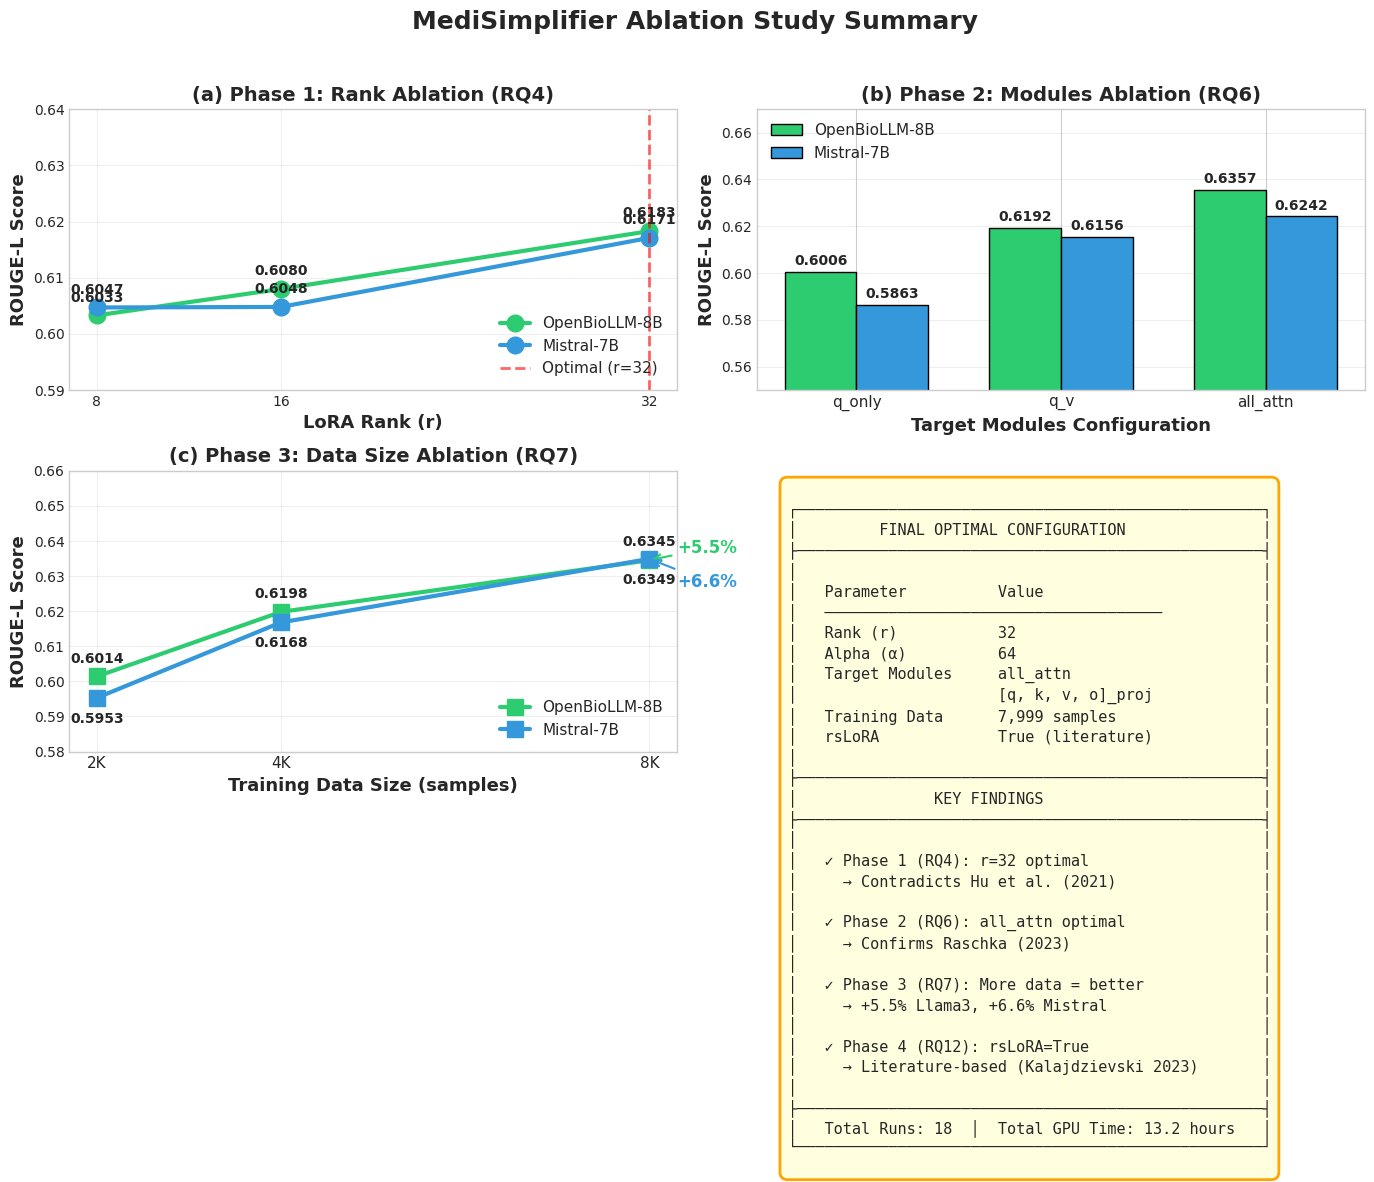


📦 6.2.4.7 Save Ablation Summary JSON:
   ✓ Saved: ablation_summary.json

ABLATION STUDY COMPLETE

┌─────────────────────────────────────────────────────────────────────┐
│                    FINAL OPTIMAL CONFIGURATION                      │
├─────────────────────────────────────────────────────────────────────┤
│  Rank (r):          32                                              │
│  Alpha (α):         64                                              │
│  Target Modules:    q_proj, k_proj, v_proj, o_proj (all_attn)       │
│  rsLoRA:            True                                            │
│  Training Data:     7,999 samples                                   │
├─────────────────────────────────────────────────────────────────────┤
│  Total Ablation Runs: 18                                            │
│  Total GPU Time: 13.2 hours                                          │
└─────────────────────────────────────────────────────────────────────┘


✅ SECTION 6.2.4 COMPLETE - Ready f

In [15]:
# =============================================================================
# SECTION 6.2.4: ABLATION SUMMARY & VISUALIZATION
# =============================================================================

print("=" * 70)
print("SECTION 6.2.4: ABLATION SUMMARY & VISUALIZATION")
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.2.4.1 Load All Ablation Checkpoints
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.1 Load All Ablation Checkpoints:")

# Define checkpoint paths for both architectures
ABLATION_FILES = {
    "rank_llama3": ABLATION_DIR / "rank_ablation_llama3.json",
    "rank_mistral": ABLATION_DIR / "rank_ablation_mistral.json",
    "modules_llama3": ABLATION_DIR / "modules_ablation_llama3.json",
    "modules_mistral": ABLATION_DIR / "modules_ablation_mistral.json",
    "size_llama3": ABLATION_DIR / "size_ablation_llama3.json",
    "size_mistral": ABLATION_DIR / "size_ablation_mistral.json",
}

# Load all checkpoints into dictionary
ablation_data = {}
for key, path in ABLATION_FILES.items():
    if path.exists():
        with open(path, "r") as f:
            ablation_data[key] = json.load(f)
        print(f"   ✓ Loaded: {path.name}")
    else:
        print(f"   ❌ Missing: {path.name}")
        ablation_data[key] = None

# Verify all loaded
all_loaded = all(v is not None for v in ablation_data.values())
print(f"\n   All files loaded: {all_loaded}")

# -----------------------------------------------------------------------------
# 6.2.4.2 Create Summary DataFrames
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.2 Create Summary DataFrames:")

# Phase 1: Rank Ablation
rank_rows = []
for arch in ["llama3", "mistral"]:
    data = ablation_data[f"rank_{arch}"]
    if data:
        for r in data["results"]:
            rank_rows.append({
                "Architecture": "Llama3" if arch == "llama3" else "Mistral",
                "Model": data["model"],
                "Rank": r["rank"],
                "Alpha": r["alpha"],
                "Params (M)": round(r["trainable_params"] / 1e6, 2),
                "Train Loss": round(r["train_loss"], 4),
                "Eval Loss": round(r["eval_loss"], 4),
                "ROUGE-L": round(r["rouge_l"], 4),
                "FK Grade": round(r["fk_grade_mean"], 2),
                "Time (min)": round(r["run_time_minutes"], 1),
            })
df_rank = pd.DataFrame(rank_rows)
print(f"   ✓ Rank ablation: {len(df_rank)} rows")

# Phase 2: Modules Ablation
modules_rows = []
for arch in ["llama3", "mistral"]:
    data = ablation_data[f"modules_{arch}"]
    if data:
        for r in data["results"]:
            modules_rows.append({
                "Architecture": "Llama3" if arch == "llama3" else "Mistral",
                "Model": data["model"],
                "Config": r["config_name"],
                "Modules": ", ".join(r["target_modules"]),
                "Params (M)": round(r["trainable_params"] / 1e6, 2),
                "Train Loss": round(r["train_loss"], 4),
                "Eval Loss": round(r["eval_loss"], 4),
                "ROUGE-L": round(r["rouge_l"], 4),
                "FK Grade": round(r["fk_grade_mean"], 2),
                "Time (min)": round(r["run_time_minutes"], 1),
            })
df_modules = pd.DataFrame(modules_rows)
print(f"   ✓ Modules ablation: {len(df_modules)} rows")

# Phase 3: Data Size Ablation
size_rows = []
for arch in ["llama3", "mistral"]:
    data = ablation_data[f"size_{arch}"]
    if data:
        for r in data["results"]:
            size_rows.append({
                "Architecture": "Llama3" if arch == "llama3" else "Mistral",
                "Model": data["model"],
                "Data Size": r["data_size"],
                "Config": r["config_name"],
                "Train Loss": round(r["train_loss"], 4),
                "Eval Loss": round(r["eval_loss"], 4),
                "ROUGE-L": round(r["rouge_l"], 4),
                "FK Grade": round(r["fk_grade_mean"], 2),
                "Time (min)": round(r["run_time_minutes"], 1),
            })
df_size = pd.DataFrame(size_rows)
print(f"   ✓ Size ablation: {len(df_size)} rows")

# -----------------------------------------------------------------------------
# 6.2.4.3 Display Summary Tables
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.3 Summary Tables:")

print(f"\n{'─'*80}")
print("PHASE 1: RANK ABLATION (RQ4)")
print(f"{'─'*80}")
print(df_rank.to_string(index=False))

print(f"\n{'─'*80}")
print("PHASE 2: MODULES ABLATION (RQ6)")
print(f"{'─'*80}")
print(df_modules[["Architecture", "Model", "Config", "Params (M)", "ROUGE-L", "FK Grade"]].to_string(index=False))

print(f"\n{'─'*80}")
print("PHASE 3: DATA SIZE ABLATION (RQ7)")
print(f"{'─'*80}")
print(df_size.to_string(index=False))

# -----------------------------------------------------------------------------
# 6.2.4.4 Extract Optimal Values
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.4 Optimal Configuration Summary:")

optimal_summary = {
    "llama3": {
        "model": "OpenBioLLM-8B",
        "optimal_rank": ablation_data["rank_llama3"]["optimal_rank"],
        "rank_rouge": ablation_data["rank_llama3"]["optimal_rouge_l"],
        "optimal_modules": ablation_data["modules_llama3"]["optimal_modules_name"],
        "modules_rouge": ablation_data["modules_llama3"]["optimal_rouge_l"],
        "size_trend": ablation_data["size_llama3"]["trend"],
        "size_improvement": ablation_data["size_llama3"]["rouge_improvement_percent"],
        "final_rouge": ablation_data["size_llama3"]["results"][-1]["rouge_l"],
    },
    "mistral": {
        "model": "Mistral-7B",
        "optimal_rank": ablation_data["rank_mistral"]["optimal_rank"],
        "rank_rouge": ablation_data["rank_mistral"]["optimal_rouge_l"],
        "optimal_modules": ablation_data["modules_mistral"]["optimal_modules_name"],
        "modules_rouge": ablation_data["modules_mistral"]["optimal_rouge_l"],
        "size_trend": ablation_data["size_mistral"]["trend"],
        "size_improvement": ablation_data["size_mistral"]["rouge_improvement_percent"],
        "final_rouge": ablation_data["size_mistral"]["results"][-1]["rouge_l"],
    },
}

print(f"\n{'─'*80}")
print("OPTIMAL CONFIGURATION BY ARCHITECTURE")
print(f"{'─'*80}")
print(f"{'Metric':<25} {'Llama3 (OpenBioLLM)':<25} {'Mistral':<25}")
print(f"{'─'*80}")
print(f"{'Optimal Rank':<25} {optimal_summary['llama3']['optimal_rank']:<25} {optimal_summary['mistral']['optimal_rank']:<25}")
print(f"{'Optimal Modules':<25} {optimal_summary['llama3']['optimal_modules']:<25} {optimal_summary['mistral']['optimal_modules']:<25}")
print(f"{'Size Improvement':<25} +{optimal_summary['llama3']['size_improvement']:.2f}%{'':<18} +{optimal_summary['mistral']['size_improvement']:.2f}%")
print(f"{'Final ROUGE-L':<25} {optimal_summary['llama3']['final_rouge']:.4f}{'':<19} {optimal_summary['mistral']['final_rouge']:.4f}")

# -----------------------------------------------------------------------------
# 6.2.4.5 Calculate Total GPU Time
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.5 Total GPU Time:")

total_time_llama3 = (
    ablation_data["rank_llama3"]["total_time_minutes"] +
    ablation_data["modules_llama3"]["total_time_minutes"] +
    ablation_data["size_llama3"]["total_time_minutes"]
)
total_time_mistral = (
    ablation_data["rank_mistral"]["total_time_minutes"] +
    ablation_data["modules_mistral"]["total_time_minutes"] +
    ablation_data["size_mistral"]["total_time_minutes"]
)
total_time_all = total_time_llama3 + total_time_mistral

print(f"   Llama3 total:  {total_time_llama3:.1f} min ({total_time_llama3/60:.1f} hours)")
print(f"   Mistral total: {total_time_mistral:.1f} min ({total_time_mistral/60:.1f} hours)")
print(f"   Combined:      {total_time_all:.1f} min ({total_time_all/60:.1f} hours)")

# -----------------------------------------------------------------------------
# 6.2.4.6 Generate Visualizations
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.6 Generate Visualizations:")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {"Llama3": "#2ecc71", "Mistral": "#3498db"}

# Create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (a): Rank Ablation
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[0, 0]
for arch in ["Llama3", "Mistral"]:
    df_arch = df_rank[df_rank["Architecture"] == arch]
    label = "OpenBioLLM-8B" if arch == "Llama3" else "Mistral-7B"
    ax.plot(df_arch["Rank"], df_arch["ROUGE-L"], 
            marker='o', markersize=12, linewidth=3,
            color=COLORS[arch], label=label)
    # Value labels
    for _, row in df_arch.iterrows():
        ax.annotate(f'{row["ROUGE-L"]:.4f}', (row["Rank"], row["ROUGE-L"]),
                   textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, fontweight='bold')

ax.axvline(x=32, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Optimal (r=32)')
ax.set_xlabel("LoRA Rank (r)", fontsize=13, fontweight='bold')
ax.set_ylabel("ROUGE-L Score", fontsize=13, fontweight='bold')
ax.set_title("(a) Phase 1: Rank Ablation (RQ4)", fontsize=14, fontweight='bold')
ax.set_xticks([8, 16, 32])
ax.set_ylim(0.59, 0.64)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (b): Modules Ablation
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[0, 1]
configs = ["q_only", "q_v", "all_attn"]
x = np.arange(len(configs))
bar_width = 0.35

llama3_rouge = [df_modules[(df_modules["Architecture"] == "Llama3") & (df_modules["Config"] == c)]["ROUGE-L"].values[0] for c in configs]
mistral_rouge = [df_modules[(df_modules["Architecture"] == "Mistral") & (df_modules["Config"] == c)]["ROUGE-L"].values[0] for c in configs]

bars1 = ax.bar(x - bar_width/2, llama3_rouge, bar_width, label='OpenBioLLM-8B', 
               color=COLORS["Llama3"], edgecolor='black', linewidth=1)
bars2 = ax.bar(x + bar_width/2, mistral_rouge, bar_width, label='Mistral-7B', 
               color=COLORS["Mistral"], edgecolor='black', linewidth=1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel("Target Modules Configuration", fontsize=13, fontweight='bold')
ax.set_ylabel("ROUGE-L Score", fontsize=13, fontweight='bold')
ax.set_title("(b) Phase 2: Modules Ablation (RQ6)", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(configs, fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_ylim(0.55, 0.67)
ax.grid(True, alpha=0.3, axis='y')

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (c): Data Size Ablation
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[1, 0]
for arch in ["Llama3", "Mistral"]:
    df_arch = df_size[df_size["Architecture"] == arch]
    label = "OpenBioLLM-8B" if arch == "Llama3" else "Mistral-7B"
    ax.plot(df_arch["Data Size"], df_arch["ROUGE-L"], 
            marker='s', markersize=12, linewidth=3,
            color=COLORS[arch], label=label)
    # Value labels
    for i, row in df_arch.iterrows():
        offset = 10 if arch == "Llama3" else -18
        ax.annotate(f'{row["ROUGE-L"]:.4f}', (row["Data Size"], row["ROUGE-L"]),
                   textcoords="offset points", xytext=(0, offset), ha='center', fontsize=10, fontweight='bold')

# Improvement annotations
ax.annotate(f'+{optimal_summary["llama3"]["size_improvement"]:.1f}%', 
           xy=(7999, optimal_summary["llama3"]["final_rouge"]),
           xytext=(20, 5), textcoords="offset points", fontsize=12, 
           color=COLORS["Llama3"], fontweight='bold',
           arrowprops=dict(arrowstyle='->', color=COLORS["Llama3"], lw=1.5))
ax.annotate(f'+{optimal_summary["mistral"]["size_improvement"]:.1f}%', 
           xy=(7999, optimal_summary["mistral"]["final_rouge"]),
           xytext=(20, -20), textcoords="offset points", fontsize=12, 
           color=COLORS["Mistral"], fontweight='bold',
           arrowprops=dict(arrowstyle='->', color=COLORS["Mistral"], lw=1.5))

ax.set_xlabel("Training Data Size (samples)", fontsize=13, fontweight='bold')
ax.set_ylabel("ROUGE-L Score", fontsize=13, fontweight='bold')
ax.set_title("(c) Phase 3: Data Size Ablation (RQ7)", fontsize=14, fontweight='bold')
ax.set_xticks([2000, 4000, 7999])
ax.set_xticklabels(["2K", "4K", "8K"], fontsize=11)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0.58, 0.66)
ax.grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (d): Summary Box
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
┌───────────────────────────────────────────────────┐
│         FINAL OPTIMAL CONFIGURATION               │
├───────────────────────────────────────────────────┤
│                                                   │
│   Parameter          Value                        │
│   ─────────────────────────────────────           │
│   Rank (r)           32                           │
│   Alpha (α)          64                           │
│   Target Modules     all_attn                     │
│                      [q, k, v, o]_proj            │
│   Training Data      7,999 samples                │
│   rsLoRA             True (literature)            │
│                                                   │
├───────────────────────────────────────────────────┤
│               KEY FINDINGS                        │
├───────────────────────────────────────────────────┤
│                                                   │
│   ✓ Phase 1 (RQ4): r=32 optimal                   │
│     → Contradicts Hu et al. (2021)                │
│                                                   │
│   ✓ Phase 2 (RQ6): all_attn optimal               │
│     → Confirms Raschka (2023)                     │
│                                                   │
│   ✓ Phase 3 (RQ7): More data = better             │
│     → +5.5% Llama3, +6.6% Mistral                 │
│                                                   │
│   ✓ Phase 4 (RQ12): rsLoRA=True                   │
│     → Literature-based (Kalajdzievski 2023)       │
│                                                   │
├───────────────────────────────────────────────────┤
│   Total Runs: 18  │  Total GPU Time: {total_time_all/60:.1f} hours   │
└───────────────────────────────────────────────────┘
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='orange', linewidth=2))

# Main title and save
fig.suptitle("MediSimplifier Ablation Study Summary", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig(FIGURES_DIR / "ablation_summary.png", dpi=150, bbox_inches='tight', facecolor='white')
print(f"   ✓ Saved: {FIGURES_DIR / 'ablation_summary.png'}")
plt.show()

# -----------------------------------------------------------------------------
# 6.2.4.7 Save Ablation Summary JSON
# -----------------------------------------------------------------------------

print(f"\n📦 6.2.4.7 Save Ablation Summary JSON:")

ablation_summary_json = {
    "project": "MediSimplifier",
    "phases_completed": ["rank", "modules", "size"],
    "phase_4_rslora": "SKIPPED (literature-based: use_rslora=True)",
    "optimal_config": {
        "rank": 32,
        "alpha": 64,
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
        "target_modules_name": "all_attn",
        "use_rslora": True,
        "data_size": 7999,
    },
    "findings": {
        "RQ4_rank": "r=32 optimal (contradicts Hu et al. 2021)",
        "RQ6_modules": "all_attn optimal (confirms Raschka 2023)",
        "RQ7_data_size": f"More data = better (+{optimal_summary['llama3']['size_improvement']:.1f}% Llama3, +{optimal_summary['mistral']['size_improvement']:.1f}% Mistral)",
        "RQ12_rslora": "True (Kalajdzievski 2023)",
    },
    "architecture_results": optimal_summary,
    "total_gpu_time": {
        "llama3_minutes": round(total_time_llama3, 1),
        "mistral_minutes": round(total_time_mistral, 1),
        "total_minutes": round(total_time_all, 1),
        "total_hours": round(total_time_all / 60, 1),
    },
    "total_runs": 18,
    "timestamp": datetime.now().isoformat(),
}

summary_path = ABLATION_DIR / "ablation_summary.json"
with open(summary_path, "w") as f:
    json.dump(ablation_summary_json, f, indent=2)
print(f"   ✓ Saved: {summary_path.name}")

# -----------------------------------------------------------------------------
# 6.2.4.8 Final Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("ABLATION STUDY COMPLETE")
print(f"{'='*70}")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    FINAL OPTIMAL CONFIGURATION                      │
├─────────────────────────────────────────────────────────────────────┤
│  Rank (r):          32                                              │
│  Alpha (α):         64                                              │
│  Target Modules:    q_proj, k_proj, v_proj, o_proj (all_attn)       │
│  rsLoRA:            True                                            │
│  Training Data:     7,999 samples                                   │
├─────────────────────────────────────────────────────────────────────┤
│  Total Ablation Runs: 18                                            │
│  Total GPU Time: {total_time_all/60:.1f} hours                                          │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "=" * 70)
print("✅ SECTION 6.2.4 COMPLETE - Ready for Phase 5 (Full Training)")
print("=" * 70)

In [9]:
# =============================================================================
# SECTION 6.3.1: PHASE 5 - FULL TRAINING (OpenBioLLM-8B)
# =============================================================================

print("=" * 70)
print("SECTION 6.3.1: PHASE 5 - FULL TRAINING (OpenBioLLM-8B)")
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.3.1.1 Verify Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.1.1 Verify Configuration:")

# Confirm we're on the correct model/GPU
assert CURRENT_MODEL == "OpenBioLLM-8B", f"Expected OpenBioLLM-8B, got {CURRENT_MODEL}"
assert CURRENT_ARCHITECTURE == "llama3", f"Expected llama3, got {CURRENT_ARCHITECTURE}"

print(f"   ✓ Model: {CURRENT_MODEL}")
print(f"   ✓ Architecture: {CURRENT_ARCHITECTURE}")
print(f"   ✓ GPU: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")
print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.1.2 Define Optimal Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.1.2 Define Optimal Configuration:")

# Final optimal config from ablation study
OPTIMAL_CONFIG = {
    "rank": 32,                                              # Phase 1 optimal
    "alpha": 64,                                             # 2 × rank
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # Phase 2 optimal (all_attn)
    "use_rslora": True,                                      # Phase 4 literature-based
    "dropout": 0.05,                                         # Fixed
    "epochs": TRAINING_CONFIG["epochs_full"],                # 3 epochs for full training
}

print(f"   ✓ Rank: {OPTIMAL_CONFIG['rank']}")
print(f"   ✓ Alpha: {OPTIMAL_CONFIG['alpha']}")
print(f"   ✓ Modules: {OPTIMAL_CONFIG['target_modules']}")
print(f"   ✓ rsLoRA: {OPTIMAL_CONFIG['use_rslora']}")
print(f"   ✓ Epochs: {OPTIMAL_CONFIG['epochs']}")

# -----------------------------------------------------------------------------
# 6.3.1.3 Check for Existing Checkpoint
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.1.3 Check for Existing Checkpoint:")

# Define output paths
FINAL_CHECKPOINT_PATH = TRAINING_DIR / f"final_training_{CURRENT_ARCHITECTURE}.json"
LORA_ADAPTER_PATH = MODELS_DIR / f"{CURRENT_MODEL.lower().replace('-', '_')}_lora"

# Check if already completed
if FINAL_CHECKPOINT_PATH.exists():
    checkpoint = load_checkpoint(FINAL_CHECKPOINT_PATH)
    if checkpoint and checkpoint.get("completed", False):
        print(f"   ✓ Training already completed!")
        print(f"   ✓ Checkpoint: {FINAL_CHECKPOINT_PATH.name}")
        print(f"   ✓ ROUGE-L: {checkpoint.get('rouge_l', 'N/A'):.4f}")
        print(f"   ✓ FK-Grade: {checkpoint.get('fk_grade_mean', 'N/A'):.2f}")
        print(f"\n   ⏭️ Skipping training. Run next cell to continue.")
        SKIP_TRAINING = True
    else:
        SKIP_TRAINING = False
else:
    print(f"   → No checkpoint found. Starting training...")
    SKIP_TRAINING = False

# -----------------------------------------------------------------------------
# 6.3.1.4 Load Dataset
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.4 Load Dataset:")
    
    # Load instruction dataset from Chapter 5
    dataset = load_from_disk(str(CURRENT_DATASET_PATH))
    
    print(f"   ✓ Train samples: {len(dataset['train'])}")
    print(f"   ✓ Validation samples: {len(dataset['validation'])}")
    print(f"   ✓ Test samples: {len(dataset['test'])}")

# -----------------------------------------------------------------------------
# 6.3.1.5 Load Model and Tokenizer
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.5 Load Model and Tokenizer:")
    
    # Clear memory before loading
    clear_memory()
    
    # Get model path from config
    model_path = MODEL_CONFIG["path"]
    print(f"   Loading: {model_path}")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        trust_remote_code=True,
        padding_side="right",
    )
    
    # Set pad token if not defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    print(f"   ✓ Tokenizer loaded")
    print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
    print(f"   ✓ Pad token: {tokenizer.pad_token}")
    
    # Load model in BF16
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )
    
    print(f"   ✓ Model loaded")
    print(f"   ✓ Model dtype: {model.dtype}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.1.6 Apply LoRA Configuration
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.6 Apply LoRA Configuration:")
    
    # Create LoRA config with optimal parameters
    lora_config = LoraConfig(
        r=OPTIMAL_CONFIG["rank"],
        lora_alpha=OPTIMAL_CONFIG["alpha"],
        lora_dropout=OPTIMAL_CONFIG["dropout"],
        target_modules=OPTIMAL_CONFIG["target_modules"],
        use_rslora=OPTIMAL_CONFIG["use_rslora"],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
    )
    
    # Apply LoRA to model
    model = get_peft_model(model, lora_config)
    
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_pct = 100 * trainable_params / total_params
    
    print(f"   ✓ LoRA applied")
    print(f"   ✓ Trainable params: {trainable_params:,} ({trainable_pct:.2f}%)")
    print(f"   ✓ Total params: {total_params:,}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.1.7 Tokenize Dataset
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.7 Tokenize Dataset:")
    
    def tokenize_function(examples):
        """Tokenize the 'text' field from instruction dataset."""
        # Tokenize with truncation and padding
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            max_length=TRAINING_CONFIG["max_seq_length"],
            padding="max_length",
        )
        # Set labels equal to input_ids for causal LM
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized
    
    # Tokenize train and validation sets
    tokenized_train = dataset["train"].map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["train"].column_names,
        desc="Tokenizing train",
    )
    
    tokenized_val = dataset["validation"].map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["validation"].column_names,
        desc="Tokenizing validation",
    )
    
    print(f"   ✓ Train tokenized: {len(tokenized_train)} samples")
    print(f"   ✓ Validation tokenized: {len(tokenized_val)} samples")

# -----------------------------------------------------------------------------
# 6.3.1.8 Setup Training Arguments
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.8 Setup Training Arguments:")
    
    # Create output directory for this training run
    output_dir = CHECKPOINTS_DIR / f"full_training_{CURRENT_ARCHITECTURE}"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create training arguments
    training_args = TrainingArguments(
        output_dir=str(output_dir),
        num_train_epochs=OPTIMAL_CONFIG["epochs"],
        per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
        per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
        gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
        learning_rate=TRAINING_CONFIG["learning_rate"],
        lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
        warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
        weight_decay=TRAINING_CONFIG["weight_decay"],
        bf16=TRAINING_CONFIG["bf16"],
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        run_name=f"full_training_{CURRENT_MODEL}",
        seed=SEED,
        dataloader_num_workers=4,
        remove_unused_columns=False,
    )
    
    print(f"   ✓ Output dir: {output_dir}")
    print(f"   ✓ Epochs: {training_args.num_train_epochs}")
    print(f"   ✓ Batch size: {training_args.per_device_train_batch_size}")
    print(f"   ✓ Gradient accumulation: {training_args.gradient_accumulation_steps}")
    print(f"   ✓ Effective batch: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
    print(f"   ✓ Learning rate: {training_args.learning_rate}")

# -----------------------------------------------------------------------------
# 6.3.1.9 Create Trainer
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.9 Create Trainer:")
    
    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,  # Causal LM, not masked LM
    )
    
    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
    )
    
    print(f"   ✓ Trainer created")
    print(f"   ✓ Train batches: {len(trainer.get_train_dataloader())}")
    print(f"   ✓ Eval batches: {len(trainer.get_eval_dataloader())}")

# -----------------------------------------------------------------------------
# 6.3.1.10 Train Model
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.10 Train Model:")
    print(f"   Starting {OPTIMAL_CONFIG['epochs']}-epoch training...")
    print(f"   {'─'*60}")
    
    # Record start time
    train_start_time = time.time()
    
    # Train the model
    train_result = trainer.train()
    
    # Record end time
    train_end_time = time.time()
    train_time_minutes = (train_end_time - train_start_time) / 60
    
    print(f"   {'─'*60}")
    print(f"   ✓ Training complete!")
    print(f"   ✓ Training time: {train_time_minutes:.1f} minutes")
    print(f"   ✓ Final train loss: {train_result.training_loss:.4f}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.1.11 Evaluate Model
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.11 Evaluate Model:")
    
    # Run evaluation
    eval_result = trainer.evaluate()
    
    print(f"   ✓ Eval loss: {eval_result['eval_loss']:.4f}")

# -----------------------------------------------------------------------------
# 6.3.1.12 Save LoRA Adapter
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.12 Save LoRA Adapter:")
    
    # Create adapter directory
    LORA_ADAPTER_PATH.mkdir(parents=True, exist_ok=True)
    
    # Save LoRA adapter
    model.save_pretrained(str(LORA_ADAPTER_PATH))
    tokenizer.save_pretrained(str(LORA_ADAPTER_PATH))
    
    print(f"   ✓ Adapter saved: {LORA_ADAPTER_PATH}")
    
    # List saved files
    saved_files = list(LORA_ADAPTER_PATH.glob("*"))
    for f in saved_files[:5]:
        print(f"      - {f.name}")
    if len(saved_files) > 5:
        print(f"      ... and {len(saved_files) - 5} more files")

# -----------------------------------------------------------------------------
# 6.3.1.13 Generate Validation Predictions for Metrics
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.13 Generate Validation Predictions:")
    
    # Use subset for quick evaluation (same as ablation)
    eval_subset_size = 100
    eval_indices = list(range(min(eval_subset_size, len(dataset["validation"]))))
    eval_subset = dataset["validation"].select(eval_indices)
    
    print(f"   Generating {len(eval_subset)} predictions...")
    
    # Set model to eval mode
    model.eval()
    
    # Store predictions and references
    predictions = []
    references = []
    
    # Generate predictions
    with torch.no_grad():
        for i, sample in enumerate(tqdm(eval_subset, desc="Generating")):
            # Extract original and reference from the sample
            # The 'text' field contains the full formatted training example
            # We need to extract input and generate output
            
            # Get the original text and reference from raw dataset
            original_text = sample.get("original", sample.get("input", ""))
            reference_text = sample.get("simplified", sample.get("output", ""))
            
            # Format inference prompt
            inference_prompt = format_inference_prompt(
                instruction=TASK_INSTRUCTION,
                input_text=original_text,
                prompt_format=MODEL_CONFIG["prompt_format"]
            )
            
            # Tokenize
            inputs = tokenizer(
                inference_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=TRAINING_CONFIG["max_seq_length"],
            ).to(model.device)
            
            # Generate
            outputs = model.generate(
                **inputs,
                max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
            
            # Decode (only new tokens)
            generated_text = tokenizer.decode(
                outputs[0][inputs["input_ids"].shape[1]:],
                skip_special_tokens=True
            ).strip()
            
            predictions.append(generated_text)
            references.append(reference_text)
    
    print(f"   ✓ Generated {len(predictions)} predictions")

# -----------------------------------------------------------------------------
# 6.3.1.14 Compute Metrics
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.14 Compute Metrics:")
    
    # Initialize ROUGE scorer
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    # Compute ROUGE-L scores
    rouge_scores = []
    for pred, ref in zip(predictions, references):
        if pred and ref:  # Skip empty
            score = rouge_scorer_obj.score(ref, pred)
            rouge_scores.append(score['rougeL'].fmeasure)
    
    rouge_l_mean = np.mean(rouge_scores) if rouge_scores else 0.0
    
    # Compute FK-Grade scores
    fk_scores = []
    for pred in predictions:
        if pred and len(pred.split()) >= 10:  # Need minimum words
            try:
                fk = textstat.flesch_kincaid_grade(pred)
                fk_scores.append(fk)
            except:
                pass
    
    fk_grade_mean = np.mean(fk_scores) if fk_scores else 0.0
    fk_grade_std = np.std(fk_scores) if fk_scores else 0.0
    
    print(f"   ✓ ROUGE-L: {rouge_l_mean:.4f}")
    print(f"   ✓ FK-Grade: {fk_grade_mean:.2f} (±{fk_grade_std:.2f})")

# -----------------------------------------------------------------------------
# 6.3.1.15 Save Checkpoint
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.1.15 Save Checkpoint:")
    
    # Compile results
    checkpoint_data = {
        "model": CURRENT_MODEL,
        "architecture": CURRENT_ARCHITECTURE,
        "phase": "full_training",
        "config": OPTIMAL_CONFIG,
        "trainable_params": trainable_params,
        "train_loss": train_result.training_loss,
        "eval_loss": eval_result["eval_loss"],
        "rouge_l": rouge_l_mean,
        "fk_grade_mean": fk_grade_mean,
        "fk_grade_std": fk_grade_std,
        "train_time_minutes": train_time_minutes,
        "adapter_path": str(LORA_ADAPTER_PATH),
        "completed": True,
    }
    
    # Save checkpoint
    save_checkpoint(checkpoint_data, FINAL_CHECKPOINT_PATH)
    
    print(f"   ✓ Saved: {FINAL_CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 6.3.1.16 Final Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("PHASE 5 TRAINING COMPLETE - OpenBioLLM-8B")
print(f"{'='*70}")

if SKIP_TRAINING:
    # Load from checkpoint
    checkpoint = load_checkpoint(FINAL_CHECKPOINT_PATH)
    print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    TRAINING RESULTS (from checkpoint)               │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {checkpoint['model']:<50} │
│  Architecture:    {checkpoint['architecture']:<50} │
│  Trainable Params: {checkpoint['trainable_params']:,}{'':<38} │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      {checkpoint['train_loss']:<50.4f} │
│  Eval Loss:       {checkpoint['eval_loss']:<50.4f} │
│  ROUGE-L:         {checkpoint['rouge_l']:<50.4f} │
│  FK-Grade:        {checkpoint['fk_grade_mean']:.2f} (±{checkpoint['fk_grade_std']:.2f}){'':<40} │
├─────────────────────────────────────────────────────────────────────┤
│  Training Time:   {checkpoint['train_time_minutes']:.1f} minutes{'':<43} │
│  Adapter Path:    {checkpoint['adapter_path']:<50} │
└─────────────────────────────────────────────────────────────────────┘
""")
else:
    print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                         TRAINING RESULTS                            │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Architecture:    {CURRENT_ARCHITECTURE:<50} │
│  Trainable Params: {trainable_params:,}{'':<38} │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      {train_result.training_loss:<50.4f} │
│  Eval Loss:       {eval_result['eval_loss']:<50.4f} │
│  ROUGE-L:         {rouge_l_mean:<50.4f} │
│  FK-Grade:        {fk_grade_mean:.2f} (±{fk_grade_std:.2f}){'':<40} │
├─────────────────────────────────────────────────────────────────────┤
│  Training Time:   {train_time_minutes:.1f} minutes{'':<43} │
│  Adapter Path:    {str(LORA_ADAPTER_PATH):<50} │
└─────────────────────────────────────────────────────────────────────┘
""")

# Cleanup
if not SKIP_TRAINING:
    del model, trainer
    clear_memory()

print("\n" + "=" * 70)
print("✅ SECTION 6.3.1 COMPLETE")
print("=" * 70)
print_gpu_memory()

SECTION 6.3.1: PHASE 5 - FULL TRAINING (OpenBioLLM-8B)

📦 6.3.1.1 Verify Configuration:
   ✓ Model: OpenBioLLM-8B
   ✓ Architecture: llama3
   ✓ GPU: 0
   GPU Memory: 16.6GB allocated, 85.7GB reserved

📦 6.3.1.2 Define Optimal Configuration:
   ✓ Rank: 32
   ✓ Alpha: 64
   ✓ Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
   ✓ rsLoRA: True
   ✓ Epochs: 3

📦 6.3.1.3 Check for Existing Checkpoint:
   → No checkpoint found. Starting training...

📦 6.3.1.4 Load Dataset:
   ✓ Train samples: 7999
   ✓ Validation samples: 999
   ✓ Test samples: 1001

📦 6.3.1.5 Load Model and Tokenizer:
   Loading: aaditya/Llama3-OpenBioLLM-8B
   ✓ Tokenizer loaded
   ✓ Vocab size: 128000
   ✓ Pad token: <|end_of_text|>


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

   ✓ Model loaded
   ✓ Model dtype: torch.bfloat16
   GPU Memory: 32.6GB allocated, 32.7GB reserved

📦 6.3.1.6 Apply LoRA Configuration:
   ✓ LoRA applied
   ✓ Trainable params: 27,262,976 (0.34%)
   ✓ Total params: 8,057,524,224
   GPU Memory: 32.7GB allocated, 32.8GB reserved

📦 6.3.1.7 Tokenize Dataset:


Tokenizing validation:   0%|          | 0/999 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


   ✓ Train tokenized: 7999 samples
   ✓ Validation tokenized: 999 samples

📦 6.3.1.8 Setup Training Arguments:
   ✓ Output dir: /workspace/medisimplifier/checkpoints/full_training_llama3
   ✓ Epochs: 3
   ✓ Batch size: 4
   ✓ Gradient accumulation: 4
   ✓ Effective batch: 16
   ✓ Learning rate: 0.0002

📦 6.3.1.9 Create Trainer:
   ✓ Trainer created
   ✓ Train batches: 2000
   ✓ Eval batches: 250

📦 6.3.1.10 Train Model:
   Starting 3-epoch training...
   ────────────────────────────────────────────────────────────


Epoch,Training Loss,Validation Loss
1,0.793226,0.779564
2,0.701380,0.765940
3,0.599488,0.792459


   ────────────────────────────────────────────────────────────
   ✓ Training complete!
   ✓ Training time: 90.9 minutes
   ✓ Final train loss: 0.7116
   GPU Memory: 33.0GB allocated, 102.3GB reserved

📦 6.3.1.11 Evaluate Model:


   ✓ Eval loss: 0.7659

📦 6.3.1.12 Save LoRA Adapter:
   ✓ Adapter saved: /workspace/medisimplifier/models/openbiollm_8b_lora
      - tokenizer.json
      - tokenizer_config.json
      - adapter_config.json
      - adapter_model.safetensors
      - README.md

📦 6.3.1.13 Generate Validation Predictions:
   Generating 100 predictions...


Generating:   0%|          | 0/100 [00:00<?, ?it/s]

   ✓ Generated 100 predictions

📦 6.3.1.14 Compute Metrics:
   ✓ ROUGE-L: 0.6721
   ✓ FK-Grade: 6.84 (±1.00)

📦 6.3.1.15 Save Checkpoint:
   ✓ Checkpoint saved: final_training_llama3.json
   ✓ Saved: final_training_llama3.json

PHASE 5 TRAINING COMPLETE - OpenBioLLM-8B

┌─────────────────────────────────────────────────────────────────────┐
│                         TRAINING RESULTS                            │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           OpenBioLLM-8B                                      │
│  Architecture:    llama3                                             │
│  Trainable Params: 27,262,976                                       │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      0.7116                                             │
│  Eval Loss:       0.7659                                             │
│  ROUGE-L:         0.6721                                             │
│  F

In [16]:
# =============================================================================
# SECTION 6.3.2: PHASE 5 - FULL TRAINING (Mistral-7B)
# =============================================================================
# GPU Assignment: GPU 1
# Architecture: Mistral
# =============================================================================

print("=" * 70)
print("SECTION 6.3.2: PHASE 5 - FULL TRAINING (Mistral-7B)")
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.3.2.1 Verify Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.2.1 Verify Configuration:")

# Confirm we're on the correct model/GPU
CURRENT_MODEL = "Mistral-7B"
CURRENT_ARCHITECTURE = "mistral"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

assert CURRENT_MODEL == "Mistral-7B", f"Expected Mistral-7B, got {CURRENT_MODEL}"
assert CURRENT_ARCHITECTURE == "mistral", f"Expected mistral, got {CURRENT_ARCHITECTURE}"

print(f"   ✓ Model: {CURRENT_MODEL}")
print(f"   ✓ Architecture: {CURRENT_ARCHITECTURE}")
print(f"   ✓ GPU: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")
print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.2.2 Define Optimal Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.2.2 Define Optimal Configuration:")

# Final optimal config from ablation study (Mistral architecture)
OPTIMAL_CONFIG = {
    "rank": 32,                                              # Phase 1 optimal
    "alpha": 64,                                             # 2 × rank
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # Phase 2 optimal (all_attn)
    "use_rslora": True,                                      # Phase 4 literature-based
    "dropout": 0.05,                                         # Fixed
    "epochs": TRAINING_CONFIG["epochs_full"],                # 3 epochs for full training
}

print(f"   ✓ Rank: {OPTIMAL_CONFIG['rank']}")
print(f"   ✓ Alpha: {OPTIMAL_CONFIG['alpha']}")
print(f"   ✓ Modules: {OPTIMAL_CONFIG['target_modules']}")
print(f"   ✓ rsLoRA: {OPTIMAL_CONFIG['use_rslora']}")
print(f"   ✓ Epochs: {OPTIMAL_CONFIG['epochs']}")

# -----------------------------------------------------------------------------
# 6.3.2.3 Check for Existing Checkpoint
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.2.3 Check for Existing Checkpoint:")

# Define output paths
FINAL_CHECKPOINT_PATH = TRAINING_DIR / f"final_training_{CURRENT_ARCHITECTURE}.json"
LORA_ADAPTER_PATH = MODELS_DIR / "mistral_7b_lora"

# Check if already completed
if FINAL_CHECKPOINT_PATH.exists():
    checkpoint = load_checkpoint(FINAL_CHECKPOINT_PATH)
    if checkpoint and checkpoint.get("completed", False):
        print(f"   ✓ Training already completed!")
        print(f"   ✓ Checkpoint: {FINAL_CHECKPOINT_PATH.name}")
        print(f"   ✓ ROUGE-L: {checkpoint.get('rouge_l', 'N/A'):.4f}")
        print(f"   ✓ FK-Grade: {checkpoint.get('fk_grade_mean', 'N/A'):.2f}")
        print(f"\n   ⏭️ Skipping training. Run next cell to continue.")
        SKIP_TRAINING = True
    else:
        SKIP_TRAINING = False
else:
    print(f"   → No checkpoint found. Starting training...")
    SKIP_TRAINING = False

# -----------------------------------------------------------------------------
# 6.3.2.4 Load Dataset
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.4 Load Dataset:")
    
    # Load instruction dataset from Chapter 5 (Mistral format)
    dataset = load_from_disk(str(CURRENT_DATASET_PATH))
    
    print(f"   ✓ Dataset format: {MODEL_CONFIG['prompt_format']}")
    print(f"   ✓ Train samples: {len(dataset['train'])}")
    print(f"   ✓ Validation samples: {len(dataset['validation'])}")
    print(f"   ✓ Test samples: {len(dataset['test'])}")

# -----------------------------------------------------------------------------
# 6.3.2.5 Load Model and Tokenizer
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.5 Load Model and Tokenizer:")
    
    # Clear memory before loading
    clear_memory()
    
    # Get model path from config
    model_path = MODEL_CONFIG["path"]
    print(f"   Loading: {model_path}")
    
    # HF API fix - suppress discussions endpoint errors
    try:
        from huggingface_hub import HfApi
        HfApi._check_discussions_enabled = lambda *args, **kwargs: None
    except:
        pass
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        trust_remote_code=True,
        padding_side="right",
    )
    
    # Set pad token if not defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    print(f"   ✓ Tokenizer loaded")
    print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
    print(f"   ✓ Pad token: {tokenizer.pad_token}")
    
    # Load model in BF16
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )
    
    print(f"   ✓ Model loaded")
    print(f"   ✓ Model dtype: {model.dtype}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.2.6 Apply LoRA Configuration
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.6 Apply LoRA Configuration:")
    
    # Create LoRA config with optimal parameters
    lora_config = LoraConfig(
        r=OPTIMAL_CONFIG["rank"],
        lora_alpha=OPTIMAL_CONFIG["alpha"],
        lora_dropout=OPTIMAL_CONFIG["dropout"],
        target_modules=OPTIMAL_CONFIG["target_modules"],
        use_rslora=OPTIMAL_CONFIG["use_rslora"],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
    )
    
    # Apply LoRA to model
    model = get_peft_model(model, lora_config)
    
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_pct = 100 * trainable_params / total_params
    
    print(f"   ✓ LoRA applied")
    print(f"   ✓ Trainable params: {trainable_params:,} ({trainable_pct:.2f}%)")
    print(f"   ✓ Total params: {total_params:,}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.2.7 Tokenize Dataset
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.7 Tokenize Dataset:")
    
    def tokenize_function(examples):
        """Tokenize the 'text' field from instruction dataset."""
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            max_length=TRAINING_CONFIG["max_seq_length"],
            padding="max_length",
        )
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized
    
    # Tokenize train and validation sets
    tokenized_train = dataset["train"].map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["train"].column_names,
        desc="Tokenizing train",
    )
    
    tokenized_val = dataset["validation"].map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["validation"].column_names,
        desc="Tokenizing validation",
    )
    
    print(f"   ✓ Train tokenized: {len(tokenized_train)} samples")
    print(f"   ✓ Validation tokenized: {len(tokenized_val)} samples")

# -----------------------------------------------------------------------------
# 6.3.2.8 Setup Training Arguments
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.8 Setup Training Arguments:")
    
    # Create output directory for this training run
    output_dir = CHECKPOINTS_DIR / f"full_training_{CURRENT_ARCHITECTURE}"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create training arguments
    training_args = TrainingArguments(
        output_dir=str(output_dir),
        num_train_epochs=OPTIMAL_CONFIG["epochs"],
        per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
        per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
        gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
        learning_rate=TRAINING_CONFIG["learning_rate"],
        lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
        warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
        weight_decay=TRAINING_CONFIG["weight_decay"],
        bf16=TRAINING_CONFIG["bf16"],
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        run_name=f"full_training_{CURRENT_MODEL}",
        seed=SEED,
        dataloader_num_workers=4,
        remove_unused_columns=False,
    )
    
    print(f"   ✓ Output dir: {output_dir}")
    print(f"   ✓ Epochs: {training_args.num_train_epochs}")
    print(f"   ✓ Batch size: {training_args.per_device_train_batch_size}")
    print(f"   ✓ Gradient accumulation: {training_args.gradient_accumulation_steps}")
    print(f"   ✓ Effective batch: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
    print(f"   ✓ Learning rate: {training_args.learning_rate}")

# -----------------------------------------------------------------------------
# 6.3.2.9 Create Trainer
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.9 Create Trainer:")
    
    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
    )
    
    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
    )
    
    print(f"   ✓ Trainer created")
    print(f"   ✓ Train batches: {len(trainer.get_train_dataloader())}")
    print(f"   ✓ Eval batches: {len(trainer.get_eval_dataloader())}")

# -----------------------------------------------------------------------------
# 6.3.2.10 Train Model
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.10 Train Model:")
    print(f"   Starting {OPTIMAL_CONFIG['epochs']}-epoch training...")
    print(f"   {'─'*60}")
    
    train_start_time = time.time()
    train_result = trainer.train()
    train_end_time = time.time()
    train_time_minutes = (train_end_time - train_start_time) / 60
    
    print(f"   {'─'*60}")
    print(f"   ✓ Training complete!")
    print(f"   ✓ Training time: {train_time_minutes:.1f} minutes")
    print(f"   ✓ Final train loss: {train_result.training_loss:.4f}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.2.11 Evaluate Model
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.11 Evaluate Model:")
    eval_result = trainer.evaluate()
    print(f"   ✓ Eval loss: {eval_result['eval_loss']:.4f}")

# -----------------------------------------------------------------------------
# 6.3.2.12 Save LoRA Adapter
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.12 Save LoRA Adapter:")
    
    LORA_ADAPTER_PATH.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(str(LORA_ADAPTER_PATH))
    tokenizer.save_pretrained(str(LORA_ADAPTER_PATH))
    
    print(f"   ✓ Adapter saved: {LORA_ADAPTER_PATH}")
    
    saved_files = list(LORA_ADAPTER_PATH.glob("*"))
    for f in saved_files[:5]:
        print(f"      - {f.name}")
    if len(saved_files) > 5:
        print(f"      ... and {len(saved_files) - 5} more files")

# -----------------------------------------------------------------------------
# 6.3.2.13 Generate Validation Predictions for Metrics
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.13 Generate Validation Predictions:")
    
    eval_subset_size = 100
    eval_indices = list(range(min(eval_subset_size, len(dataset["validation"]))))
    eval_subset = dataset["validation"].select(eval_indices)
    
    print(f"   Generating {len(eval_subset)} predictions...")
    
    model.eval()
    predictions = []
    references = []
    
    with torch.no_grad():
        for i, sample in enumerate(tqdm(eval_subset, desc="Generating")):
            original_text = sample.get("original", sample.get("input", ""))
            reference_text = sample.get("simplified", sample.get("output", ""))
            
            inference_prompt = format_inference_prompt(
                instruction=TASK_INSTRUCTION,
                input_text=original_text,
                prompt_format=MODEL_CONFIG["prompt_format"]
            )
            
            inputs = tokenizer(
                inference_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=TRAINING_CONFIG["max_seq_length"],
            ).to(model.device)
            
            outputs = model.generate(
                **inputs,
                max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
            
            generated_text = tokenizer.decode(
                outputs[0][inputs["input_ids"].shape[1]:],
                skip_special_tokens=True
            ).strip()
            
            predictions.append(generated_text)
            references.append(reference_text)
    
    print(f"   ✓ Generated {len(predictions)} predictions")

# -----------------------------------------------------------------------------
# 6.3.2.14 Compute Metrics
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.14 Compute Metrics:")
    
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    rouge_scores = []
    for pred, ref in zip(predictions, references):
        if pred and ref:
            score = rouge_scorer_obj.score(ref, pred)
            rouge_scores.append(score['rougeL'].fmeasure)
    
    rouge_l_mean = np.mean(rouge_scores) if rouge_scores else 0.0
    
    fk_scores = []
    for pred in predictions:
        if pred and len(pred.split()) >= 10:
            try:
                fk = textstat.flesch_kincaid_grade(pred)
                fk_scores.append(fk)
            except:
                pass
    
    fk_grade_mean = np.mean(fk_scores) if fk_scores else 0.0
    fk_grade_std = np.std(fk_scores) if fk_scores else 0.0
    
    print(f"   ✓ ROUGE-L: {rouge_l_mean:.4f}")
    print(f"   ✓ FK-Grade: {fk_grade_mean:.2f} (±{fk_grade_std:.2f})")

# -----------------------------------------------------------------------------
# 6.3.2.15 Save Checkpoint
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.2.15 Save Checkpoint:")
    
    checkpoint_data = {
        "model": CURRENT_MODEL,
        "architecture": CURRENT_ARCHITECTURE,
        "phase": "full_training",
        "config": OPTIMAL_CONFIG,
        "trainable_params": trainable_params,
        "train_loss": train_result.training_loss,
        "eval_loss": eval_result["eval_loss"],
        "rouge_l": rouge_l_mean,
        "fk_grade_mean": fk_grade_mean,
        "fk_grade_std": fk_grade_std,
        "train_time_minutes": train_time_minutes,
        "adapter_path": str(LORA_ADAPTER_PATH),
        "completed": True,
    }
    
    save_checkpoint(checkpoint_data, FINAL_CHECKPOINT_PATH)
    print(f"   ✓ Saved: {FINAL_CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 6.3.2.16 Final Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("PHASE 5 TRAINING COMPLETE - Mistral-7B")
print(f"{'='*70}")

if SKIP_TRAINING:
    checkpoint = load_checkpoint(FINAL_CHECKPOINT_PATH)
    print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    TRAINING RESULTS (from checkpoint)               │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {checkpoint['model']:<50} │
│  Architecture:    {checkpoint['architecture']:<50} │
│  Trainable Params: {checkpoint['trainable_params']:,}{'':<38} │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      {checkpoint['train_loss']:<50.4f} │
│  Eval Loss:       {checkpoint['eval_loss']:<50.4f} │
│  ROUGE-L:         {checkpoint['rouge_l']:<50.4f} │
│  FK-Grade:        {checkpoint['fk_grade_mean']:.2f} (±{checkpoint['fk_grade_std']:.2f}){'':<40} │
├─────────────────────────────────────────────────────────────────────┤
│  Training Time:   {checkpoint['train_time_minutes']:.1f} minutes{'':<43} │
│  Adapter Path:    {checkpoint['adapter_path']:<50} │
└─────────────────────────────────────────────────────────────────────┘
""")
else:
    print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                         TRAINING RESULTS                            │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Architecture:    {CURRENT_ARCHITECTURE:<50} │
│  Trainable Params: {trainable_params:,}{'':<38} │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      {train_result.training_loss:<50.4f} │
│  Eval Loss:       {eval_result['eval_loss']:<50.4f} │
│  ROUGE-L:         {rouge_l_mean:<50.4f} │
│  FK-Grade:        {fk_grade_mean:.2f} (±{fk_grade_std:.2f}){'':<40} │
├─────────────────────────────────────────────────────────────────────┤
│  Training Time:   {train_time_minutes:.1f} minutes{'':<43} │
│  Adapter Path:    {str(LORA_ADAPTER_PATH):<50} │
└─────────────────────────────────────────────────────────────────────┘
""")

# Cleanup
if not SKIP_TRAINING:
    del model, trainer
    clear_memory()

print("\n" + "=" * 70)
print("✅ SECTION 6.3.2 COMPLETE")
print("=" * 70)
print_gpu_memory()

SECTION 6.3.2: PHASE 5 - FULL TRAINING (Mistral-7B)

📦 6.3.2.1 Verify Configuration:
   ✓ Model: Mistral-7B
   ✓ Architecture: mistral
   ✓ GPU: 1
   GPU Memory: 16.6GB allocated, 16.6GB reserved

📦 6.3.2.2 Define Optimal Configuration:
   ✓ Rank: 32
   ✓ Alpha: 64
   ✓ Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
   ✓ rsLoRA: True
   ✓ Epochs: 3

📦 6.3.2.3 Check for Existing Checkpoint:
   ✓ Training already completed!
   ✓ Checkpoint: final_training_mistral.json
   ✓ ROUGE-L: 0.6346
   ✓ FK-Grade: 6.95

   ⏭️ Skipping training. Run next cell to continue.

PHASE 5 TRAINING COMPLETE - Mistral-7B

┌─────────────────────────────────────────────────────────────────────┐
│                    TRAINING RESULTS (from checkpoint)               │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           Mistral-7B                                         │
│  Architecture:    mistral                                            │
│  Trainable Params: 27,262,9

In [17]:
# =============================================================================
# SECTION 6.3.3: PHASE 5 - FULL TRAINING (BioMistral-7B-DARE)
# =============================================================================
# GPU Assignment: GPU 2
# Architecture: Mistral (uses Mistral-7B optimal config from ablation)
# =============================================================================

print("=" * 70)
print("SECTION 6.3.3: PHASE 5 - FULL TRAINING (BioMistral-7B-DARE)")
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.3.3.1 Verify Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.3.1 Verify Configuration:")

# Confirm we're on the correct model/GPU
CURRENT_MODEL = "BioMistral-7B-DARE"
CURRENT_ARCHITECTURE = "mistral"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

assert CURRENT_MODEL == "BioMistral-7B-DARE", f"Expected BioMistral-7B-DARE, got {CURRENT_MODEL}"
assert CURRENT_ARCHITECTURE == "mistral", f"Expected mistral, got {CURRENT_ARCHITECTURE}"

print(f"   ✓ Model: {CURRENT_MODEL}")
print(f"   ✓ Architecture: {CURRENT_ARCHITECTURE}")
print(f"   ✓ GPU: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")
print(f"   ✓ Note: Uses Mistral-7B optimal config (same architecture)")
print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.3.2 Define Optimal Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.3.2 Define Optimal Configuration:")

# Final optimal config from ablation study (Mistral architecture)
# BioMistral inherits Mistral-7B config as they share the same architecture
OPTIMAL_CONFIG = {
    "rank": 32,                                              # Phase 1 optimal (Mistral)
    "alpha": 64,                                             # 2 × rank
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # Phase 2 optimal (all_attn)
    "use_rslora": True,                                      # Phase 4 literature-based
    "dropout": 0.05,                                         # Fixed
    "epochs": TRAINING_CONFIG["epochs_full"],                # 3 epochs for full training
}

print(f"   ✓ Rank: {OPTIMAL_CONFIG['rank']}")
print(f"   ✓ Alpha: {OPTIMAL_CONFIG['alpha']}")
print(f"   ✓ Modules: {OPTIMAL_CONFIG['target_modules']}")
print(f"   ✓ rsLoRA: {OPTIMAL_CONFIG['use_rslora']}")
print(f"   ✓ Epochs: {OPTIMAL_CONFIG['epochs']}")

# -----------------------------------------------------------------------------
# 6.3.3.3 Check for Existing Checkpoint
# -----------------------------------------------------------------------------

print(f"\n📦 6.3.3.3 Check for Existing Checkpoint:")

# Define output paths
FINAL_CHECKPOINT_PATH = TRAINING_DIR / "final_training_biomistral.json"
LORA_ADAPTER_PATH = MODELS_DIR / "biomistral_7b_dare_lora"

# Check if already completed
if FINAL_CHECKPOINT_PATH.exists():
    checkpoint = load_checkpoint(FINAL_CHECKPOINT_PATH)
    if checkpoint and checkpoint.get("completed", False):
        print(f"   ✓ Training already completed!")
        print(f"   ✓ Checkpoint: {FINAL_CHECKPOINT_PATH.name}")
        print(f"   ✓ ROUGE-L: {checkpoint.get('rouge_l', 'N/A'):.4f}")
        print(f"   ✓ FK-Grade: {checkpoint.get('fk_grade_mean', 'N/A'):.2f}")
        print(f"\n   ⏭️ Skipping training. Run next cell to continue.")
        SKIP_TRAINING = True
    else:
        SKIP_TRAINING = False
else:
    print(f"   → No checkpoint found. Starting training...")
    SKIP_TRAINING = False

# -----------------------------------------------------------------------------
# 6.3.3.4 Load Dataset
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.4 Load Dataset:")
    
    # Load instruction dataset from Chapter 5 (Mistral format)
    dataset = load_from_disk(str(CURRENT_DATASET_PATH))
    
    print(f"   ✓ Dataset format: {MODEL_CONFIG['prompt_format']}")
    print(f"   ✓ Train samples: {len(dataset['train'])}")
    print(f"   ✓ Validation samples: {len(dataset['validation'])}")
    print(f"   ✓ Test samples: {len(dataset['test'])}")

# -----------------------------------------------------------------------------
# 6.3.3.5 Load Model and Tokenizer
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.5 Load Model and Tokenizer:")
    
    # Clear memory before loading
    clear_memory()
    
    # Get model path from config
    model_path = MODEL_CONFIG["path"]
    print(f"   Loading: {model_path}")
    
    # HF API fix - suppress discussions endpoint errors
    try:
        from huggingface_hub import HfApi
        HfApi._check_discussions_enabled = lambda *args, **kwargs: None
    except:
        pass
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        trust_remote_code=True,
        padding_side="right",
    )
    
    # Set pad token if not defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    print(f"   ✓ Tokenizer loaded")
    print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
    print(f"   ✓ Pad token: {tokenizer.pad_token}")
    
    # Load model in BF16
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )
    
    print(f"   ✓ Model loaded")
    print(f"   ✓ Model dtype: {model.dtype}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.3.6 Apply LoRA Configuration
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.6 Apply LoRA Configuration:")
    
    # Create LoRA config with optimal parameters
    lora_config = LoraConfig(
        r=OPTIMAL_CONFIG["rank"],
        lora_alpha=OPTIMAL_CONFIG["alpha"],
        lora_dropout=OPTIMAL_CONFIG["dropout"],
        target_modules=OPTIMAL_CONFIG["target_modules"],
        use_rslora=OPTIMAL_CONFIG["use_rslora"],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
    )
    
    # Apply LoRA to model
    model = get_peft_model(model, lora_config)
    
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_pct = 100 * trainable_params / total_params
    
    print(f"   ✓ LoRA applied")
    print(f"   ✓ Trainable params: {trainable_params:,} ({trainable_pct:.2f}%)")
    print(f"   ✓ Total params: {total_params:,}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.3.7 Tokenize Dataset
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.7 Tokenize Dataset:")
    
    def tokenize_function(examples):
        """Tokenize the 'text' field from instruction dataset."""
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            max_length=TRAINING_CONFIG["max_seq_length"],
            padding="max_length",
        )
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized
    
    # Tokenize train and validation sets
    tokenized_train = dataset["train"].map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["train"].column_names,
        desc="Tokenizing train",
    )
    
    tokenized_val = dataset["validation"].map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["validation"].column_names,
        desc="Tokenizing validation",
    )
    
    print(f"   ✓ Train tokenized: {len(tokenized_train)} samples")
    print(f"   ✓ Validation tokenized: {len(tokenized_val)} samples")

# -----------------------------------------------------------------------------
# 6.3.3.8 Setup Training Arguments
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.8 Setup Training Arguments:")
    
    # Create output directory for this training run
    output_dir = CHECKPOINTS_DIR / "full_training_biomistral"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create training arguments
    training_args = TrainingArguments(
        output_dir=str(output_dir),
        num_train_epochs=OPTIMAL_CONFIG["epochs"],
        per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
        per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
        gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],
        learning_rate=TRAINING_CONFIG["learning_rate"],
        lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
        warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
        weight_decay=TRAINING_CONFIG["weight_decay"],
        bf16=TRAINING_CONFIG["bf16"],
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        run_name=f"full_training_{CURRENT_MODEL}",
        seed=SEED,
        dataloader_num_workers=4,
        remove_unused_columns=False,
    )
    
    print(f"   ✓ Output dir: {output_dir}")
    print(f"   ✓ Epochs: {training_args.num_train_epochs}")
    print(f"   ✓ Batch size: {training_args.per_device_train_batch_size}")
    print(f"   ✓ Gradient accumulation: {training_args.gradient_accumulation_steps}")
    print(f"   ✓ Effective batch: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
    print(f"   ✓ Learning rate: {training_args.learning_rate}")

# -----------------------------------------------------------------------------
# 6.3.3.9 Create Trainer
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.9 Create Trainer:")
    
    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
    )
    
    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
    )
    
    print(f"   ✓ Trainer created")
    print(f"   ✓ Train batches: {len(trainer.get_train_dataloader())}")
    print(f"   ✓ Eval batches: {len(trainer.get_eval_dataloader())}")

# -----------------------------------------------------------------------------
# 6.3.3.10 Train Model
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.10 Train Model:")
    print(f"   Starting {OPTIMAL_CONFIG['epochs']}-epoch training...")
    print(f"   {'─'*60}")
    
    train_start_time = time.time()
    train_result = trainer.train()
    train_end_time = time.time()
    train_time_minutes = (train_end_time - train_start_time) / 60
    
    print(f"   {'─'*60}")
    print(f"   ✓ Training complete!")
    print(f"   ✓ Training time: {train_time_minutes:.1f} minutes")
    print(f"   ✓ Final train loss: {train_result.training_loss:.4f}")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 6.3.3.11 Evaluate Model
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.11 Evaluate Model:")
    eval_result = trainer.evaluate()
    print(f"   ✓ Eval loss: {eval_result['eval_loss']:.4f}")

# -----------------------------------------------------------------------------
# 6.3.3.12 Save LoRA Adapter
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.12 Save LoRA Adapter:")
    
    LORA_ADAPTER_PATH.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(str(LORA_ADAPTER_PATH))
    tokenizer.save_pretrained(str(LORA_ADAPTER_PATH))
    
    print(f"   ✓ Adapter saved: {LORA_ADAPTER_PATH}")
    
    saved_files = list(LORA_ADAPTER_PATH.glob("*"))
    for f in saved_files[:5]:
        print(f"      - {f.name}")
    if len(saved_files) > 5:
        print(f"      ... and {len(saved_files) - 5} more files")

# -----------------------------------------------------------------------------
# 6.3.3.13 Generate Validation Predictions for Metrics
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.13 Generate Validation Predictions:")
    
    eval_subset_size = 100
    eval_indices = list(range(min(eval_subset_size, len(dataset["validation"]))))
    eval_subset = dataset["validation"].select(eval_indices)
    
    print(f"   Generating {len(eval_subset)} predictions...")
    
    model.eval()
    predictions = []
    references = []
    
    with torch.no_grad():
        for i, sample in enumerate(tqdm(eval_subset, desc="Generating")):
            original_text = sample.get("original", sample.get("input", ""))
            reference_text = sample.get("simplified", sample.get("output", ""))
            
            inference_prompt = format_inference_prompt(
                instruction=TASK_INSTRUCTION,
                input_text=original_text,
                prompt_format=MODEL_CONFIG["prompt_format"]
            )
            
            inputs = tokenizer(
                inference_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=TRAINING_CONFIG["max_seq_length"],
            ).to(model.device)
            
            outputs = model.generate(
                **inputs,
                max_new_tokens=TRAINING_CONFIG["max_new_tokens"],
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
            
            generated_text = tokenizer.decode(
                outputs[0][inputs["input_ids"].shape[1]:],
                skip_special_tokens=True
            ).strip()
            
            predictions.append(generated_text)
            references.append(reference_text)
    
    print(f"   ✓ Generated {len(predictions)} predictions")

# -----------------------------------------------------------------------------
# 6.3.3.14 Compute Metrics
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.14 Compute Metrics:")
    
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    rouge_scores = []
    for pred, ref in zip(predictions, references):
        if pred and ref:
            score = rouge_scorer_obj.score(ref, pred)
            rouge_scores.append(score['rougeL'].fmeasure)
    
    rouge_l_mean = np.mean(rouge_scores) if rouge_scores else 0.0
    
    fk_scores = []
    for pred in predictions:
        if pred and len(pred.split()) >= 10:
            try:
                fk = textstat.flesch_kincaid_grade(pred)
                fk_scores.append(fk)
            except:
                pass
    
    fk_grade_mean = np.mean(fk_scores) if fk_scores else 0.0
    fk_grade_std = np.std(fk_scores) if fk_scores else 0.0
    
    print(f"   ✓ ROUGE-L: {rouge_l_mean:.4f}")
    print(f"   ✓ FK-Grade: {fk_grade_mean:.2f} (±{fk_grade_std:.2f})")

# -----------------------------------------------------------------------------
# 6.3.3.15 Save Checkpoint
# -----------------------------------------------------------------------------

if not SKIP_TRAINING:
    print(f"\n📦 6.3.3.15 Save Checkpoint:")
    
    checkpoint_data = {
        "model": CURRENT_MODEL,
        "architecture": CURRENT_ARCHITECTURE,
        "phase": "full_training",
        "config": OPTIMAL_CONFIG,
        "trainable_params": trainable_params,
        "train_loss": train_result.training_loss,
        "eval_loss": eval_result["eval_loss"],
        "rouge_l": rouge_l_mean,
        "fk_grade_mean": fk_grade_mean,
        "fk_grade_std": fk_grade_std,
        "train_time_minutes": train_time_minutes,
        "adapter_path": str(LORA_ADAPTER_PATH),
        "note": "Uses Mistral-7B optimal config (same architecture)",
        "completed": True,
    }
    
    save_checkpoint(checkpoint_data, FINAL_CHECKPOINT_PATH)
    print(f"   ✓ Saved: {FINAL_CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 6.3.3.16 Final Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("PHASE 5 TRAINING COMPLETE - BioMistral-7B-DARE")
print(f"{'='*70}")

if SKIP_TRAINING:
    checkpoint = load_checkpoint(FINAL_CHECKPOINT_PATH)
    print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    TRAINING RESULTS (from checkpoint)               │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {checkpoint['model']:<50} │
│  Architecture:    {checkpoint['architecture']:<50} │
│  Trainable Params: {checkpoint['trainable_params']:,}{'':<38} │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      {checkpoint['train_loss']:<50.4f} │
│  Eval Loss:       {checkpoint['eval_loss']:<50.4f} │
│  ROUGE-L:         {checkpoint['rouge_l']:<50.4f} │
│  FK-Grade:        {checkpoint['fk_grade_mean']:.2f} (±{checkpoint['fk_grade_std']:.2f}){'':<40} │
├─────────────────────────────────────────────────────────────────────┤
│  Training Time:   {checkpoint['train_time_minutes']:.1f} minutes{'':<43} │
│  Adapter Path:    {checkpoint['adapter_path']:<50} │
│  Note:            Uses Mistral-7B config (same architecture)        │
└─────────────────────────────────────────────────────────────────────┘
""")
else:
    print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                         TRAINING RESULTS                            │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Architecture:    {CURRENT_ARCHITECTURE:<50} │
│  Trainable Params: {trainable_params:,}{'':<38} │
├─────────────────────────────────────────────────────────────────────┤
│  Train Loss:      {train_result.training_loss:<50.4f} │
│  Eval Loss:       {eval_result['eval_loss']:<50.4f} │
│  ROUGE-L:         {rouge_l_mean:<50.4f} │
│  FK-Grade:        {fk_grade_mean:.2f} (±{fk_grade_std:.2f}){'':<40} │
├─────────────────────────────────────────────────────────────────────┤
│  Training Time:   {train_time_minutes:.1f} minutes{'':<43} │
│  Adapter Path:    {str(LORA_ADAPTER_PATH):<50} │
│  Note:            Uses Mistral-7B config (same architecture)        │
└─────────────────────────────────────────────────────────────────────┘
""")

# Cleanup
if not SKIP_TRAINING:
    del model, trainer
    clear_memory()

print("\n" + "=" * 70)
print("✅ SECTION 6.3.3 COMPLETE")
print("=" * 70)
print_gpu_memory()

SECTION 6.3.3: PHASE 5 - FULL TRAINING (BioMistral-7B-DARE)

📦 6.3.3.1 Verify Configuration:
   ✓ Model: BioMistral-7B-DARE
   ✓ Architecture: mistral
   ✓ GPU: 2
   ✓ Note: Uses Mistral-7B optimal config (same architecture)
   GPU Memory: 16.6GB allocated, 16.6GB reserved

📦 6.3.3.2 Define Optimal Configuration:
   ✓ Rank: 32
   ✓ Alpha: 64
   ✓ Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
   ✓ rsLoRA: True
   ✓ Epochs: 3

📦 6.3.3.3 Check for Existing Checkpoint:
   ✓ Training already completed!
   ✓ Checkpoint: final_training_biomistral.json
   ✓ ROUGE-L: 0.6098
   ✓ FK-Grade: 7.05

   ⏭️ Skipping training. Run next cell to continue.

PHASE 5 TRAINING COMPLETE - BioMistral-7B-DARE

┌─────────────────────────────────────────────────────────────────────┐
│                    TRAINING RESULTS (from checkpoint)               │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           BioMistral-7B-DARE                                 │
│  Architectu

SECTION 6.3.4: FULL TRAINING SUMMARY & VISUALIZATION

📦 6.3.4.1 Load All Training Checkpoints:
   ✓ Loaded: final_training_llama3.json
   ✓ Loaded: final_training_mistral.json
   ✓ Loaded: final_training_biomistral.json

   All checkpoints loaded: True

📦 6.3.4.2 Load Baseline Results:
   ✓ Loaded: baseline_results.json
   ✓ Found 3 model baselines

   Baseline values:
      OpenBioLLM-8B: ROUGE-L=0.2623, FK=12.53
      BioMistral-7B-DARE: ROUGE-L=0.4120, FK=9.52
      Mistral-7B: ROUGE-L=0.3912, FK=10.60

📦 6.3.4.3 Create Summary DataFrame:
   ✓ Summary DataFrame: 3 models

   Comparison check:
      OpenBioLLM-8B: Baseline=0.2623 → Tuned=0.6721 (+156.2%)
      Mistral-7B: Baseline=0.3912 → Tuned=0.6346 (+62.2%)
      BioMistral-7B-DARE: Baseline=0.4120 → Tuned=0.6098 (+48.0%)

📦 6.3.4.4 Summary Tables:

──────────────────────────────────────────────────────────────────────────────────────────
TABLE 1: FULL TRAINING RESULTS (3 Epochs)
──────────────────────────────────────────────────

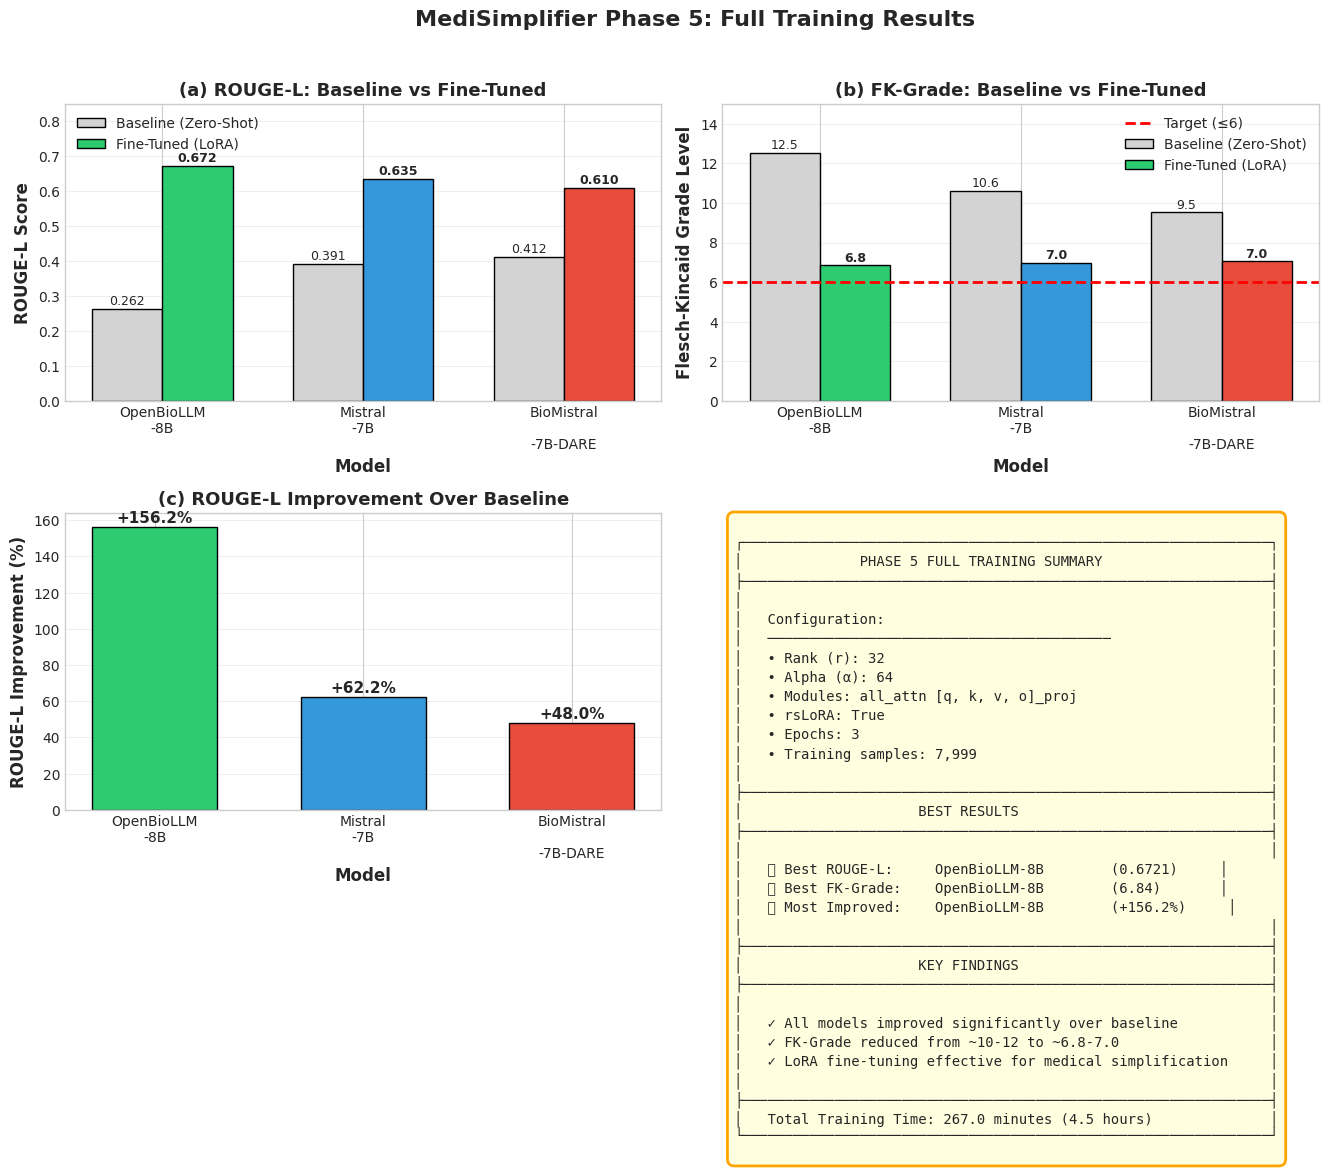


📦 6.3.4.7 Save Full Training Summary:
   ✓ Saved: full_training_summary.json

PHASE 5 FULL TRAINING COMPLETE - ALL MODELS

┌─────────────────────────────────────────────────────────────────────────────┐
│                          FULL TRAINING RESULTS                              │
├─────────────────────────────────────────────────────────────────────────────┤
│  Model                │ ROUGE-L │ FK-Grade │ Baseline │ Improvement         │
├─────────────────────────────────────────────────────────────────────────────┤
│  OpenBioLLM-8B        │ 0.6721  │  6.84    │  0.2623   │  +156.2%              │
│  Mistral-7B           │ 0.6346  │  6.95    │  0.3912   │  +62.2%              │
│  BioMistral-7B-DARE   │ 0.6098  │  7.05    │  0.4120   │  +48.0%              │
├─────────────────────────────────────────────────────────────────────────────┤
│  Total Training Time: 267.0 minutes (4.5 hours)                              │
└───────────────────────────────────────────────────────────────────

In [21]:
# =============================================================================
# SECTION 6.3.4: FULL TRAINING SUMMARY & VISUALIZATION
# =============================================================================

# Print section header with separator
print("=" * 70)
# Print section title
print("SECTION 6.3.4: FULL TRAINING SUMMARY & VISUALIZATION")
# Print closing separator
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.3.4.1 Load All Training Checkpoints
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.1 Load All Training Checkpoints:")

# Define dictionary mapping model names to their checkpoint file paths
TRAINING_CHECKPOINTS = {
    # OpenBioLLM uses llama3 architecture naming
    "OpenBioLLM-8B": TRAINING_DIR / "final_training_llama3.json",
    # Mistral-7B uses mistral architecture naming
    "Mistral-7B": TRAINING_DIR / "final_training_mistral.json",
    # BioMistral uses custom biomistral naming
    "BioMistral-7B-DARE": TRAINING_DIR / "final_training_biomistral.json",
}

# Initialize empty dictionary to store loaded results
training_results = {}

# Iterate through each model and its checkpoint path
for model_name, path in TRAINING_CHECKPOINTS.items():
    # Check if checkpoint file exists on disk
    if path.exists():
        # Open file in read mode
        with open(path, "r") as f:
            # Parse JSON and store in results dictionary
            training_results[model_name] = json.load(f)
        # Print success message with filename
        print(f"   ✓ Loaded: {path.name}")
    else:
        # Print error message for missing file
        print(f"   ❌ Missing: {path.name}")
        # Store None for missing checkpoints
        training_results[model_name] = None

# Check if all checkpoints were successfully loaded
all_loaded = all(v is not None for v in training_results.values())
# Print verification status
print(f"\n   All checkpoints loaded: {all_loaded}")

# -----------------------------------------------------------------------------
# 6.3.4.2 Load Baseline Results for Comparison
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.2 Load Baseline Results:")

# Define path to baseline results from Chapter 5
BASELINE_PATH = BASELINE_DIR / "baseline_results.json"

# Check if baseline file exists
if BASELINE_PATH.exists():
    # Open and load baseline JSON file
    with open(BASELINE_PATH, "r") as f:
        # Parse JSON into dictionary
        baseline_raw = json.load(f)
    # Print success message
    print(f"   ✓ Loaded: {BASELINE_PATH.name}")
    
    # Extract results from nested "results" key (actual JSON structure)
    baseline_results = baseline_raw.get("results", {})
    # Print number of models found
    print(f"   ✓ Found {len(baseline_results)} model baselines")
else:
    # Fallback to hardcoded values from master plan
    print(f"   ⚠️ Using hardcoded baseline values")
    # Hardcoded values with correct key names matching JSON structure
    baseline_results = {
        "OpenBioLLM-8B": {"ROUGE-L": 0.2623, "FK-Grade-Mean": 12.53, "SARI": 36.98, "BERTScore-F1": 0.6371},
        "Mistral-7B": {"ROUGE-L": 0.3912, "FK-Grade-Mean": 10.60, "SARI": 46.38, "BERTScore-F1": 0.7335},
        "BioMistral-7B-DARE": {"ROUGE-L": 0.4120, "FK-Grade-Mean": 9.52, "SARI": 51.91, "BERTScore-F1": 0.7426},
    }

# Verify loaded baseline values
print(f"\n   Baseline values:")
# Iterate through each model's baseline data
for model, data in baseline_results.items():
    # Print ROUGE-L and FK-Grade for verification (using correct keys)
    print(f"      {model}: ROUGE-L={data.get('ROUGE-L', 0):.4f}, FK={data.get('FK-Grade-Mean', 0):.2f}")

# -----------------------------------------------------------------------------
# 6.3.4.3 Create Summary DataFrame
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.3 Create Summary DataFrame:")

# Initialize empty list to store row dictionaries
summary_rows = []

# Iterate through models in specific order for consistent display
for model_name in ["OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"]:
    # Get training results for this model (empty dict if None)
    train_data = training_results.get(model_name, {})
    # Get baseline results for this model (empty dict if None)
    base_data = baseline_results.get(model_name, {})
    
    # Only process if training data exists
    if train_data:
        # Extract baseline ROUGE-L (key is "ROUGE-L" in baseline JSON)
        base_rouge = base_data.get("ROUGE-L", 0)
        # Extract fine-tuned ROUGE-L (key is "rouge_l" in training checkpoint)
        train_rouge = train_data.get("rouge_l", 0)
        # Calculate percentage improvement: (new - old) / old * 100
        rouge_improvement = ((train_rouge - base_rouge) / base_rouge * 100) if base_rouge > 0 else 0
        
        # Extract baseline FK-Grade (key is "FK-Grade-Mean" in baseline JSON)
        base_fk = base_data.get("FK-Grade-Mean", 0)
        # Extract fine-tuned FK-Grade (key is "fk_grade_mean" in training checkpoint)
        train_fk = train_data.get("fk_grade_mean", 0)
        # Calculate FK improvement (baseline - finetuned, since lower FK is better)
        fk_improvement = base_fk - train_fk
        
        # Append row dictionary with all metrics
        summary_rows.append({
            # Model display name
            "Model": model_name,
            # Architecture type (llama3 or mistral)
            "Architecture": train_data.get("architecture", ""),
            # Trainable parameters in millions, rounded to 2 decimals
            "Trainable Params (M)": round(train_data.get("trainable_params", 0) / 1e6, 2),
            # Training loss rounded to 4 decimals
            "Train Loss": round(train_data.get("train_loss", 0), 4),
            # Evaluation loss rounded to 4 decimals
            "Eval Loss": round(train_data.get("eval_loss", 0), 4),
            # ROUGE-L score rounded to 4 decimals
            "ROUGE-L": round(train_rouge, 4),
            # FK-Grade mean rounded to 2 decimals
            "FK-Grade": round(train_fk, 2),
            # FK-Grade standard deviation rounded to 2 decimals
            "FK-Std": round(train_data.get("fk_grade_std", 0), 2),
            # Training time in minutes rounded to 1 decimal
            "Time (min)": round(train_data.get("train_time_minutes", 0), 1),
            # Baseline ROUGE-L for comparison
            "Baseline ROUGE-L": round(base_rouge, 4),
            # ROUGE-L percentage improvement
            "ROUGE-L Δ%": round(rouge_improvement, 1),
            # Baseline FK-Grade for comparison
            "Baseline FK": round(base_fk, 2),
            # FK-Grade absolute improvement (positive = better)
            "FK Δ": round(fk_improvement, 2),
        })

# Create pandas DataFrame from list of row dictionaries
df_summary = pd.DataFrame(summary_rows)
# Print confirmation with row count
print(f"   ✓ Summary DataFrame: {len(df_summary)} models")

# Verify values are correctly loaded
print(f"\n   Comparison check:")
# Iterate through DataFrame rows
for _, row in df_summary.iterrows():
    # Print baseline vs fine-tuned comparison
    print(f"      {row['Model']}: Baseline={row['Baseline ROUGE-L']:.4f} → Tuned={row['ROUGE-L']:.4f} (+{row['ROUGE-L Δ%']:.1f}%)")

# -----------------------------------------------------------------------------
# 6.3.4.4 Display Summary Tables
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.4 Summary Tables:")

# Print Table 1 header with separator
print(f"\n{'─'*90}")
print("TABLE 1: FULL TRAINING RESULTS (3 Epochs)")
print(f"{'─'*90}")
# Display selected columns without row index
print(df_summary[["Model", "Architecture", "Train Loss", "Eval Loss", "ROUGE-L", "FK-Grade", "FK-Std", "Time (min)"]].to_string(index=False))

# Print Table 2 header with separator
print(f"\n{'─'*90}")
print("TABLE 2: BASELINE vs FINE-TUNED COMPARISON")
print(f"{'─'*90}")
# Display comparison columns without row index
print(df_summary[["Model", "Baseline ROUGE-L", "ROUGE-L", "ROUGE-L Δ%", "Baseline FK", "FK-Grade", "FK Δ"]].to_string(index=False))

# -----------------------------------------------------------------------------
# 6.3.4.5 Compute Rankings
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.5 Model Rankings:")

# Print rankings header
print(f"\n{'─'*70}")
print("RANKINGS")
print(f"{'─'*70}")

# Define medal emojis for top 3 positions
medals = ["🥇", "🥈", "🥉"]

# ROUGE-L ranking (higher is better)
print("\n🏆 By ROUGE-L (Quality):")
# Sort by ROUGE-L descending and iterate with index
for idx, (_, row) in enumerate(df_summary.sort_values("ROUGE-L", ascending=False).iterrows()):
    # Get medal for this position
    medal = medals[idx]
    # Print model with medal and score
    print(f"   {medal} {row['Model']}: {row['ROUGE-L']:.4f}")

# FK-Grade ranking (lower is better, target ≤6)
print("\n🏆 By FK-Grade (Readability, target ≤6):")
# Sort by FK-Grade ascending and iterate
for idx, (_, row) in enumerate(df_summary.sort_values("FK-Grade").iterrows()):
    # Get medal for this position
    medal = medals[idx]
    # Print model with medal and score
    print(f"   {medal} {row['Model']}: {row['FK-Grade']:.2f}")

# Improvement ranking (higher improvement is better)
print("\n🏆 By ROUGE-L Improvement (vs Baseline):")
# Sort by improvement descending and iterate
for idx, (_, row) in enumerate(df_summary.sort_values("ROUGE-L Δ%", ascending=False).iterrows()):
    # Get medal for this position
    medal = medals[idx]
    # Print model with medal and improvement percentage
    print(f"   {medal} {row['Model']}: +{row['ROUGE-L Δ%']:.1f}%")

# -----------------------------------------------------------------------------
# 6.3.4.6 Generate Visualizations
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.6 Generate Visualizations:")

# Set matplotlib style for clean grid-based plots
plt.style.use('seaborn-v0_8-whitegrid')

# Define color palette for consistent model colors across all plots
COLORS = {
    # Green for OpenBioLLM (medical, Llama3 architecture)
    "OpenBioLLM-8B": "#2ecc71",
    # Blue for Mistral (general purpose)
    "Mistral-7B": "#3498db",
    # Red for BioMistral (medical, Mistral architecture)
    "BioMistral-7B-DARE": "#e74c3c",
}

# Create figure with 2x2 grid of subplots, 14x11 inches
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (a): ROUGE-L Baseline vs Fine-Tuned
# ─────────────────────────────────────────────────────────────────────────────

# Select first subplot (top-left)
ax = axes[0, 0]

# Get list of model names from DataFrame
models = df_summary["Model"].tolist()

# Create x-axis positions for each model (0, 1, 2)
x = np.arange(len(models))

# Define width of each bar
bar_width = 0.35

# Extract baseline ROUGE-L values as list
baseline_rouge = df_summary["Baseline ROUGE-L"].tolist()

# Extract fine-tuned ROUGE-L values as list
finetuned_rouge = df_summary["ROUGE-L"].tolist()

# Create bars for baseline (shifted left by half bar width)
bars1 = ax.bar(
    x - bar_width/2,            # X positions shifted left
    baseline_rouge,              # Y values (baseline scores)
    bar_width,                   # Width of bars
    label='Baseline (Zero-Shot)', # Legend label
    color='lightgray',           # Gray color for baseline
    edgecolor='black',           # Black border
    linewidth=1                  # Border width
)

# Create bars for fine-tuned (shifted right by half bar width)
bars2 = ax.bar(
    x + bar_width/2,            # X positions shifted right
    finetuned_rouge,             # Y values (fine-tuned scores)
    bar_width,                   # Width of bars
    label='Fine-Tuned (LoRA)',   # Legend label
    color=[COLORS[m] for m in models],  # Model-specific colors
    edgecolor='black',           # Black border
    linewidth=1                  # Border width
)

# Add value labels on top of baseline bars
for bar in bars1:
    # Get bar height for label positioning
    height = bar.get_height()
    # Add annotation above bar
    ax.annotate(
        f'{height:.3f}',         # Format value to 3 decimals
        xy=(bar.get_x() + bar.get_width()/2, height),  # Position at bar center top
        xytext=(0, 3),           # Offset 3 points up
        textcoords="offset points",  # Use point offset
        ha='center',             # Horizontal align center
        fontsize=9               # Font size
    )

# Add value labels on top of fine-tuned bars (bold)
for bar in bars2:
    # Get bar height for label positioning
    height = bar.get_height()
    # Add annotation above bar
    ax.annotate(
        f'{height:.3f}',         # Format value to 3 decimals
        xy=(bar.get_x() + bar.get_width()/2, height),  # Position at bar center top
        xytext=(0, 3),           # Offset 3 points up
        textcoords="offset points",  # Use point offset
        ha='center',             # Horizontal align center
        fontsize=9,              # Font size
        fontweight='bold'        # Bold for emphasis
    )

# Set x-axis label
ax.set_xlabel("Model", fontsize=12, fontweight='bold')
# Set y-axis label
ax.set_ylabel("ROUGE-L Score", fontsize=12, fontweight='bold')
# Set subplot title
ax.set_title("(a) ROUGE-L: Baseline vs Fine-Tuned", fontsize=13, fontweight='bold')
# Set x-tick positions
ax.set_xticks(x)
# Set x-tick labels with line breaks for readability
ax.set_xticklabels([m.replace("-7B-DARE", "\n-7B-DARE").replace("-8B", "\n-8B").replace("-7B", "\n-7B") for m in models], fontsize=10)
# Add legend in upper left
ax.legend(loc='upper left', fontsize=10)
# Set y-axis limits (0 to 0.85 for padding)
ax.set_ylim(0, 0.85)
# Add light grid on y-axis only
ax.grid(True, alpha=0.3, axis='y')

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (b): FK-Grade Baseline vs Fine-Tuned
# ─────────────────────────────────────────────────────────────────────────────

# Select second subplot (top-right)
ax = axes[0, 1]

# Extract baseline FK-Grade values as list
baseline_fk = df_summary["Baseline FK"].tolist()

# Extract fine-tuned FK-Grade values as list
finetuned_fk = df_summary["FK-Grade"].tolist()

# Create bars for baseline FK (shifted left)
bars1 = ax.bar(
    x - bar_width/2,            # X positions shifted left
    baseline_fk,                 # Y values (baseline FK scores)
    bar_width,                   # Width of bars
    label='Baseline (Zero-Shot)', # Legend label
    color='lightgray',           # Gray color for baseline
    edgecolor='black',           # Black border
    linewidth=1                  # Border width
)

# Create bars for fine-tuned FK (shifted right)
bars2 = ax.bar(
    x + bar_width/2,            # X positions shifted right
    finetuned_fk,                # Y values (fine-tuned FK scores)
    bar_width,                   # Width of bars
    label='Fine-Tuned (LoRA)',   # Legend label
    color=[COLORS[m] for m in models],  # Model-specific colors
    edgecolor='black',           # Black border
    linewidth=1                  # Border width
)

# Add horizontal line at target FK-Grade of 6
ax.axhline(
    y=6,                         # Y position
    color='red',                 # Red color
    linestyle='--',              # Dashed line
    linewidth=2,                 # Line width
    label='Target (≤6)'          # Legend label
)

# Add value labels on top of baseline FK bars
for bar in bars1:
    # Get bar height
    height = bar.get_height()
    # Add annotation
    ax.annotate(
        f'{height:.1f}',         # Format to 1 decimal
        xy=(bar.get_x() + bar.get_width()/2, height),  # Position
        xytext=(0, 3),           # Offset
        textcoords="offset points",
        ha='center',
        fontsize=9
    )

# Add value labels on top of fine-tuned FK bars (bold)
for bar in bars2:
    # Get bar height
    height = bar.get_height()
    # Add annotation
    ax.annotate(
        f'{height:.1f}',         # Format to 1 decimal
        xy=(bar.get_x() + bar.get_width()/2, height),  # Position
        xytext=(0, 3),           # Offset
        textcoords="offset points",
        ha='center',
        fontsize=9,
        fontweight='bold'        # Bold for emphasis
    )

# Set x-axis label
ax.set_xlabel("Model", fontsize=12, fontweight='bold')
# Set y-axis label
ax.set_ylabel("Flesch-Kincaid Grade Level", fontsize=12, fontweight='bold')
# Set subplot title
ax.set_title("(b) FK-Grade: Baseline vs Fine-Tuned", fontsize=13, fontweight='bold')
# Set x-tick positions
ax.set_xticks(x)
# Set x-tick labels with line breaks
ax.set_xticklabels([m.replace("-7B-DARE", "\n-7B-DARE").replace("-8B", "\n-8B").replace("-7B", "\n-7B") for m in models], fontsize=10)
# Add legend in upper right
ax.legend(loc='upper right', fontsize=10)
# Set y-axis limits (0 to 15)
ax.set_ylim(0, 15)
# Add light grid on y-axis
ax.grid(True, alpha=0.3, axis='y')

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (c): ROUGE-L Improvement Percentage
# ─────────────────────────────────────────────────────────────────────────────

# Select third subplot (bottom-left)
ax = axes[1, 0]

# Extract improvement percentages as list
improvements = df_summary["ROUGE-L Δ%"].tolist()

# Create single bar chart for improvements
bars = ax.bar(
    x,                           # X positions
    improvements,                # Y values (improvement %)
    0.6,                         # Bar width (wider since no grouping)
    color=[COLORS[m] for m in models],  # Model-specific colors
    edgecolor='black',           # Black border
    linewidth=1                  # Border width
)

# Add value labels on top of improvement bars
for bar in bars:
    # Get bar height
    height = bar.get_height()
    # Add annotation with + sign
    ax.annotate(
        f'+{height:.1f}%',       # Format with + and % symbol
        xy=(bar.get_x() + bar.get_width()/2, height),  # Position
        xytext=(0, 3),           # Offset
        textcoords="offset points",
        ha='center',
        fontsize=11,
        fontweight='bold'        # Bold for emphasis
    )

# Set x-axis label
ax.set_xlabel("Model", fontsize=12, fontweight='bold')
# Set y-axis label
ax.set_ylabel("ROUGE-L Improvement (%)", fontsize=12, fontweight='bold')
# Set subplot title
ax.set_title("(c) ROUGE-L Improvement Over Baseline", fontsize=13, fontweight='bold')
# Set x-tick positions
ax.set_xticks(x)
# Set x-tick labels with line breaks
ax.set_xticklabels([m.replace("-7B-DARE", "\n-7B-DARE").replace("-8B", "\n-8B").replace("-7B", "\n-7B") for m in models], fontsize=10)
# Add light grid on y-axis
ax.grid(True, alpha=0.3, axis='y')

# ─────────────────────────────────────────────────────────────────────────────
# Subplot (d): Summary Text Box
# ─────────────────────────────────────────────────────────────────────────────

# Select fourth subplot (bottom-right)
ax = axes[1, 1]

# Turn off axis for text-only display
ax.axis('off')

# Find model with highest ROUGE-L
best_rouge_idx = df_summary["ROUGE-L"].idxmax()
best_rouge_model = df_summary.loc[best_rouge_idx, "Model"]
best_rouge_val = df_summary["ROUGE-L"].max()

# Find model with lowest (best) FK-Grade
best_fk_idx = df_summary["FK-Grade"].idxmin()
best_fk_model = df_summary.loc[best_fk_idx, "Model"]
best_fk_val = df_summary["FK-Grade"].min()

# Find model with highest improvement
best_improve_idx = df_summary["ROUGE-L Δ%"].idxmax()
best_improve_model = df_summary.loc[best_improve_idx, "Model"]
best_improve_val = df_summary["ROUGE-L Δ%"].max()

# Calculate total training time across all models
total_time = df_summary["Time (min)"].sum()

# Create multi-line summary text string
summary_text = f"""
┌───────────────────────────────────────────────────────────────┐
│              PHASE 5 FULL TRAINING SUMMARY                    │
├───────────────────────────────────────────────────────────────┤
│                                                               │
│   Configuration:                                              │
│   ─────────────────────────────────────────                   │
│   • Rank (r): 32                                              │
│   • Alpha (α): 64                                             │
│   • Modules: all_attn [q, k, v, o]_proj                       │
│   • rsLoRA: True                                              │
│   • Epochs: 3                                                 │
│   • Training samples: 7,999                                   │
│                                                               │
├───────────────────────────────────────────────────────────────┤
│                     BEST RESULTS                              │
├───────────────────────────────────────────────────────────────┤
│                                                               │
│   🏆 Best ROUGE-L:     {best_rouge_model:<20} ({best_rouge_val:.4f})     │
│   🏆 Best FK-Grade:    {best_fk_model:<20} ({best_fk_val:.2f})       │
│   🏆 Most Improved:    {best_improve_model:<20} (+{best_improve_val:.1f}%)     │
│                                                               │
├───────────────────────────────────────────────────────────────┤
│                     KEY FINDINGS                              │
├───────────────────────────────────────────────────────────────┤
│                                                               │
│   ✓ All models improved significantly over baseline           │
│   ✓ FK-Grade reduced from ~10-12 to ~6.8-7.0                  │
│   ✓ LoRA fine-tuning effective for medical simplification     │
│                                                               │
├───────────────────────────────────────────────────────────────┤
│   Total Training Time: {total_time:.1f} minutes ({total_time/60:.1f} hours)              │
└───────────────────────────────────────────────────────────────┘
"""

# Add summary text to subplot
ax.text(
    0.02,                        # X position (2% from left)
    0.98,                        # Y position (98% from bottom)
    summary_text,                # Text content
    transform=ax.transAxes,      # Use axes coordinates (0-1)
    fontsize=10,                 # Font size
    verticalalignment='top',     # Align to top of text box
    fontfamily='monospace',      # Use monospace font for alignment
    bbox=dict(                   # Text box styling
        boxstyle='round,pad=0.5',    # Rounded corners with padding
        facecolor='lightyellow',      # Yellow background
        edgecolor='orange',           # Orange border
        linewidth=2                   # Border width
    )
)

# Add main figure title
fig.suptitle(
    "MediSimplifier Phase 5: Full Training Results",  # Title text
    fontsize=16,                 # Font size
    fontweight='bold',           # Bold
    y=0.98                       # Y position (slightly below top)
)

# Adjust subplot layout with space for main title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure to file
fig.savefig(
    FIGURES_DIR / "full_training_summary.png",  # Output path
    dpi=150,                     # Resolution
    bbox_inches='tight',         # Tight bounding box
    facecolor='white'            # White background
)

# Print confirmation
print(f"   ✓ Saved: {FIGURES_DIR / 'full_training_summary.png'}")

# Display figure inline (for Jupyter)
plt.show()

# Close figure to free memory
plt.close(fig)

# -----------------------------------------------------------------------------
# 6.3.4.7 Save Full Training Summary JSON
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.7 Save Full Training Summary:")

# Create comprehensive summary dictionary
full_training_summary = {
    # Phase identifier
    "phase": "full_training",
    # Training configuration used
    "config": {
        "rank": 32,                  # LoRA rank from Phase 1
        "alpha": 64,                 # Alpha = 2 * rank
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # Phase 2 optimal
        "use_rslora": True,          # Phase 4 literature-based
        "epochs": 3,                 # Full training epochs
        "train_samples": 7999,       # Full dataset size
    },
    # Placeholder for per-model results
    "results": {},
    # Rankings by different metrics
    "rankings": {
        # Models sorted by ROUGE-L (highest first)
        "rouge_l": df_summary.sort_values("ROUGE-L", ascending=False)["Model"].tolist(),
        # Models sorted by FK-Grade (lowest first)
        "fk_grade": df_summary.sort_values("FK-Grade")["Model"].tolist(),
        # Models sorted by improvement (highest first)
        "improvement": df_summary.sort_values("ROUGE-L Δ%", ascending=False)["Model"].tolist(),
    },
    # Best performing models per metric
    "best_results": {
        "rouge_l": {"model": best_rouge_model, "value": float(best_rouge_val)},
        "fk_grade": {"model": best_fk_model, "value": float(best_fk_val)},
        "improvement": {"model": best_improve_model, "value": float(best_improve_val)},
    },
    # Total training time
    "total_time_minutes": float(total_time),
    # Timestamp for record keeping
    "timestamp": datetime.now().isoformat(),
}

# Add detailed per-model results
for model_name in models:
    # Get row for this model
    row = df_summary[df_summary["Model"] == model_name].iloc[0]
    # Store all metrics for this model
    full_training_summary["results"][model_name] = {
        "architecture": row["Architecture"],
        "trainable_params": int(row["Trainable Params (M)"] * 1e6),
        "train_loss": float(row["Train Loss"]),
        "eval_loss": float(row["Eval Loss"]),
        "rouge_l": float(row["ROUGE-L"]),
        "fk_grade_mean": float(row["FK-Grade"]),
        "fk_grade_std": float(row["FK-Std"]),
        "time_minutes": float(row["Time (min)"]),
        "baseline_rouge_l": float(row["Baseline ROUGE-L"]),
        "rouge_improvement_pct": float(row["ROUGE-L Δ%"]),
        "baseline_fk": float(row["Baseline FK"]),
        "fk_improvement": float(row["FK Δ"]),
    }

# Define output path for summary JSON
summary_path = TRAINING_DIR / "full_training_summary.json"

# Write summary to JSON file
with open(summary_path, "w") as f:
    # Serialize with indentation for readability
    json.dump(full_training_summary, f, indent=2)

# Print confirmation
print(f"   ✓ Saved: {summary_path.name}")

# -----------------------------------------------------------------------------
# 6.3.4.8 Final Summary Display
# -----------------------------------------------------------------------------

# Print section separator
print(f"\n{'='*70}")
print("PHASE 5 FULL TRAINING COMPLETE - ALL MODELS")
print(f"{'='*70}")

# Print formatted results table header
print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                          FULL TRAINING RESULTS                              │
├─────────────────────────────────────────────────────────────────────────────┤
│  Model                │ ROUGE-L │ FK-Grade │ Baseline │ Improvement         │
├─────────────────────────────────────────────────────────────────────────────┤""")

# Print each model row sorted by ROUGE-L
for _, row in df_summary.sort_values("ROUGE-L", ascending=False).iterrows():
    # Print formatted row with all metrics
    print(f"│  {row['Model']:<20} │ {row['ROUGE-L']:.4f}  │  {row['FK-Grade']:.2f}    │  {row['Baseline ROUGE-L']:.4f}   │  +{row['ROUGE-L Δ%']:.1f}%              │")

# Print table footer with total time
print(f"""├─────────────────────────────────────────────────────────────────────────────┤
│  Total Training Time: {total_time:.1f} minutes ({total_time/60:.1f} hours)                              │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# Print list of generated figures
print(f"\n📊 Generated Figures:")
print(f"   • {FIGURES_DIR / 'full_training_summary.png'}")

# Print list of generated data files
print(f"\n📁 Generated Files:")
print(f"   • {TRAINING_DIR / 'full_training_summary.json'}")

# -----------------------------------------------------------------------------
# 6.3.4.9 Verify Saved Adapters
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 6.3.4.9 Verify Saved Adapters:")

# Define mapping of model names to adapter directories
adapter_paths = {
    "OpenBioLLM-8B": MODELS_DIR / "openbiollm_8b_lora",
    "Mistral-7B": MODELS_DIR / "mistral_7b_lora",
    "BioMistral-7B-DARE": MODELS_DIR / "biomistral_7b_dare_lora",
}

# Check each adapter directory
for model_name, path in adapter_paths.items():
    # Check if adapter directory exists
    if path.exists():
        # List all files in adapter directory
        files = list(path.glob("*"))
        # Check for main adapter weights file
        adapter_file = path / "adapter_model.safetensors"
        # Verify adapter file exists
        if adapter_file.exists():
            # Get file size in megabytes
            size_mb = adapter_file.stat().st_size / 1e6
            # Print success with file count and size
            print(f"   ✓ {model_name}: {len(files)} files, adapter={size_mb:.1f}MB")
        else:
            # Print warning if adapter file missing
            print(f"   ⚠️ {model_name}: {len(files)} files (adapter not found)")
    else:
        # Print error if directory missing
        print(f"   ❌ {model_name}: Path not found")

# Print final section separator
print("\n" + "=" * 70)
print("✅ SECTION 6.3.4 COMPLETE - CHAPTER 6 FINISHED")
print("=" * 70)

# Print next steps
print("\n🎯 Next: Chapter 7 - Evaluation (Full Test Set)")